In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from scipy.stats import pearsonr,spearmanr,kendalltau, linregress
from scipy.optimize import curve_fit 

warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=1.4) 
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines
from os.path import exists

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_log_error, confusion_matrix, classification_report, accuracy_score,explained_variance_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate, GridSearchCV, KFold, RandomizedSearchCV

from sklearn.neural_network import MLPRegressor

import xgboost as xgb

import datarobot as dr

import json

/data2/lthapa/miniconda3/envs/ML_py/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Helper Functions

In [2]:
def shift_ndays(df_to_shift,ndays,name_col_to_shift, name_shifted_col, time_col):
    df_shifted = resample_daily(df_to_shift, time_col)
    for ii in range(len(name_shifted_col)):
        df_shifted[name_shifted_col[ii]] = df_shifted[name_col_to_shift[ii]].shift(ndays)
    return df_shifted

In [3]:
def plot_correlations(df_all, fig_title,correlation_type, font_size):
    #make the correlation matrix
    corrMatrix = df_all.corr(method=correlation_type)
    
    #plot it
    fig,ax=plt.subplots(figsize=(25,25))
    sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic', annot_kws={'fontsize':font_size})
    plt.title(fig_title, fontsize=20)
    plt.show()

In [4]:
#IN forest: a trained random forest
#IN varnames: names of the training variables, list of strings
#IN plot_title: title of the resulting plot 
def plot_importances(forest, varnames,plot_title):
    tree_indices = np.arange(0, len(forest.feature_importances_)) + 0.5
    importances = forest.feature_importances_ #importances for all trees, so if you have 100 trees and 5 features this is a 100x5 (or 5x100) matrix
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    df_plot = pd.DataFrame({'tree_indices': tree_indices, 'importances': importances, 'std':std, 'varnames':varnames})
    df_plot = df_plot.sort_values(by='importances').reset_index(drop=True) #sorts from high to low importance

    #make the figure 
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 20))
    ax1.barh(df_plot.index, df_plot['importances'], height=0.7,xerr = std) #horizontal bar plot
    ax1.set_yticks(df_plot.index) #set the ticks
    ax1.set_yticklabels(df_plot['varnames']) #set the names of the ticks
    ax1.set_ylim((-0.5, len(df_plot['importances']))) #the height of the figure depends on the # of variables plotted
    fig.tight_layout()
    plt.title(plot_title) #title!
    plt.show()

In [5]:
def resample_daily(df_nondaily, time_name):
    df_nondaily['datetime'] = pd.to_datetime(df_nondaily[time_name])
    df_nondaily = df_nondaily.set_index(['datetime'])
    df_daily = df_nondaily.resample('D').asfreq()
    df_daily = df_daily.reset_index()
    return df_daily

In [6]:
def REC(y_pred, y_test):
    #percent_error = np.abs((y_pred-y_test)/y_test)*100
    percent_error = np.abs((y_pred-y_test)) #this is absolute error
    #thresholds = np.linspace(0,300, 61) #5% increments
    thresholds = np.arange(0,10, 0.1)
    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

def AUC(acc):
    return(np.sum(acc*0.1)) #left hand approximation, assuming bins are 5 wide

# Medium post on error metrics https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
def RMSE(y_pred,y_test):
    return np.sqrt(np.nanmean(((y_pred)-(y_test))**2))

def MAD(y_pred,y_test): #aka mean error
    return np.mean(np.abs(y_pred-y_test))

def MeAD(y_pred,y_test): #aka median error
    return np.nanmedian(np.abs(y_pred-y_test))

def mean_percent_error(y_pred,y_test):
    return(np.mean(np.abs(100*(y_pred-y_test)/y_test)))

def median_percent_error(y_pred,y_test):
    return(np.nanmedian(np.abs(100*(y_pred-y_test)/y_test)))

def fractional_error(y_pred, y_test):
    num=np.sum(np.abs(y_pred-y_test))
    denom=np.sum((y_pred+y_test)/2)
    return(num/denom)

def mdrae(y_test, y_pred, bnchmrk):
    return np.nanmedian(np.abs(y_test - y_pred)/np.abs(y_test - bnchmrk))

In [7]:
def scatter_plot(df_plot,x_plot,y_plot,point_hue, point_style, point_size, point_size_range,plot_title):
    fig,ax=plt.subplots(figsize=(10,10))
    sns.scatterplot(data =df_plot, x=x_plot,y=y_plot,hue=point_hue,
                    style=point_style,size=point_size,sizes=point_size_range,ax=ax,cmap='vlag')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.title(plot_title)
    plt.show()

In [8]:
def combine_years(base_file_name, years): # for when all of one year is in a dataframe
    df_all = pd.DataFrame()
    for yr in years:
        filename = base_file_name.replace('YYYY', str(yr))
        df = pd.read_csv(filename)
        df_all = pd.concat([df_all, df], axis=0).reset_index(drop=True)
    return df_all

In [9]:
def combine_per_fire_csv(ids, prefix, str_check): #for when a variable is split by fire, takes a list of irwinids
    df_all = pd.DataFrame()
    for i_d in ids:
        for fname in os.listdir(prefix):
            if fname.startswith(i_d) & (str_check in fname):
                df_fire = pd.read_csv(prefix+fname)
                df_all = pd.concat([df_all, df_fire], axis=0).reset_index(drop=True)
    return df_all

In [10]:
def add_to_features(feats, data_to_add): #feats has the multi index of irwinID, day
    #multiindex = data_to_add.set_index(['irwinID', 'day'])
    feats = pd.merge(feats, data_to_add, how='inner', on=['irwinID', 'day']).drop(columns='Unnamed: 0')
    return feats

In [46]:
def generate_feature_vector(years, is_weighted, features_to_use):
    if 'rave' in features_to_use:
        rave = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_RAVE_Unweighted_12Z_day_start.csv', years)
        print('rave', len(rave))
        features = rave[['irwinID','day']].set_index(['irwinID', 'day'])
        features = add_to_features(features, rave).drop_duplicates()
        
    if 'hwp' in features_to_use:
        hwp = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_HWP_'+is_weighted+'_12Z_day_start.csv', years)
        print('hwp', len(hwp))
        features = add_to_features(features, hwp).drop_duplicates()

    if 'hdw' in features_to_use:
        hdw = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_HDW_'+is_weighted+'_12Z_day_start.csv', years)
        print('hdw', len(hdw))
        features = add_to_features(features, hdw).drop_duplicates()
        
    if 'resources' in features_to_use:
        """resources = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_resources/', '')"""
        resources = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_resources_split/', '')
        print('resources', len(resources))
        features = add_to_features(features, resources).drop_duplicates()
        
    if 'pft' in features_to_use:
        pft = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_pft/', is_weighted)
        print('pft', len(pft))
        features = add_to_features(features, pft).drop_duplicates()
        
    if 'smops' in features_to_use:
        smops = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_SMOPS_'+is_weighted+'_12Z_day_start.csv', years)
        print('smops', len(smops))
        features = add_to_features(features, smops).drop_duplicates()

    if 'imerg' in features_to_use:
        imerg = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_IMERG_FWI_'+is_weighted+'_12Z_day_start.csv', years)
        print('imerg', len(imerg))
        features = add_to_features(features, imerg).drop_duplicates()

    if 'pws' in features_to_use:
        pws = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_PWS_'+is_weighted+'_12Z_day_start.csv', years)
        print('pws', len(pws))
        features = add_to_features(features, pws).drop_duplicates()
        
    if 'loading' in features_to_use:
        loading = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_LOADING_'+is_weighted+'_12Z_day_start.csv', years)
        print('loading', len(loading))
        features = add_to_features(features, loading).drop_duplicates()
        
    """if 'slope' in features_to_use:
        slope = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_SLOPE_'+is_weighted+'_12Z_day_start.csv', years)
        print('slope', len(slope))
        features = add_to_features(features, slope).drop_duplicates()"""

    if 'ncar' in features_to_use:
        ncar = combine_per_fire_csv(np.unique(rave['irwinID'].values),   
                            './fire_features_ncar/', is_weighted)
        print('ncar', len(ncar))
        features = add_to_features(features, ncar).drop_duplicates()

    
    if 'esi' in features_to_use:
        esi = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_esi/', is_weighted)
        print('esi', len(esi))
        features = add_to_features(features, esi).drop_duplicates()
        
    if 'chi' in features_to_use:
        chi_2019 = combine_years('./fire_features_3/ClippedFiresYYYY_Daily_CHI_'+is_weighted+'_12Z_day_start.csv', years)
        chi_2020 = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_chi/', is_weighted)
        chi= pd.concat([chi_2019, chi_2020], axis=0).reset_index(drop=True)
        print('chi', len(chi))
        features = add_to_features(features, chi).drop_duplicates()
        
    if 'pop' in features_to_use:
        pop = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_pop/', is_weighted)
        print('pop', len(pop))
        features = add_to_features(features, pop).drop_duplicates()
        
    if 'structures' in features_to_use:
        structures = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_structures/', '')
        print('structures', len(structures))
        features = add_to_features(features, structures).drop_duplicates()
        
    if 'gridmet' in features_to_use:
        gridmet = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_gridmet/',is_weighted)
        print('gridmet', len(gridmet))
        features = add_to_features(features, gridmet).drop_duplicates()
        
    if 'slope' in features_to_use:
        slope = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_slope/',is_weighted)
        print('slope', len(slope))
        features = add_to_features(features, slope).drop_duplicates()
        
    if 'elevation' in features_to_use:
        elevation = combine_per_fire_csv(np.unique(rave['irwinID'].values), 
                            './fire_features_elevation/',is_weighted)
        print('elevation', len(elevation))
        features = add_to_features(features, elevation).drop_duplicates()
        
        
    return features


In [12]:
def find_outliers(df, col_name):
    quantiles = df[col_name].quantile(q=[.25, .5, .75])
    print(quantiles)
    iqr = quantiles[0.75]-quantiles[0.25]
    lower_fence = quantiles[0.50]-(1.5*iqr)
    upper_fence = quantiles[0.50]+(1.5*iqr)
    print('lower and upper fences are: '+ str(lower_fence) + ', '+ str(upper_fence))
    df[col_name+'_is_outlier'] = np.where((df[col_name]<=lower_fence)| (df[col_name]>=upper_fence), True,False)
    return df

In [13]:
def get_relative_features(df, names): #to today/yesterday, flip it later
    for name in names:
        df['rel_'+name] = df[name]/df[name+'_1']
    return df

In [14]:
def get_dfeatures(df, names, suf_now, suf_back): #to today/yesterday, flip it later
    for name in names:
        df['d'+name+suf_now] = df[name+suf_now]/df[name+suf_back]
    return df

In [15]:
#df is a data frame full of predictions and ground truth values
# prediction and truth are strings 
def get_metrics_df(df, prediction, truth, thold):
    #thresholds = ['change_category_tenthsig', 'change_category_fifthsig', 'change_category_fourthsig', 
    #          'change_category_thirdsig', 'change_category_halfsig','change_category_sig']

    metrics = pd.DataFrame(index = thold, columns=['AUC_increase', 'AUC_no_change', 'AUC_decrease',
                                                    'RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'])
    for thresh in thold:
        data_increase = df[df[thresh]=='large_increase']
        data_no_change = df[df[thresh]=='no_change']
        data_decrease = df[df[thresh]=='large_decrease']
        
        thresh_increase, acc_increase = REC(data_increase[prediction], data_increase[truth])
        metrics.loc[thresh, 'AUC_increase'] = AUC(acc_increase)
        metrics.loc[thresh, 'RMSE_increase'] = RMSE(data_increase[prediction], data_increase[truth])

    
        thresh_no_change, acc_no_change = REC(data_no_change[prediction], data_no_change[truth])
        metrics.loc[thresh, 'AUC_no_change'] = AUC(acc_no_change)
        metrics.loc[thresh, 'RMSE_no_change'] = RMSE(data_no_change[prediction], data_no_change[truth])

        thresh_decrease, acc_decrease = REC(data_decrease[prediction], data_decrease[truth])
        metrics.loc[thresh, 'AUC_decrease'] = AUC(acc_decrease)
        metrics.loc[thresh, 'RMSE_decrease'] = RMSE(data_decrease[prediction], data_decrease[truth])
    return metrics

In [16]:
#df is a data frame full of predictions and ground truth values
# prediction and truth are strings 
def get_classification_metrics_df(df, thold_prediction, thold_truth):
    #thresholds = ['change_category_tenthsig', 'change_category_fifthsig', 'change_category_fourthsig', 
    #          'change_category_thirdsig', 'change_category_halfsig','change_category_sig']

    metrics = pd.DataFrame(index = thold_truth, columns=['F1_increase', 'F1_no_change', 'F1_decrease', 
                                                         'precision_increase', 'precision_no_change', 'precision_decrease',
                                                         'recall_increase', 'recall_no_change', 'recall_decrease'])
    for ii in range(len(thold_prediction)):
        
        cr = classification_report(df[thold_truth[ii]], df[thold_prediction[ii]], output_dict=True)

    
        metrics.loc[thold_truth[ii], 'F1_increase'] = cr['large_increase']['f1-score']
        metrics.loc[thold_truth[ii], 'F1_no_change'] = cr['no_change']['f1-score']
        metrics.loc[thold_truth[ii], 'F1_decrease'] = cr['large_decrease']['f1-score']
        
        metrics.loc[thold_truth[ii], 'precision_increase'] = cr['large_increase']['precision']
        metrics.loc[thold_truth[ii], 'precision_no_change'] = cr['no_change']['precision']
        metrics.loc[thold_truth[ii], 'precision_decrease'] = cr['large_decrease']['precision']
        
        metrics.loc[thold_truth[ii], 'recall_increase'] = cr['large_increase']['recall']
        metrics.loc[thold_truth[ii], 'recall_no_change'] = cr['no_change']['recall']
        metrics.loc[thold_truth[ii], 'recall_decrease'] = cr['large_decrease']['recall']

    return metrics

In [17]:
def plot_confusion(df, true_cat, pred_cat, plot_title):
    conf_mat = confusion_matrix(df[true_cat], df[pred_cat], labels=['large_increase', 'no_change', 'large_decrease'])
    columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
    df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
    # Visualize it as a heatmap
    sns.heatmap(df_cm, annot=True,cmap='rocket_r')
    plt.title(plot_title)
    plt.xlabel('Predicted Class')
    plt.ylabel('Target Class')
    plt.show()
    
    #print the classification report
    print(classification_report(df[true_cat], df[pred_cat]))

In [18]:
def correlation_summary(df, true_label, prediction_label):
    print('Pearson Correlation: ' + str(df[[prediction_label, true_label]].corr(method='pearson').iloc[0,1]))
    print('Spearman Correlation: ' + str(df[[prediction_label, true_label]].corr(method='spearman').iloc[0,1]))
    print('Kendall Correlation: ' + str(df[[prediction_label, true_label]].corr(method='kendall').iloc[0,1]))
    print('R2: ' + str(r2_score(df[true_label],df[prediction_label])))
    

In [19]:
def plot_category_heatmap(data_plot, obs_label, mod_label, model_axis_label):
    conf_mat = confusion_matrix(data_plot[obs_label], data_plot[mod_label], labels=['decrease', 'no_change', 'increase'])
    columns = ['decrease', 'slight \n change', 'increase'] #makes sure the columns are in the right order
    df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
    #swap order of rows and cols
    df_cm_reverse = df_cm.iloc[::-1]

    # Visualize it as a heatmap
    sns.heatmap(df_cm_reverse, annot=True,cmap='rocket_r', fmt='g' ) #fmt g keeps things out of scientific notation
    plt.xlabel(model_axis_label)
    plt.ylabel('True Class')
    plt.show()
    print(classification_report(data_plot[obs_label], data_plot[mod_label]))
    
    
def frp_hist2d(df_plot, x_data, y_data,log_x_data,log_y_data, cmap_name, v_min, v_max, x_axis_label):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    errors = summarize_error(df_plot,y_data, log_y_data, x_data, log_x_data)
    norm = colors.Normalize(vmin=v_min, vmax=v_max)
    cmap=cm.get_cmap(cmap_name)
    fig, axn = plt.subplots()#figsize=(6,6))
    hist1=axn.hist2d(df_plot[log_x_data], df_plot[log_y_data],bins=20, norm=norm, cmap=cmap) 
    axn.plot(np.arange(-1,7), np.arange(-1,7), 'k-')
    axn.plot(np.arange(-1,7), np.arange(-1,7)*lr.slope+lr.intercept, 'r-')
    axn.text(0.2,3.8,y_data+'='+str(round(lr.slope,2))+'*'+x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log FRP R2='+str(round(errors[0],3))
             +'\n FRP R2='+str(round(errors[1],3))
             +'\n FRP RMSE='+str(round(errors[2],3))
             +'\n FRP MAD='+str(round(errors[3],3)), fontsize=10)
    fig.colorbar(hist1[3], ax=axn)
    plt.xlim(0,6)
    plt.ylim(0,6)
    plt.ylabel('Observed Log(FRP)')
    plt.xlabel(x_axis_label)
    plt.show()


def summarize_error(df, truth_name, log_truth_name, method_name, log_method_name):
    log_r2 =r2_score(df[log_truth_name], df[log_method_name])
    r2 =r2_score(df[truth_name], df[method_name])
    rmse =RMSE(df[truth_name], df[method_name])
    mad =MAD(df[truth_name], df[method_name])
    
    return(log_r2, r2, rmse, mad)

def plot_2dhist_withfit(df_plot, x_data, y_data, log_x_data,log_y_data, inc_cutoff, dec_cutoff, title):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    errors = summarize_error(df_plot,y_data, log_y_data, x_data, log_x_data)

    fig, axn = plt.subplots()#figsize=(6,6))
    

    plt.axhline(y=inc_cutoff, xmin=-1, xmax=1, color='g')
    plt.axhline(y=dec_cutoff, xmin=-1, xmax=1, color='g')
    
    plt.axvline(x=inc_cutoff, ymin=-1, ymax=1, color='g')
    plt.axvline(x=dec_cutoff, ymin=-1, ymax=1, color='g')
    
    sns.histplot(data=df_plot, x=log_x_data, y=log_y_data, bins=20,cbar=True, ax=axn) 
    plt.plot(np.arange(-1,2), np.arange(-1,2), 'k-')
    plt.plot(np.arange(-1,2), np.arange(-1,2)*lr.slope+lr.intercept, 'b-')
    
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    
    
    #plt.text(-1.6,0.8,log_y_data+'=\n'+str(round(lr.slope,2))+'*'+log_x_data+'+'+str(round(lr.intercept,2)), fontsize=12)
    plt.text(-1.4, 0.3,log_y_data+'='+str(round(lr.slope,2))+'*'+log_x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log SF R2='+str(round(errors[0],3))
             +'\n SF R2='+str(round(errors[1],3))
             +'\n SF RMSE='+str(round(errors[2],3))
             +'\n SF MAD='+str(round(errors[3],3)), fontsize=10)
    plt.title(title)
    plt.show()
    


# Prepare the features for ML

the generate_feature_vector code generates duplicate rows that must be dropped

In [47]:
"""features = generate_feature_vector([2019, 2020,2021], 'Weighted', ['rave', 'hwp', 'hdw', 'resources','pft', 'smops','imerg',
                                                             'pws', 'loading', 'ncar','esi','chi'])"""
features = generate_feature_vector([2019,2020,2021], 'Weighted', ['rave', 'hwp', 'hdw', 'resources','pft', 
                                                                  'smops','imerg',
                                                             'pws', 'loading', 'ncar','esi','chi', 'slope', 'elevation',
                                                                  'pop','structures','gridmet'])
"""features = generate_feature_vector([2019, 2020, 2021], 'Weighted', ['rave', 'hwp', 'hdw', 'resources','pft','imerg',
                                                             'pws','esi','chi', 'slope'])"""

print('With one day fires: ', len(np.unique(features['irwinID'])), len(features))

rave 5432
hwp 5432
hdw 5432
resources 11146
pft 5432
smops 5432
imerg 5339
pws 5432
loading 5432
ncar 5199
esi 5444
chi 6437
pop 5432
structures 12296
gridmet 5432
slope 5432
elevation 5432
With one day fires:  421 4830


In [48]:
# drop fires that last one day
features_ge_2 = features[features.groupby('irwinID')['day'].transform('size').ge(2)].reset_index(drop=True)
print('Dropping one day fires: ', len(np.unique(features_ge_2['irwinID'])), len(features_ge_2))

features_ge_3 = features[features.groupby('irwinID')['day'].transform('size').ge(3)].reset_index(drop=True)
print('Dropping one and two day fires: ', len(np.unique(features_ge_3['irwinID'])), len(features_ge_3))

features_ge = features_ge_2

Dropping one day fires:  327 4736
Dropping one and two day fires:  258 4598


### Multiple days back of shifting

In [ ]:
#shift the features
events = np.unique(features_ge['irwinID']) #all the incidents

features_to_shift = ['FRP_MEAN','hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI',
                     'PFT', 'chi', 'percent_contained',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',]#features_ge.columns.values[2:]

features_shifted_1 = [] #one day shifts
features_shifted_2 = [] #two day shifts
features_shifted_3 = [] #three day shifts

print(features_to_shift)

for ii in range(len(features_to_shift)):
    features_shifted_1.append(features_to_shift[ii]+'_1')
    features_shifted_2.append(features_to_shift[ii]+'_2')
    features_shifted_3.append(features_to_shift[ii]+'_3')


features_with_shifts_weighted = pd.DataFrame()

for jj in range(len(events)):
    df_fire = features_ge[features_ge['irwinID']==events[jj]].drop_duplicates(subset='day') #removes duplicate rows
    df_fire_shifted_1 = shift_ndays(df_fire, 1, features_to_shift, features_shifted_1, 'day')
    df_fire_shifted_2 = shift_ndays(df_fire, 2, features_to_shift, features_shifted_2, 'day')
    df_fire_shifted_3 = shift_ndays(df_fire, 3, features_to_shift, features_shifted_3, 'day')

    
    
    df_fire_concat = pd.concat([df_fire_shifted_1,
                                df_fire_shifted_2[features_shifted_2],
                                df_fire_shifted_3[features_shifted_3]], axis=1)
    #add the day of the fire, starting at zero
    df_fire_concat['day_of_fire'] = np.arange(0,len(df_fire_concat))
    #print(df_fire_concat)
    features_with_shifts_weighted = pd.concat([features_with_shifts_weighted, 
                                               df_fire_concat], axis=0).reset_index(drop=True)
    

#get the scaling factor
features_with_shifts_weighted['Scaling_Factor'] = features_with_shifts_weighted['FRP_MEAN']/features_with_shifts_weighted['FRP_MEAN_1']
features_with_shifts_weighted['Scaling_Factor_1'] = features_with_shifts_weighted['FRP_MEAN_1']/features_with_shifts_weighted['FRP_MEAN_2']
features_with_shifts_weighted['Scaling_Factor_2'] = features_with_shifts_weighted['FRP_MEAN_2']/features_with_shifts_weighted['FRP_MEAN_3']

#get the log of the scaling factor
features_with_shifts_weighted['Log_Scaling_Factor']= np.log10(features_with_shifts_weighted['Scaling_Factor'])
print(len(features_with_shifts_weighted))


#replace infs with nans, dropping days that were added for the shift as well as days where the scaling factor may have gone to inf
"""print(features_with_shifts_weighted['FRP_MEAN_2'])
for feat in features_shifted_2:
    features_with_shifts_weighted[feat].replace(np.nan, 0, inplace=True)
print(features_with_shifts_weighted['FRP_MEAN_2'])"""

features_with_shifts_weighted.replace([np.inf, -np.inf], np.nan, inplace=True)

#drop nans (get rid of this for testing the 19/20 WF/DIXIE case)
features_with_shifts_weighted = features_with_shifts_weighted.dropna(axis=0,how='any').reset_index(drop=True)
print(len(features_with_shifts_weighted))

#get the outliers
features_with_shifts_weighted = find_outliers(features_with_shifts_weighted, 'Log_Scaling_Factor')
print(len(features_with_shifts_weighted[features_with_shifts_weighted['Log_Scaling_Factor_is_outlier']==False]))
print(features_with_shifts_weighted.head()) #this is ordered by the irwinID, so 2019 and 2020 will be somewhat jumbled

In [ ]:
#features_relative = get_relative_features(features_with_shifts_weighted, ['hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'PFT', 'chi'])
#features_relative = get_relative_features(features_with_shifts_weighted, ['IMERG.FINAL.v6_FWI'])

features_relative = get_dfeatures(features_with_shifts_weighted, ['hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'PFT', 'chi'], 
                                '', '_1') #to today/yesterday, flip it later

features_relative = get_dfeatures(features_with_shifts_weighted, ['hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'PFT', 'chi'], 
                                '_1', '_2') #to today/yesterday, flip it later

features_relative = get_dfeatures(features_with_shifts_weighted, ['hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'PFT', 'chi'], 
                                '_2', '_3') #to today/yesterday, flip it later


### One day of shifting 

In [49]:
#shift the features
events = np.unique(features_ge['irwinID']) #all the incidents

"""features_to_shift = ['FRP_MEAN','hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI','PFT', 'chi', 'percent_contained',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',]#features_ge.columns.values[2:]"""

features_to_shift = ['FRP_MEAN',
                     'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 
                     'IMERG.FINAL.v6_FWI','IMERG.FINAL.v6_BUI', 'burning_index_g','energy_release_component-g',
                     'PFT', 'chi', 
                     'percent_contained',
                     'personnel', 'crew_quantity', 'crew_personnel','engine_quantity', 'engine_personnel', 'air_quantity', 
                    'air_personnel','construction_quantity', 'construction_personnel','overhead_personnel']#features_ge.columns.values[2:]
features_shifted_1 = [] #one day shifts

print(features_to_shift)

for ii in range(len(features_to_shift)):
    features_shifted_1.append(features_to_shift[ii]+'_1')


features_with_shifts_weighted = pd.DataFrame()

for jj in range(len(events)):
    df_fire = features_ge[features_ge['irwinID']==events[jj]].drop_duplicates(subset='day') #removes duplicate rows
    df_fire_shifted_1 = shift_ndays(df_fire, 1, features_to_shift, features_shifted_1, 'day')

    
    
    df_fire_concat = pd.concat([df_fire_shifted_1], axis=1)    
    
    features_with_shifts_weighted = pd.concat([features_with_shifts_weighted, 
                                               df_fire_concat], axis=0).reset_index(drop=True)
    

#get the scaling factor
features_with_shifts_weighted['Scaling_Factor'] = features_with_shifts_weighted['FRP_MEAN']/features_with_shifts_weighted['FRP_MEAN_1']

#get the log of the scaling factor
features_with_shifts_weighted['Log_Scaling_Factor']= np.log10(features_with_shifts_weighted['Scaling_Factor'])

#replace infs with nans, dropping days that were added for the shift as well as days where the scaling factor may have gone to inf
"""print(features_with_shifts_weighted['FRP_MEAN_2'])
for feat in features_shifted_2:
    features_with_shifts_weighted[feat].replace(np.nan, 0, inplace=True)
print(features_with_shifts_weighted['FRP_MEAN_2'])"""

features_with_shifts_weighted.replace([np.inf, -np.inf], np.nan, inplace=True)

#drop nans (get rid of this for testing the 19/20 WF/DIXIE case)
features_with_shifts_weighted = features_with_shifts_weighted.dropna(axis=0,how='any').reset_index(drop=True)
print(len(features_with_shifts_weighted))

#get the outliers
features_with_shifts_weighted = find_outliers(features_with_shifts_weighted, 'Log_Scaling_Factor')
print(len(features_with_shifts_weighted[features_with_shifts_weighted['Log_Scaling_Factor_is_outlier']==False]))
print(features_with_shifts_weighted.head()) #this is ordered by the irwinID, so 2019 and 2020 will be somewhat jumbled

['FRP_MEAN', 'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_BUI', 'burning_index_g', 'energy_release_component-g', 'PFT', 'chi', 'percent_contained', 'personnel', 'crew_quantity', 'crew_personnel', 'engine_quantity', 'engine_personnel', 'air_quantity', 'air_personnel', 'construction_quantity', 'construction_personnel', 'overhead_personnel']
3373
0.25   -0.477343
0.50   -0.020185
0.75    0.421403
Name: Log_Scaling_Factor, dtype: float64
lower and upper fences are: -1.3683050962989678, 1.3279349808483203
3014
    datetime                               irwinID         day      FRP_MEAN  \
0 2020-09-10  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-10  14731.512078   
1 2020-09-11  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-11   2706.065915   
2 2020-09-12  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-12   1349.205056   
3 2020-09-13  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2020-09-13    144.146576   
4 2020-09-14  00B3EDB2-87A4-4D0A-A834-4E1012BF9693  2

In [50]:
#features_relative = get_relative_features(features_with_shifts_weighted, ['hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'PFT', 'chi'])
#features_relative = get_relative_features(features_with_shifts_weighted, ['IMERG.FINAL.v6_FWI'])

features_relative = get_dfeatures(features_with_shifts_weighted,
                                  [
                     'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 
                     'IMERG.FINAL.v6_FWI','IMERG.FINAL.v6_BUI', 'burning_index_g','energy_release_component-g',
                     'PFT', 'chi', ], 
                                '', '_1') #to today/yesterday, flip it later
features_relative

,datetime,irwinID,day,FRP_MEAN,hwp,hd0w0,hd1w0,hd2w0,hd3w0,personnel,...,dhd0w0,dhd1w0,dhd2w0,dhd3w0,dIMERG.FINAL.v6_FWI,dIMERG.FINAL.v6_BUI,dburning_index_g,denergy_release_component-g,dPFT,dchi
0,2020-09-10,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,2020-09-10,14731.512078,20.266123,76.251916,71.615403,56.609646,65.150074,161.0,...,0.458325,0.550687,0.399642,0.468245,0.880133,1.021306,0.656202,1.011018,0.574754,1.110429
1,2020-09-11,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,2020-09-11,2706.065915,4.070484,45.794999,63.764926,64.395492,51.311115,228.0,...,0.600575,0.890380,1.137536,0.787583,0.850910,1.002732,0.537188,0.869561,1.794887,0.805037
2,2020-09-12,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,2020-09-12,1349.205056,5.601118,40.359152,43.245293,55.749052,53.689521,262.0,...,0.881300,0.678199,0.865729,1.046353,0.908600,1.004065,1.471190,1.111402,2.048905,1.041910
3,2020-09-13,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,2020-09-13,144.146576,7.664088,38.327457,37.678304,42.160805,50.909355,284.0,...,0.949660,0.871269,0.756260,0.948218,0.608108,0.869195,0.990512,0.981018,1.436864,1.191298
4,2020-09-14,00B3EDB2-87A4-4D0A-A834-4E1012BF9693,2020-09-14,6632.251236,4.327472,30.957482,28.211336,28.481330,30.379819,367.0,...,0.807710,0.748742,0.675540,0.596743,1.073250,1.159620,0.984226,0.960519,8.327272,0.916140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3368,2020-11-06,FF65A04D-419D-4791-BAA4-FBBAB29AA03F,2020-11-06,744.962650,18.123903,49.311801,73.675495,57.912320,54.821594,32.0,...,0.835394,1.588194,1.327220,1.415159,1.034771,1.015233,0.966087,0.978715,0.034481,0.315213
3369,2019-08-05,FFB76BC8-8D44-4C76-9EBF-8C21A102BEEA,2019-08-05,35859.885506,26.468965,103.244273,102.551687,99.557550,94.726957,308.0,...,0.721067,0.759316,0.774611,0.852768,0.987846,1.014045,0.840805,1.011769,1.235748,0.989617
3370,2019-08-06,FFB76BC8-8D44-4C76-9EBF-8C21A102BEEA,2019-08-06,7581.656204,30.501696,131.392407,126.678070,126.411251,122.512574,415.0,...,1.272636,1.235261,1.269730,1.293323,0.859460,1.027729,1.052443,1.009285,0.892821,1.000944
3371,2019-08-07,FFB76BC8-8D44-4C76-9EBF-8C21A102BEEA,2019-08-07,493.522446,15.781312,90.719094,109.778669,106.745789,107.452266,404.0,...,0.690444,0.866596,0.844433,0.877071,0.786791,0.997046,0.907770,0.989866,0.426011,0.907609


### Rest of feature prepping code

In [51]:
#get mu and sigma from the distribution with the outliers
mu = np.mean(features_relative['Log_Scaling_Factor']) #none of these are nans!
sigma = np.std(features_relative['Log_Scaling_Factor'])
print('Mean and STDEV for the blue curve is')
print('mu = '+ str(mu))
print('sigma = '+ str(sigma))

Mean and STDEV for the blue curve is
mu = -0.04269622937934478
sigma = 0.8243787710686796


In [52]:
#drop outliers and nans
features_no_outliers_weighted = features_relative[features_with_shifts_weighted['Log_Scaling_Factor_is_outlier']==False]
features_no_outliers_weighted = features_no_outliers_weighted.replace([np.inf, -np.inf], np.nan) #if scaling factor is infinity, GET RID
features_no_outliers_weighted= features_no_outliers_weighted.dropna(axis=0,how='any').reset_index(drop=True) #drop any because persistence will always be 0

features_no_outliers_weighted['persistence'] = np.ones(len(features_no_outliers_weighted))
features_no_outliers_weighted['log_persistence'] = np.zeros(len(features_no_outliers_weighted))
features_no_outliers_weighted['Log_FRP'] = np.log10(features_no_outliers_weighted['FRP_MEAN'])

#add some features
features_no_outliers_weighted['DOY'] = features_no_outliers_weighted['datetime'].dt.strftime('%j').astype(int)
features_no_outliers_weighted['year'] = features_no_outliers_weighted['datetime'].dt.strftime('%Y').astype(int)
features_no_outliers_weighted['month'] = features_no_outliers_weighted['datetime'].dt.strftime('%m').astype(int)
features_no_outliers_weighted['day'] = features_no_outliers_weighted['datetime'].dt.strftime('%d').astype(int)

features_no_outliers_weighted['log_FRP_MEAN'] = np.log10(features_no_outliers_weighted['FRP_MEAN'])
features_no_outliers_weighted['log_FRP_MEAN_1'] = np.log10(features_no_outliers_weighted['FRP_MEAN_1'])
features_no_outliers_weighted['Log_Scaling_Factor_Persistence'] = 0
features_no_outliers_weighted['Scaling_Factor_Persistence'] = 1

"""features_no_outliers_weighted['log_dhwp'] = np.log10(features_no_outliers_weighted['dhwp'])
features_no_outliers_weighted['log_dhdw'] = np.log10(features_no_outliers_weighted['dhd0w0'])
features_no_outliers_weighted['log_dfwi'] = np.log10(features_no_outliers_weighted['dIMERG.FINAL.v6_FWI'])
features_no_outliers_weighted['log_SM'] = np.log10(features_no_outliers_weighted['Blended_SM'])
features_no_outliers_weighted['log_ffmc'] = np.log10(features_no_outliers_weighted['IMERG.FINAL.v6_FFMC'])

features_no_outliers_weighted['1_Blended_SM'] = 1-features_no_outliers_weighted['Blended_SM']
features_no_outliers_weighted['log_1_SM'] = np.log10(features_no_outliers_weighted['1_Blended_SM'])"""

#do one-hot encoding on the cause
#ohe = OneHotEncoder()
#transformed = ohe.fit_transform(features_no_outliers_weighted[['cause']])
#print(transformed)
#features_no_outliers_weighted[ohe.categories_[0]] = transformed.toarray()



"features_no_outliers_weighted['log_dhwp'] = np.log10(features_no_outliers_weighted['dhwp'])\nfeatures_no_outliers_weighted['log_dhdw'] = np.log10(features_no_outliers_weighted['dhd0w0'])\nfeatures_no_outliers_weighted['log_dfwi'] = np.log10(features_no_outliers_weighted['dIMERG.FINAL.v6_FWI'])\nfeatures_no_outliers_weighted['log_SM'] = np.log10(features_no_outliers_weighted['Blended_SM'])\nfeatures_no_outliers_weighted['log_ffmc'] = np.log10(features_no_outliers_weighted['IMERG.FINAL.v6_FFMC'])\n\nfeatures_no_outliers_weighted['1_Blended_SM'] = 1-features_no_outliers_weighted['Blended_SM']\nfeatures_no_outliers_weighted['log_1_SM'] = np.log10(features_no_outliers_weighted['1_Blended_SM'])"

### The train-test split!

In [ ]:
#get the irwinids of the test fires!
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

In [ ]:
#do the train-test split
#test fires
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test), np.unique(data_test['year']))

#2020 all fires, including August Complex
data_test_2020 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']>=np.datetime64('2020-01-01 00:00:00'))&
                                              (features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00'))] #time range
print(len(data_test_2020), np.unique(data_test_2020['year'])) #includes august complex

#2019/2021 Training Set
print('19/21')
data_train_1921 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2020-01-01 00:00:00'))|
                                              (features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00'))]
print(len(data_train_1921), np.unique(data_train_1921['year']))
data_train_1921 = data_train_1921.iloc[np.where(~data_train_1921.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_1921), np.unique(data_train_1921['year']))

print('19')
data_train_19 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2020-01-01 00:00:00'))]
data_train_19 = data_train_19.iloc[np.where(~data_train_19.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_19), np.unique(data_train_19['year']))

print('21')
data_train_21 = features_no_outliers_weighted[features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00')]
data_train_21 = data_train_21.iloc[np.where(~data_train_21.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_21), np.unique(data_train_21['year']))

## Function discovery with Eureqa on DataRobot

following this github tutorial: https://github.com/datarobot-community/tutorials-for-data-scientists/blob/master/Regression/Python/double_pendulum_with_eureqa/src/Double%20Pendulum%20with%20Eureqa%20Models.ipynb

### Upload the 2019/2021 Training Dataset to Eureqa

In [ ]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

In [ ]:

#do the train-test split
#test fires
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test), np.unique(data_test['year']))

#2020 all fires, including August Complex
data_test_2020 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']>=np.datetime64('2020-01-01 00:00:00'))&
                                              (features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00'))] #time range
print(len(data_test_2020), np.unique(data_test_2020['year'])) #includes august complex

#2019/2021 Training Set
data_train_1921 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2020-01-01 00:00:00'))|
                                              (features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00'))]
print(len(data_train_1921), np.unique(data_train_1921['year']))
data_train_1921 = data_train_1921.iloc[np.where(~data_train_1921.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_1921), np.unique(data_train_1921['year']))

In [ ]:
dr.Client(token='NjQ3NGRkYTJiNDczMDg4MGQzMzM4ZmJhOjZSR3pCb1ZTNTlyM1FjejNFd1ZVNUlWYmo1Yng1WUIwcG8xYm1ua2xkWGs9',
         endpoint='https://app2.datarobot.com/api/v2') #seems happy with this, token I made in my developer settings on DataRobot


In [ ]:
#make the project
project = dr.Project.create(data_train_1921[['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0','IMERG.FINAL.v6_FWI', 
                                        'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','dIMERG.FINAL.v6_FWI', 
                                        'dPFT','dchi', 
                                        'PFT', 'chi',
                                        'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', #NO MORE DEAD FM
                                        'PWS', 'ESI',
                                        'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                                        'DOY',
                                        'percent_contained_1','Scaling_Factor', 'Log_Scaling_Factor','FRP_MEAN_1']],
                            project_name = 'Function discovery for Scaling_Factor')
project

### Initial Tries at Eureqa

In [ ]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

In [ ]:
features_no_outliers_weighted['DOY'] = features_no_outliers_weighted['datetime'].dt.strftime('%j').astype(int)
features_no_outliers_weighted['year'] = features_no_outliers_weighted['datetime'].dt.strftime('%Y').astype(int)
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test))
print(np.where(data_test.isna()))

data_train = features_no_outliers_weighted[features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00')] #time range
data_train = data_train.iloc[np.where(~data_train.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and AC

print(len(data_train), len(data_test))
print(np.where(data_train.irwinID.str.contains('|'.join(test_irwin_ids))))

In [ ]:
#https://docs.datarobot.com/en/docs/api/api-quickstart/index.html (DATAROBOT API QUICKSTART)
dr.Client(token='NjQ3NGRkYTJiNDczMDg4MGQzMzM4ZmJhOjZSR3pCb1ZTNTlyM1FjejNFd1ZVNUlWYmo1Yng1WUIwcG8xYm1ua2xkWGs9',
         endpoint='https://app2.datarobot.com/api/v2') #seems happy with this, token I made in my developer settings on DataRobot


In [ ]:
#make the project
project = dr.Project.create(features_no_outliers_weighted[['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0',  #no canadian weather index
                                        'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', #no canadian weather index
                                        'dPFT','dchi', 
                                        'PFT', 'chi',
                                        'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', #NO MORE DEAD FM
                                        'PWS', 'ESI',
                                        'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                                        'DOY',
                                        'percent_contained_1','Scaling_Factor' ]],
                            project_name = 'Function discovery for Scaling Factor 3')
project

In [ ]:
#set scaling factor as the target variable
project.set_target(target='Scaling_Factor', metric='RMSE', mode=dr.AUTOPILOT_MODE.MANUAL)

In [ ]:
#which eureqa models are available to use?
eureqa_regressors = [bp for bp in project.get_blueprints() if 'Eureqa Regressor' in bp.model_type]
[print(bp.model_type) for bp in eureqa_regressors]

# Select the one with the default search (3000 generations).
eureqa_bp = eureqa_regressors[1] #0 is the quick one
eureqa_bp

In [ ]:
# Train the Eureqa Regressor, with default parameters
model_job_id = project.train(eureqa_bp, sample_pct= 60)

dr.models.modeljob.wait_for_async_model_creation(project.id, model_job_id, max_wait=600)

In [ ]:
project.get_models()

In [ ]:
# Investigate the default model

# Get the default model
default_model = project.get_models()[0]
print(default_model)

# Retrieve the Pareto Front
pf = default_model.get_pareto_front() #maybe there isn't a trained model yet?

# Print the best solution found
default_solutions = pf.solutions
best_solution = [s for s in default_solutions if s.best_model][0]
print(best_solution.expression)

## Machine Learning

### Figures for Fuels Meeting (7/19)

In [53]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

#do the train-test split
#test fires
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test), np.unique(data_test['year']))

#2020 all fires, including August Complex
data_test_2020 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']>=np.datetime64('2020-01-01 00:00:00'))&
                                              (features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00'))] #time range
print(len(data_test_2020), np.unique(data_test_2020['year'])) #includes august complex

#2019/2021 Training Set
data_train_1921 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2020-01-01 00:00:00'))|
                                              (features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00'))]
print(len(data_train_1921), np.unique(data_train_1921['year']))
data_train_1921 = data_train_1921.iloc[np.where(~data_train_1921.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_1921), np.unique(data_train_1921['year']))

['EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA', '7D2A6B0A-A161-44D9-BFF1-6A68CEA947C5', 'E9DB628D-DFB7-4C85-BCD6-1254574D946B']
134 [2019 2020 2021]
1570 [2020]
1309 [2019 2021]
1234 [2019 2021]


dhwp
dhd0w0
dhd1w0
dhd2w0
dhd3w0
dIMERG.FINAL.v6_FWI
dburning_index_g
['datetime' 'irwinID' 'day' 'FRP_MEAN' 'hwp' 'hd0w0' 'hd1w0' 'hd2w0'
 'hd3w0' 'personnel' 'crew_quantity' 'crew_personnel' 'engine_quantity'
 'engine_personnel' 'air_quantity' 'air_personnel' 'construction_quantity'
 'construction_personnel' 'overhead_personnel' 'percent_contained' 'U_ml'
 'z_fc' 'dtheta_fc' 'PFT' 'Blended_SM' 'IMERG.FINAL.v6_DC'
 'IMERG.FINAL.v6_DMC' 'IMERG.FINAL.v6_FFMC' 'IMERG.FINAL.v6_ISI'
 'IMERG.FINAL.v6_BUI' 'IMERG.FINAL.v6_FWI' 'IMERG.FINAL.v6_DSR' 'PWS'
 'Extreme_N' 'VeryHigh_N' 'High_N' 'Moderate_N' 'Low_N' 'FMCG2D'
 'FMCGLH2D' 'ESI' 'temp_850' 'temp_700' 'dewpt_850' 'ca' 'cb' 'chi'
 'POP_DENSITY' 'structures_destroyed' 'structures_damaged'
 'structures_threatened_72' 'burning_index_g' 'energy_release_component-g'
 'dead_fuel_moisture_1000hr' 'dead_fuel_moisture_100hr' 'MEAN_SLOPE'
 'STD_SLOPE' 'MEAN_ELEV' 'STD_ELEV' 'FRP_MEAN_1' 'hwp_1' 'hd0w0_1'
 'hd1w0_1' 'hd2w0_1' 'hd3w0_1' 'IMERG.FINAL

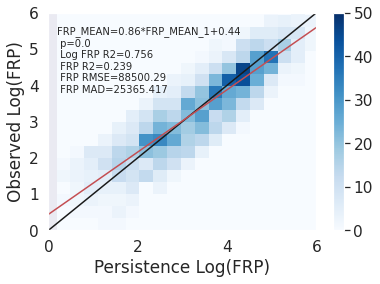

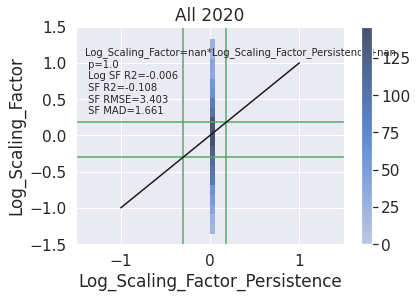

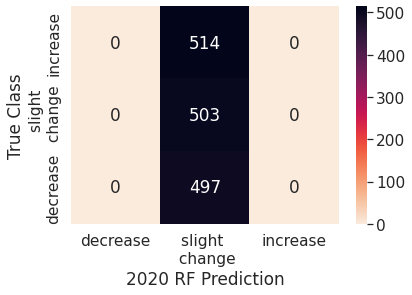

              precision    recall  f1-score   support

    decrease       0.00      0.00      0.00       497
    increase       0.00      0.00      0.00       514
   no_change       0.33      1.00      0.50       503

    accuracy                           0.33      1514
   macro avg       0.11      0.33      0.17      1514
weighted avg       0.11      0.33      0.17      1514



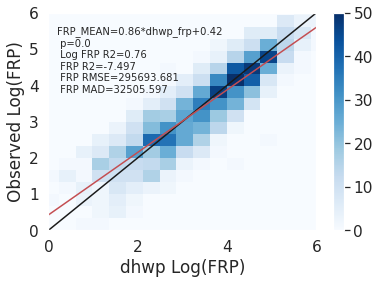

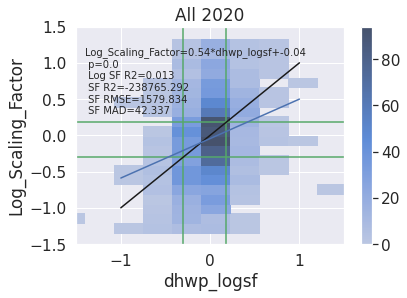

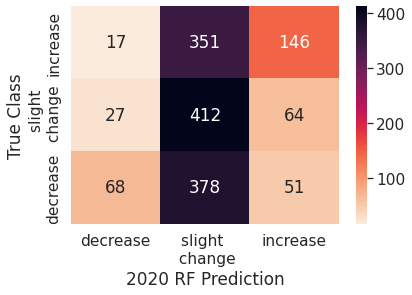

              precision    recall  f1-score   support

    decrease       0.61      0.14      0.22       497
    increase       0.56      0.28      0.38       514
   no_change       0.36      0.82      0.50       503

    accuracy                           0.41      1514
   macro avg       0.51      0.41      0.37      1514
weighted avg       0.51      0.41      0.37      1514



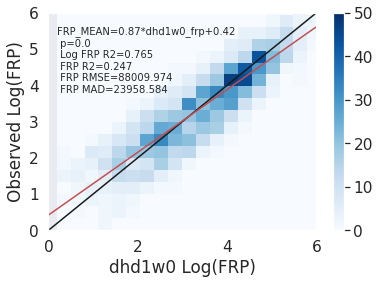

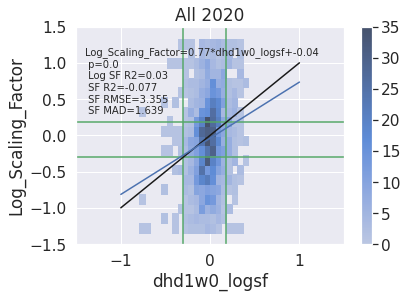

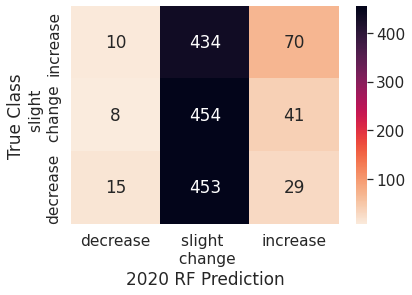

              precision    recall  f1-score   support

    decrease       0.45      0.03      0.06       497
    increase       0.50      0.14      0.21       514
   no_change       0.34      0.90      0.49       503

    accuracy                           0.36      1514
   macro avg       0.43      0.36      0.25      1514
weighted avg       0.43      0.36      0.25      1514



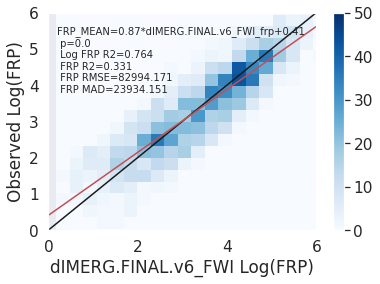

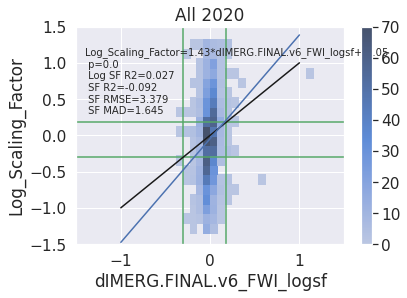

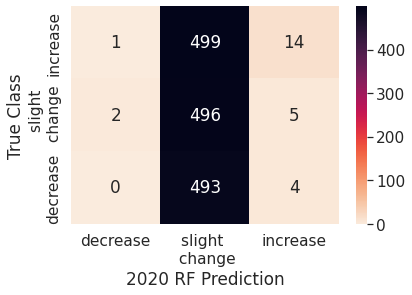

              precision    recall  f1-score   support

    decrease       0.00      0.00      0.00       497
    increase       0.61      0.03      0.05       514
   no_change       0.33      0.99      0.50       503

    accuracy                           0.34      1514
   macro avg       0.31      0.34      0.18      1514
weighted avg       0.32      0.34      0.18      1514



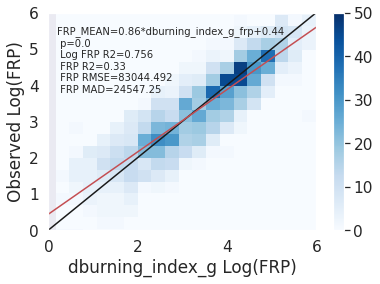

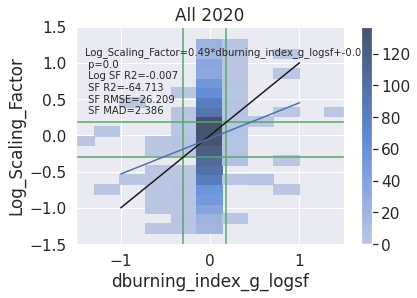

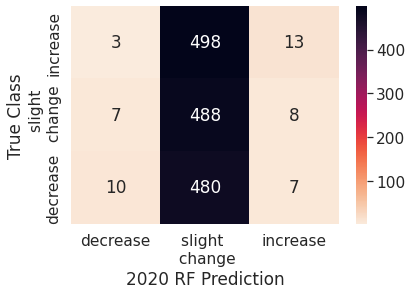

              precision    recall  f1-score   support

    decrease       0.50      0.02      0.04       497
    increase       0.46      0.03      0.05       514
   no_change       0.33      0.97      0.50       503

    accuracy                           0.34      1514
   macro avg       0.43      0.34      0.19      1514
weighted avg       0.43      0.34      0.19      1514



In [54]:
#PERSISTENCE AND SCALED METHODS

scaled_methods = ['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI','dburning_index_g'] 
scaled_methods_plot =['dhwp','dhd1w0','dIMERG.FINAL.v6_FWI','dburning_index_g']
thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 0.5

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020['persistence_cat'] = 'no_change'



#do the calculations
for ii in range(len(scaled_methods)):
    print(scaled_methods[ii])
    #make predictions for all of the holdout year (2020)
    data_test_2020[scaled_methods[ii]+'_logsf'] = np.log10(data_test_2020[scaled_methods[ii]])
    data_test_2020[scaled_methods[ii]+'_sf'] = data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_frp'] = data_test_2020['FRP_MEAN_1']*data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_logfrp'] = np.log10(data_test_2020[scaled_methods[ii]+'_frp'])
    data_test_2020[scaled_methods[ii]+'_cat'] = pd.cut(data_test_2020[scaled_methods[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
print(data_test_2020.columns.values)    
#do the plottint
#drop the nans, these will show up in the scaled methods
data_test_2020.replace([np.inf, -np.inf], np.nan, inplace=True)
print(len(data_test_2020))
data_test_2020=data_test_2020.dropna(how='any')
print(len(data_test_2020))

#persistence
frp_hist2d(data_test_2020, 'FRP_MEAN_1', 'FRP_MEAN','log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 50,'Persistence Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'Scaling_Factor_Persistence', 'Scaling_Factor',
                    'Log_Scaling_Factor_Persistence', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'persistence_cat', '2020 RF Prediction') 



for ii in range(len(scaled_methods_plot)):

    #all of 2020, trained on all features 19/21
    frp_hist2d(data_test_2020, scaled_methods_plot[ii]+'_frp', 'FRP_MEAN',scaled_methods_plot[ii]+'_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,scaled_methods_plot[ii]+' Log(FRP)')
    plot_2dhist_withfit(data_test_2020, scaled_methods_plot[ii]+'_sf', 'Scaling_Factor',scaled_methods_plot[ii]+'_logsf', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
    plot_category_heatmap(data_test_2020, 'obs_cat', scaled_methods_plot[ii]+'_cat', '2020 RF Prediction')  


In [55]:
#with open('features_drop.txt') as f:
with open('features_drop_2.txt') as f:
    data = f.read()

print("Data type before reconstruction : ", type(data))
# reconstructing the data as a dictionary
feature_subsets = json.loads(data)
  
print("Data type after reconstruction : ", type(feature_subsets))


Data type before reconstruction :  <class 'str'>
Data type after reconstruction :  <class 'dict'>


features_new_all OOB R2 score is: 0.22475578463444779


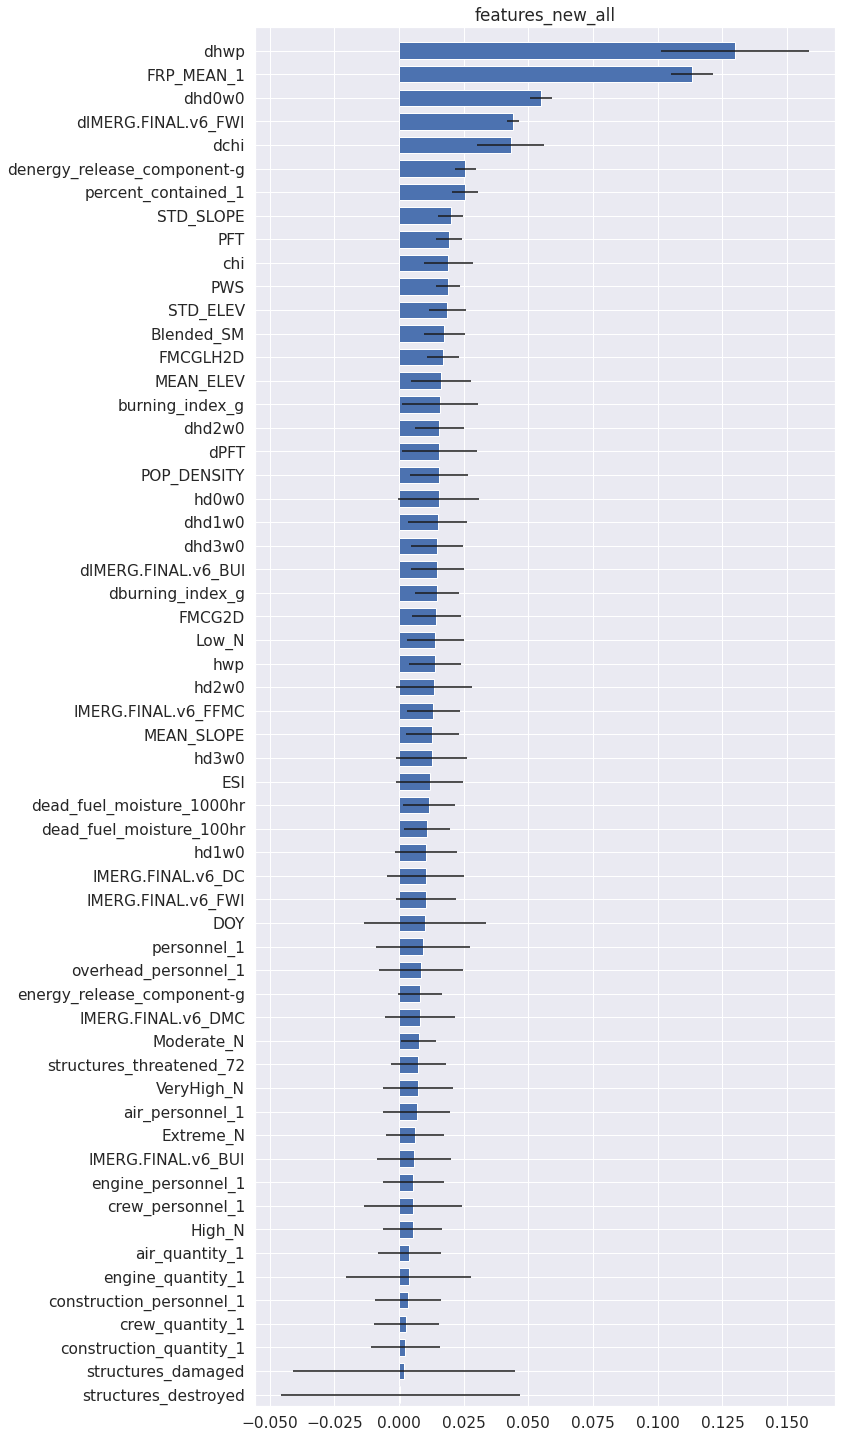

DOING PERSISTENCE


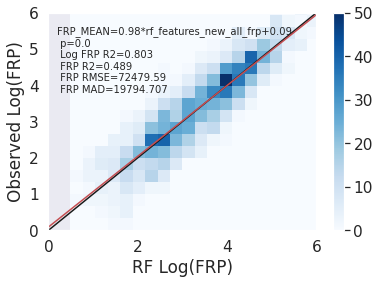

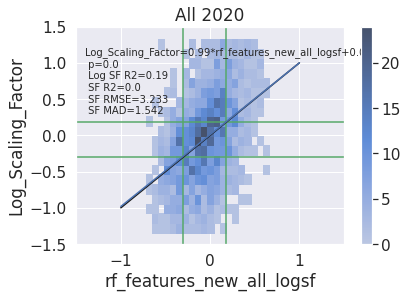

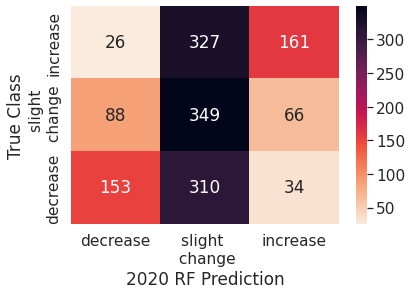

              precision    recall  f1-score   support

    decrease       0.57      0.31      0.40       497
    increase       0.62      0.31      0.42       514
   no_change       0.35      0.69      0.47       503

    accuracy                           0.44      1514
   macro avg       0.51      0.44      0.43      1514
weighted avg       0.52      0.44      0.43      1514

Fraction within a factor of two: 0.404887714663144
Fraction within a factor of two: 0.45178335535006603


In [56]:
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5

feature_set_names = ['persistence','features_new_all']
""",
                     'features_no_persistence',
                     'features_hwp', 'features_hd0w0','features_hd1w0', 'features_hd2w0', 'features_hd3w0','features_fwi', 'features_no_sfc_weather',
                     'features_pft', 'features_chi', 'features_no_stability',
                     'features_smops', 'features_cffdrs', 'features_ncar', 'features_no_moisture',
                     'features_esi','features_pws', 'features_no_ecosystem',
                     'features_no_slope',
                    'features_LowN','features_ModerateN','features_HighN','features_VeryHighN','features_ExtremeN','features_no_fuel_loading',
                    'features_no_DOY',
                     'features_no_containment',
                     'features_total_personnel','features_split_personnel','features_no_personnel',
                     'features_no_quantity',
                     'features_split_crew','features_split_engine','features_split_air',
                     'features_split_construction','features_split_overhead',
                    'features_containment_only', 'features_no_sit']"""

df_error_metrics = pd.DataFrame(index=feature_set_names, 
                                columns=['LOG_FRP_R2', 'FRP_R2', 'FRP_RMSE', 'FRP_MAD',
                                         'LOG_SF_R2', 'SF_R2', 'SF_RMSE', 'SF_MAD',
                                        'decrease_precision', 'decrease_recall', 'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])

#train the random forest
for ii in range(1,len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5) 
    gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    plot_importances(gsearch, training_variables,feature_set_names[ii])
    
    #make predictions for all of the holdout year (2020)
    data_test_2020['rf_'+feature_set_names[ii]+'_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
    data_test_2020['rf_'+feature_set_names[ii]+'_sf'] = 10**(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'])
    data_test_2020['rf_'+feature_set_names[ii]+'_frp'] = data_test_2020['FRP_MEAN_1']*data_test_2020['rf_'+feature_set_names[ii]+'_sf']
    data_test_2020['rf_'+feature_set_names[ii]+'_logfrp'] = np.log10(data_test_2020['rf_'+feature_set_names[ii]+'_frp'])
    data_test_2020['rf_'+feature_set_names[ii]+'_cat'] = pd.cut(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    

for ii in range(len(feature_set_names)):
    if feature_set_names[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors = summarize_error(data_test_2020,'FRP_MEAN', 'log_FRP_MEAN', 'FRP_MEAN_1', 'log_FRP_MEAN_1')
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'Log_Scaling_Factor', 'persistence', 'log_persistence')
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors = summarize_error(data_test_2020,'FRP_MEAN', 'log_FRP_MEAN', 'rf_'+feature_set_names[ii]+'_frp', 'rf_'+feature_set_names[ii]+'_logfrp')
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'Log_Scaling_Factor', 'rf_'+feature_set_names[ii]+'_sf', 'rf_'+feature_set_names[ii]+'_logsf')
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['rf_'+feature_set_names[ii]+'_cat'], output_dict=True))
    
    df_error_metrics.loc[feature_set_names[ii], 'LOG_FRP_R2'] = errors[0]
    df_error_metrics.loc[feature_set_names[ii], 'FRP_R2'] = errors[1]
    df_error_metrics.loc[feature_set_names[ii], 'FRP_RMSE'] = errors[2]
    df_error_metrics.loc[feature_set_names[ii], 'FRP_MAD'] = errors[3]
    
    df_error_metrics.loc[feature_set_names[ii], 'LOG_SF_R2'] = errors_sf[0]
    df_error_metrics.loc[feature_set_names[ii], 'SF_R2'] = errors_sf[1]
    df_error_metrics.loc[feature_set_names[ii], 'SF_RMSE'] = errors_sf[2]
    df_error_metrics.loc[feature_set_names[ii], 'SF_MAD'] = errors_sf[3]
    
    df_error_metrics.loc[feature_set_names[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics.loc[feature_set_names[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics.loc[feature_set_names[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics.loc[feature_set_names[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics.loc[feature_set_names[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics.loc[feature_set_names[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics.loc[feature_set_names[ii], 'accuracy'] = cr.loc['precision', 'accuracy']

#persistence

df_error_metrics['percent_change_FRP_RMSE'] = (df_error_metrics.loc['persistence','FRP_RMSE']-df_error_metrics['FRP_RMSE'])/df_error_metrics.loc['persistence','FRP_RMSE']
df_error_metrics['percent_change_FRP_MAD'] = (df_error_metrics.loc['persistence','FRP_MAD']-df_error_metrics['FRP_MAD'])/df_error_metrics.loc['persistence','FRP_MAD']


df_error_metrics['percent_change_SF_RMSE'] = (df_error_metrics.loc['persistence','SF_RMSE']-df_error_metrics['SF_RMSE'])/df_error_metrics.loc['persistence','SF_RMSE']
df_error_metrics['percent_change_SF_MAD'] = (df_error_metrics.loc['persistence','SF_MAD']-df_error_metrics['SF_MAD'])/df_error_metrics.loc['persistence','SF_MAD']


#
for ii in range(1,len(feature_set_names)):

    frp_hist2d(data_test_2020, 'rf_'+feature_set_names[ii]+'_frp', 'FRP_MEAN','rf_'+feature_set_names[ii]+'_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
    plot_2dhist_withfit(data_test_2020, 'rf_'+feature_set_names[ii]+'_sf', 'Scaling_Factor','rf_'+feature_set_names[ii]+'_logsf', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
    plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_'+feature_set_names[ii]+'_cat', '2020 RF Prediction')  


    print('Fraction within a factor of two: ' + str(len(np.where((data_test_2020['FRP_MEAN_1']<=2*data_test_2020['FRP_MEAN'])&
              (data_test_2020['FRP_MEAN_1']>=0.5*data_test_2020['FRP_MEAN']))[0])/len(data_test_2020)))
    
    print('Fraction within a factor of two: ' + str(len(np.where((data_test_2020['rf_'+feature_set_names[ii]+'_frp']<=2*data_test_2020['FRP_MEAN'])&
              (data_test_2020['rf_'+feature_set_names[ii]+'_frp']>=0.5*data_test_2020['FRP_MEAN']))[0])/len(data_test_2020)))
    
    
    

In [32]:
df_error_metrics.loc[['features_all', 
                     'features_no_persistence',
                     'features_esi','features_pws', 'features_no_ecosystem']]

,LOG_FRP_R2,FRP_R2,FRP_RMSE,FRP_MAD,LOG_SF_R2,SF_R2,SF_RMSE,SF_MAD,decrease_precision,decrease_recall,increase_precision,increase_recall,no_change_precision,no_change_recall,accuracy,percent_change_FRP_RMSE,percent_change_FRP_MAD,percent_change_SF_RMSE,percent_change_SF_MAD
features_all,0.788286,0.487015,71902.568222,19275.399404,0.174379,0.007253,3.331262,1.617,0.573333,0.330134,0.609272,0.335155,0.340862,0.656126,0.436548,0.150876,0.173707,0.055675,0.063587
features_no_persistence,0.772639,0.422576,76285.122502,20383.141093,0.113359,-0.040682,3.41074,1.659542,0.606335,0.257198,0.534413,0.240437,0.340253,0.745059,0.407995,0.099121,0.12622,0.033146,0.038951
features_esi,0.788417,0.485694,71995.111665,19234.995778,0.174889,0.005922,3.333495,1.615616,0.568562,0.326296,0.60274,0.320583,0.337056,0.656126,0.430203,0.149783,0.175439,0.055043,0.064388
features_pws,0.787476,0.50636,70533.833847,19086.705551,0.171219,0.005978,3.333401,1.618246,0.569966,0.320537,0.621053,0.322404,0.342685,0.675889,0.435279,0.16704,0.181796,0.055069,0.062865
features_no_ecosystem,0.787352,0.501895,70852.119789,19124.393403,0.170736,0.004177,3.33642,1.61784,0.57931,0.322457,0.621053,0.322404,0.346653,0.685771,0.439086,0.163281,0.18018,0.054214,0.0631


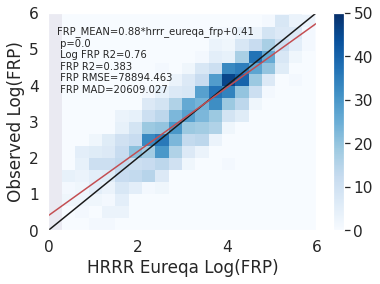

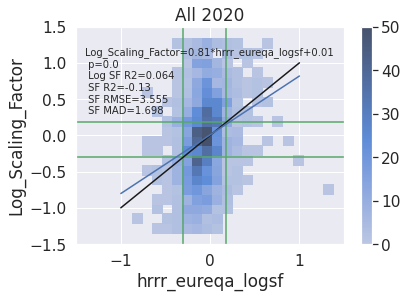

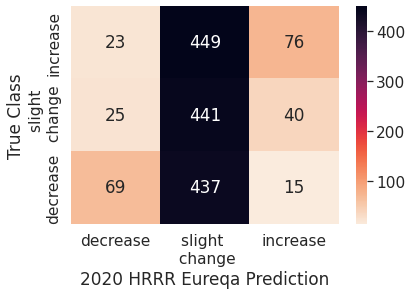

              precision    recall  f1-score   support

    decrease       0.59      0.13      0.22       521
    increase       0.58      0.14      0.22       548
   no_change       0.33      0.87      0.48       506

    accuracy                           0.37      1575
   macro avg       0.50      0.38      0.31      1575
weighted avg       0.50      0.37      0.30      1575



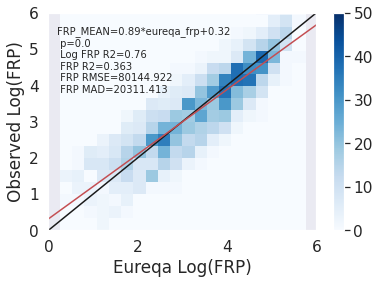

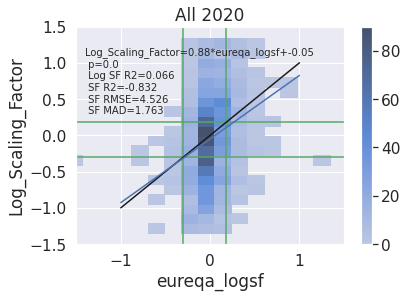

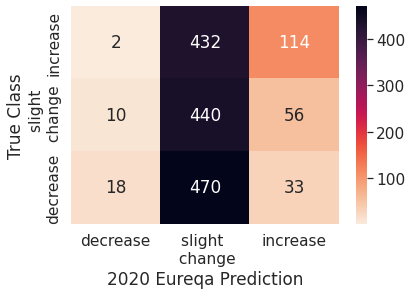

              precision    recall  f1-score   support

    decrease       0.60      0.03      0.07       521
    increase       0.56      0.21      0.30       548
   no_change       0.33      0.87      0.48       506

    accuracy                           0.36      1575
   macro avg       0.50      0.37      0.28      1575
weighted avg       0.50      0.36      0.28      1575



In [38]:
data_test_2020['hrrr_eureqa_logsf'] = (0.4239*data_test_2020['dhd0w0']) +(0.0614*data_test_2020['dhwp']) + \
                                        (0.0330*data_test_2020['chi'])- 0.5154 - (0.0025*data_test_2020['hd2w0']) - \
                                        (0.1739*data_test_2020['dhd3w0'])


data_test_2020['hrrr_eureqa_sf'] = 10**(data_test_2020['hrrr_eureqa_logsf'])
data_test_2020['hrrr_eureqa_frp'] = data_test_2020['hrrr_eureqa_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['hrrr_eureqa_logfrp'] = np.log10(data_test_2020['hrrr_eureqa_frp'])
data_test_2020['hrrr_eureqa_cat'] = pd.cut(data_test_2020['hrrr_eureqa_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020 = data_test_2020[data_test_2020['hrrr_eureqa_frp']<1e8]
frp_hist2d(data_test_2020, 'hrrr_eureqa_frp', 'FRP_MEAN','hrrr_eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,'HRRR Eureqa Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'hrrr_eureqa_sf', 'Scaling_Factor','hrrr_eureqa_logsf', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'hrrr_eureqa_cat', '2020 HRRR Eureqa Prediction')  


data_test_2020['eureqa_logsf'] = (0.40*data_test_2020['dhd0w0']) + (0.13*data_test_2020['dIMERG.FINAL.v6_FWI']) + \
                                (0.09*data_test_2020['dchi']) - 0.61 - ((6.21e-7)*data_test_2020['FRP_MEAN_1'])
"""
0.47 + ((0.42*np.log10(data_test_2020['FRP_MEAN_1']))*\
                                          (1/(1+np.exp(-(data_test_2020['dhwp']+data_test_2020['dchi'])))))-\
                                        (0.43*np.log10(data_test_2020['FRP_MEAN_1']))"""
data_test_2020['eureqa_sf'] = 10**(data_test_2020['eureqa_logsf'])
data_test_2020['eureqa_frp'] = data_test_2020['eureqa_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['eureqa_logfrp'] = np.log10(data_test_2020['eureqa_frp'])
data_test_2020['eureqa_cat'] = pd.cut(data_test_2020['eureqa_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
frp_hist2d(data_test_2020, 'eureqa_frp', 'FRP_MEAN','eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,'Eureqa Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'eureqa_sf', 'Scaling_Factor','eureqa_logsf', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'eureqa_cat', '2020 Eureqa Prediction')  



In [40]:
print(df_error_metrics['FRP_RMSE'].min())
print(np.min(df_error_metrics[['percent_change_FRP_RMSE', 'percent_change_FRP_MAD']].min().values))

70533.83384659144
0.0


In [41]:
def plot_frp_sensitivity_metrics(df_metrics, vars_plot):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    fig, ax = plt.subplots(figsize=(9,13))

    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))


    p1=ax.scatter(df_error_metrics_plot['percent_change_FRP_RMSE'],df_error_metrics_plot.index,c='orange',s=75, label='% decrease in RMSE')
    p2=ax.scatter(df_error_metrics_plot['percent_change_FRP_MAD'],df_error_metrics_plot.index,c='g',s=75,label='% decrease in MAD')
    p3=twin1.scatter(df_error_metrics_plot['FRP_R2'],df_error_metrics_plot.index, c='b',s=75,label='FRP R2')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc['features_all', 'percent_change_FRP_RMSE'],c='orange', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc['features_all', 'percent_change_FRP_MAD'],c='g', linestyle='--')
    twin1.axvline(x=df_error_metrics_plot.loc['features_all', 'FRP_R2'],c='b', linestyle='--')

    #set properties of the x labels
    twin1.set_xlim([df_error_metrics['FRP_R2'].min(),df_error_metrics['FRP_R2'].max()])
    ax.set_xlim([0.05, #np.min(df_error_metrics[['percent_change_FRP_RMSE', 'percent_change_FRP_MAD']].min().values),
                 np.max(df_error_metrics[['percent_change_FRP_RMSE', 'percent_change_FRP_MAD']].max().values)+.01])
    ax.set_xlabel("% decrease")
    ax.set_ylabel("Feature Configuration")
    twin1.set_xlabel("R2")


    twin1.xaxis.label.set_color('b')

    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', colors='b', **tkw)

    ax.legend(handles=[p1, p2, p3], bbox_to_anchor=(1,1) )

    plt.show()
    
def plot_sf_sensitivity_metrics(df_metrics, vars_plot):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    fig, ax = plt.subplots(figsize=(9,13))

    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))


    p1=ax.scatter(df_error_metrics_plot['percent_change_SF_RMSE'],df_error_metrics_plot.index,c='orange',s=75, label='% decrease in RMSE')
    p2=ax.scatter(df_error_metrics_plot['percent_change_SF_MAD'],df_error_metrics_plot.index,c='g',s=75,label='% decrease in MAD')
    p3=twin1.scatter(df_error_metrics_plot['SF_R2'],df_error_metrics_plot.index, c='b',s=75,label='FRP R2')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc['features_all', 'percent_change_SF_RMSE'],c='orange', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc['features_all', 'percent_change_SF_MAD'],c='g', linestyle='--')
    twin1.axvline(x=df_error_metrics_plot.loc['features_all', 'SF_R2'],c='b', linestyle='--')

    #set properties of the x labels
    twin1.set_xlim([df_error_metrics['SF_R2'].min(),df_error_metrics['SF_R2'].max()])
    ax.set_xlim([np.min(df_error_metrics[['percent_change_SF_RMSE', 'percent_change_SF_MAD']].min().values),
                 np.max(df_error_metrics[['percent_change_SF_RMSE', 'percent_change_SF_MAD']].max().values)+.01])
    ax.set_xlabel("% decrease")
    ax.set_ylabel("Feature Configuration")
    twin1.set_xlabel("R2")


    twin1.xaxis.label.set_color('b')

    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', colors='b', **tkw)

    ax.legend(handles=[p1, p2, p3], bbox_to_anchor=(1,1) )

    plt.show()

def plot_recall_sensitivity_metrics(df_metrics, vars_plot):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    fig, ax = plt.subplots(figsize=(9,13))
    
    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))


    p1=ax.scatter(df_error_metrics_plot['increase_recall'],df_error_metrics_plot.index,c='r',s=75, label='increases')
    p2=ax.scatter(df_error_metrics_plot['decrease_recall'],df_error_metrics_plot.index,c='c',s=75,label='decreases')
    p3=twin1.scatter(df_error_metrics_plot['no_change_recall'],df_error_metrics_plot.index, c='tan',s=75,label='slight change')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc['features_all', 'increase_recall'],c='r', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc['features_all', 'decrease_recall'],c='c', linestyle='--')
    twin1.axvline(x=df_error_metrics_plot.loc['features_all', 'no_change_recall'],c='tan', linestyle='--')

    twin1.set_xlim([df_error_metrics['no_change_recall'].min(),df_error_metrics['no_change_recall'].max()])
    ax.set_xlim([0.05, #np.min(df_error_metrics[['percent_change_FRP_RMSE', 'percent_change_FRP_MAD']].min().values),
                 np.max(df_error_metrics[['increase_recall', 'decrease_recall']].max().values)+.01])
    ax.set_xlabel("Percent of observations recalled")
    ax.set_ylabel("Feature Configuration")
    twin1.set_xlabel("Percent of slight changes recalled")

    
    twin1.xaxis.label.set_color('tan')


    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', colors='tan', **tkw)

    ax.legend(handles=[p1, p2, p3], bbox_to_anchor=(1,1) )

    plt.show()
    
def plot_precision_sensitivity_metrics(df_metrics, vars_plot):
    
    df_error_metrics_plot = df_metrics.loc[vars_plot]
    fig, ax = plt.subplots(figsize=(9,13))
    
    twin1 = ax.twiny()


    # Offset the top spine of twin2.  The ticks and label have already been
    # placed above by twinx above.
    ax.spines['bottom'].set_position(("axes", -0.05))


    p1=ax.scatter(df_error_metrics_plot['increase_precision'],df_error_metrics_plot.index,c='r',s=75, label='increases')
    p2=ax.scatter(df_error_metrics_plot['decrease_precision'],df_error_metrics_plot.index,c='c',s=75,label='decreases')
    p3=twin1.scatter(df_error_metrics_plot['no_change_precision'],df_error_metrics_plot.index, c='tan',s=75,label='slight change')

    #plot the vertical lines
    ax.axvline(x=df_error_metrics_plot.loc['features_all', 'increase_precision'],c='r', linestyle='--')
    ax.axvline(x=df_error_metrics_plot.loc['features_all', 'decrease_precision'],c='c', linestyle='--')
    twin1.axvline(x=df_error_metrics_plot.loc['features_all', 'no_change_precision'],c='tan', linestyle='--')

    twin1.set_xlim([df_error_metrics['no_change_precision'].min(),df_error_metrics['no_change_precision'].max()])
    ax.set_xlim([0.05, #np.min(df_error_metrics[['percent_change_FRP_RMSE', 'percent_change_FRP_MAD']].min().values),
                 np.max(df_error_metrics[['increase_precision', 'decrease_precision']].max().values)+.01])
    ax.set_xlabel("Precision of modeled categories")
    ax.set_ylabel("Feature Configuration")


    tkw = dict(size=4, width=1.5, grid_alpha=0)
    ax.tick_params(axis='x', **tkw)
    twin1.tick_params(axis='x', colors='tan', **tkw)

    ax.legend(handles=[p1, p2,p3], bbox_to_anchor=(1,1) )

    plt.show()


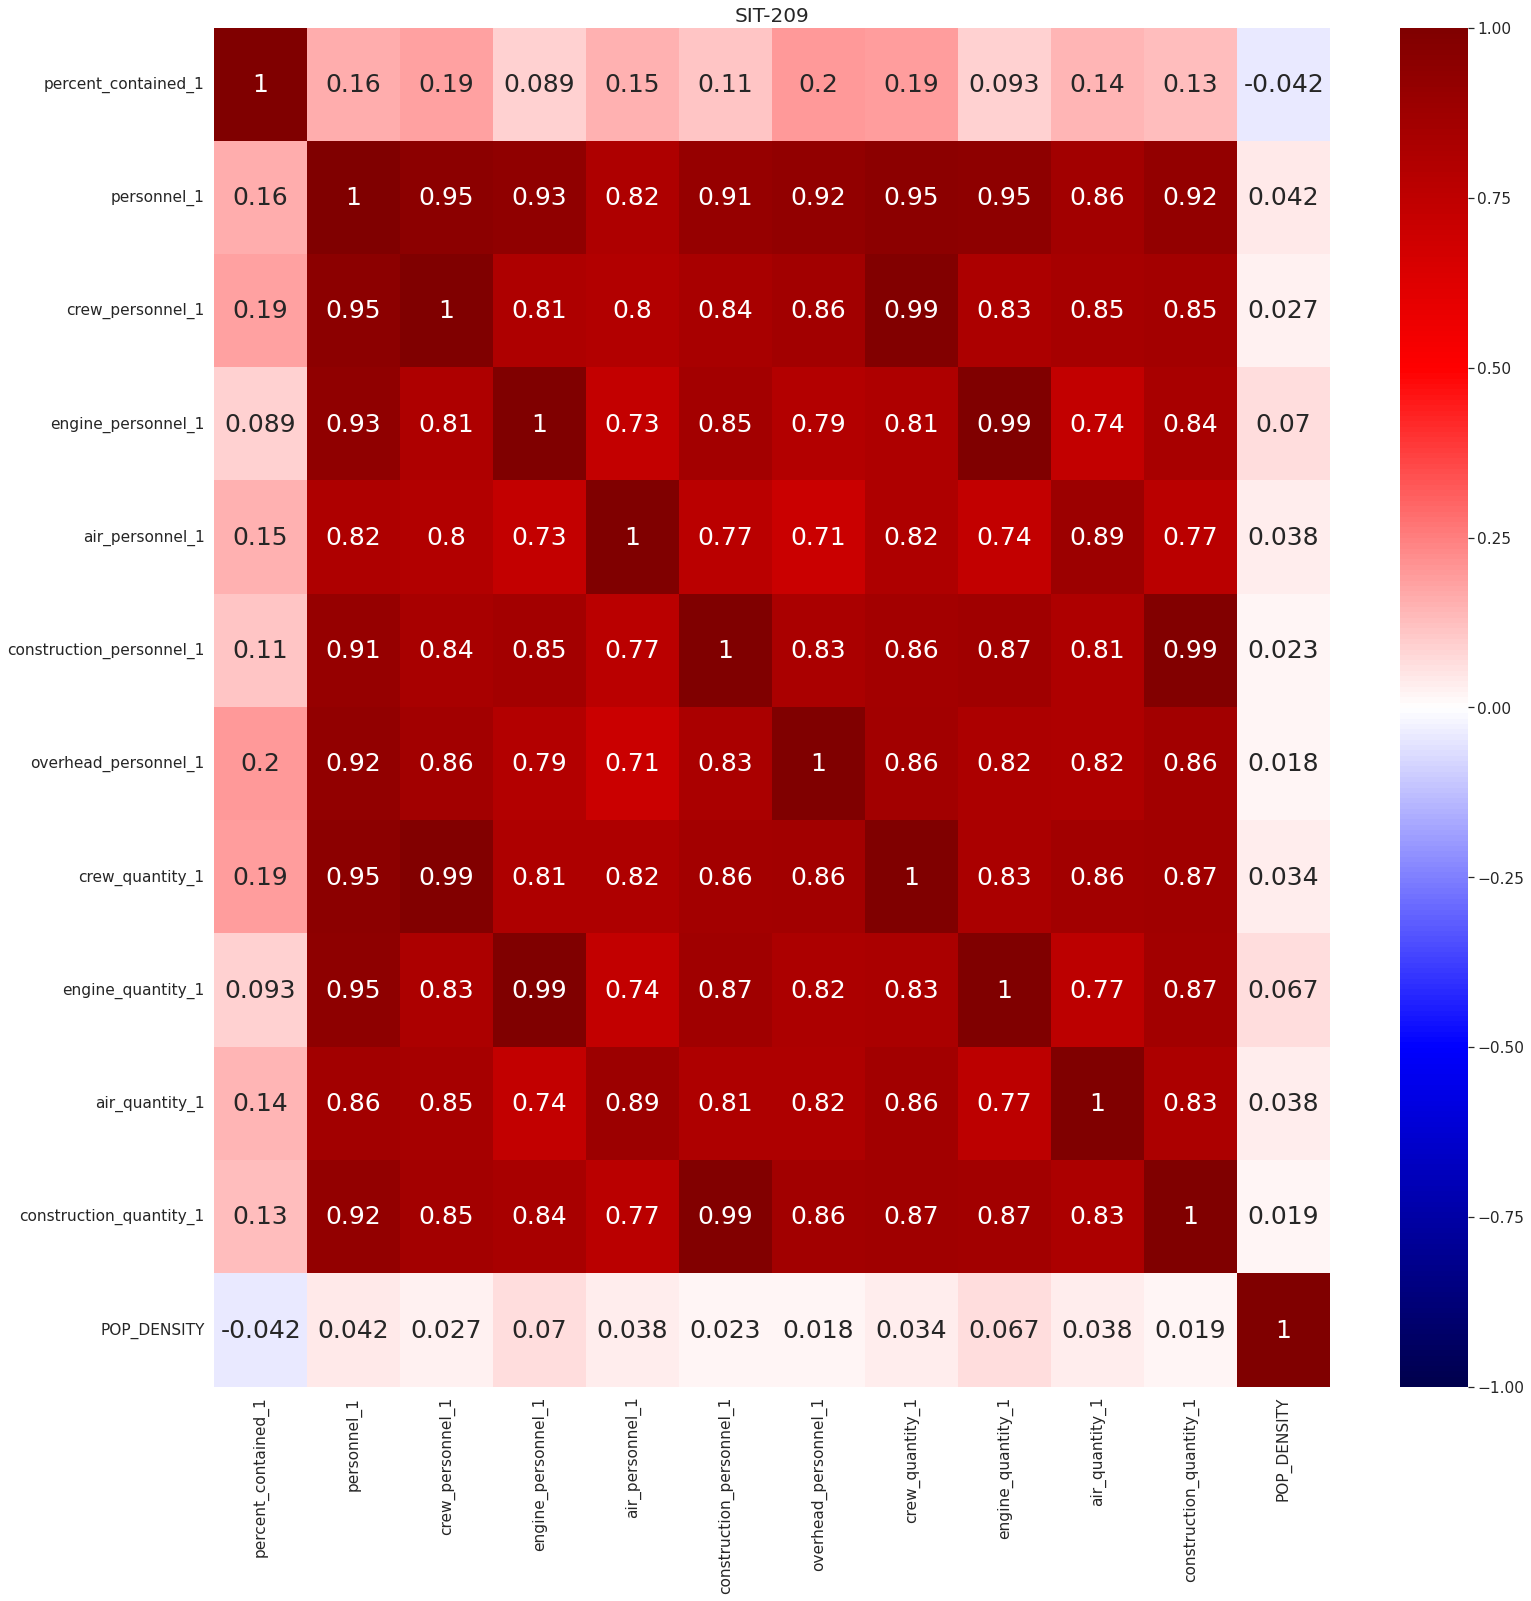

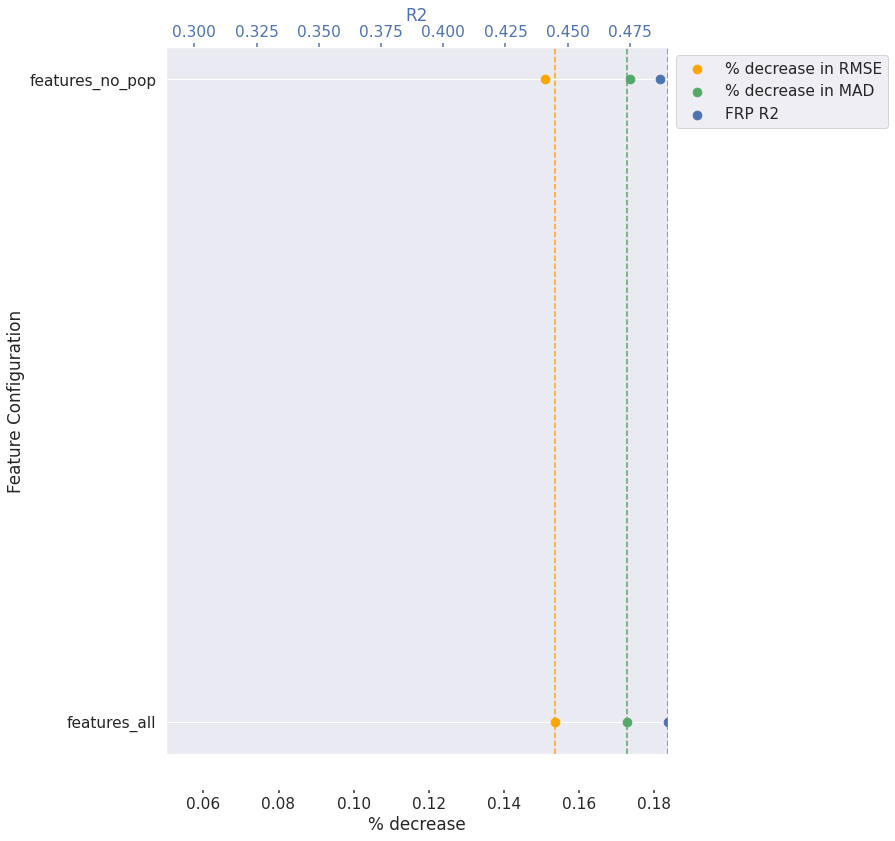

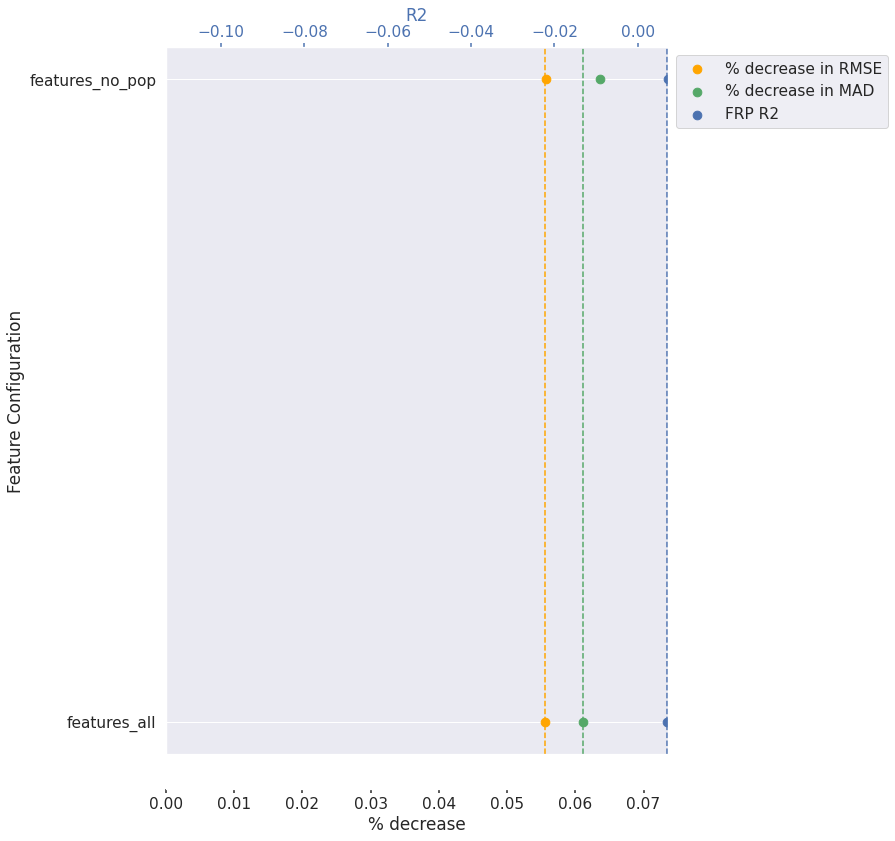

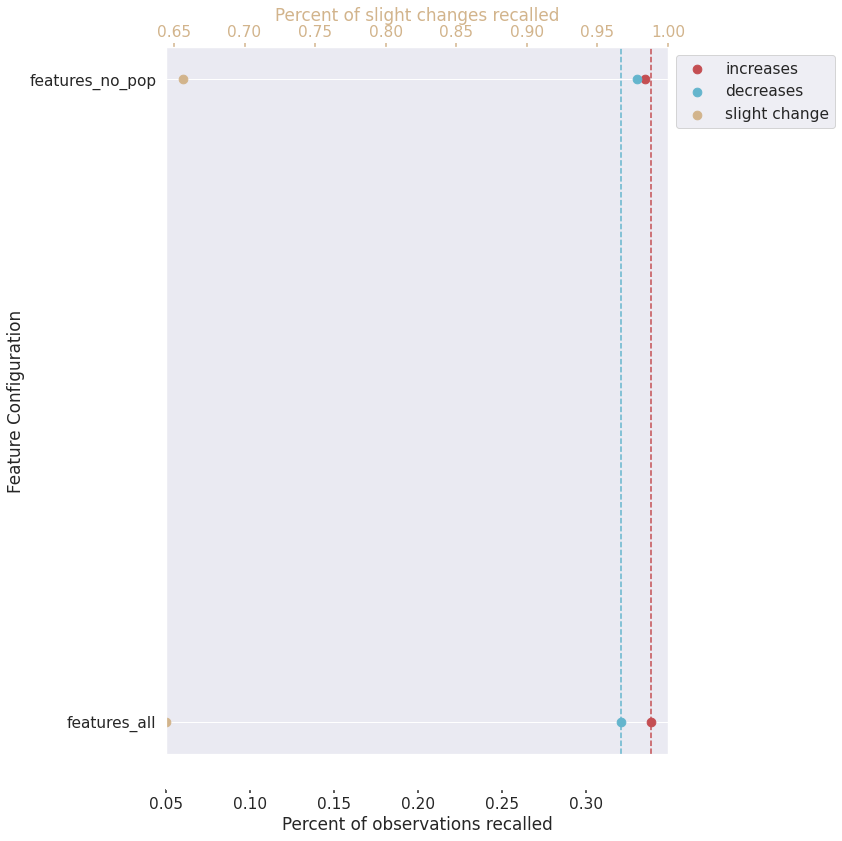

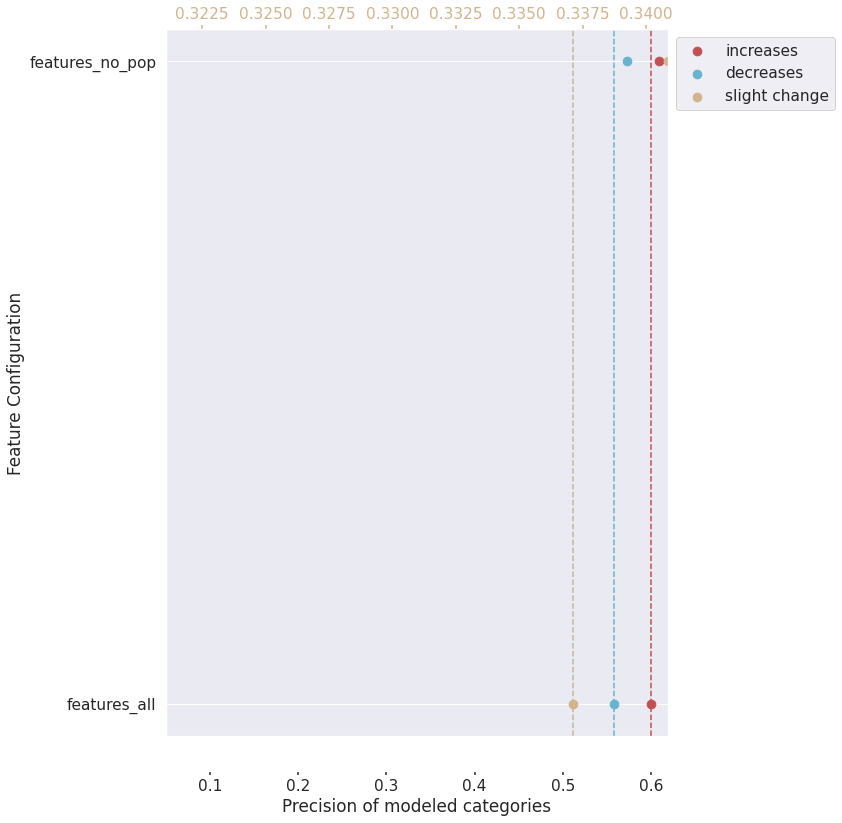

In [44]:
#just dropping features
"""weather_drop = ['features_all', 'features_no_persistence',
                        'features_hwp', 'features_hd0w0','features_hd1w0', 
                        'features_hd2w0', 'features_hd3w0','features_fwi', 
                        'features_no_sfc_weather']

plot_frp_sensitivity_metrics(df_error_metrics, weather_drop)
plot_sf_sensitivity_metrics(df_error_metrics, weather_drop)
plot_recall_sensitivity_metrics(df_error_metrics, weather_drop)
plot_precision_sensitivity_metrics(df_error_metrics, weather_drop)

stability_drop = ['features_all','features_pft', 'features_chi', 'features_no_stability']
plot_frp_sensitivity_metrics(df_error_metrics, stability_drop)
plot_sf_sensitivity_metrics(df_error_metrics, stability_drop)
plot_recall_sensitivity_metrics(df_error_metrics, stability_drop)
plot_precision_sensitivity_metrics(df_error_metrics, stability_drop)

moisture_drop = ['features_all','features_smops', 'features_cffdrs', 'features_ncar','features_no_moisture']
plot_frp_sensitivity_metrics(df_error_metrics, moisture_drop)
plot_sf_sensitivity_metrics(df_error_metrics, moisture_drop)
plot_recall_sensitivity_metrics(df_error_metrics, moisture_drop)
plot_precision_sensitivity_metrics(df_error_metrics, moisture_drop)"""

"""ecosystem_drop = ['features_all','features_pws', 'features_esi', 'features_no_ecosystem']
plot_frp_sensitivity_metrics(df_error_metrics, ecosystem_drop)
plot_sf_sensitivity_metrics(df_error_metrics, ecosystem_drop)
plot_recall_sensitivity_metrics(df_error_metrics, ecosystem_drop)
plot_precision_sensitivity_metrics(df_error_metrics, ecosystem_drop)

slope_drop = ['features_all','features_no_slope']
plot_frp_sensitivity_metrics(df_error_metrics, slope_drop)
plot_sf_sensitivity_metrics(df_error_metrics, slope_drop)
plot_recall_sensitivity_metrics(df_error_metrics, slope_drop)
plot_precision_sensitivity_metrics(df_error_metrics, slope_drop)

doy_drop = ['features_all','features_no_DOY']
plot_frp_sensitivity_metrics(df_error_metrics, doy_drop)
plot_sf_sensitivity_metrics(df_error_metrics, doy_drop)
plot_recall_sensitivity_metrics(df_error_metrics, doy_drop)
plot_precision_sensitivity_metrics(df_error_metrics, doy_drop)

fuels_drop= ['features_all','features_LowN', 'features_ModerateN', 'features_HighN', 'features_VeryHighN', 'features_ExtremeN', 
            'features_no_fuel_loading']
plot_frp_sensitivity_metrics(df_error_metrics, fuels_drop)
plot_sf_sensitivity_metrics(df_error_metrics, fuels_drop)
plot_recall_sensitivity_metrics(df_error_metrics, fuels_drop)
plot_precision_sensitivity_metrics(df_error_metrics, fuels_drop)


whole_category_drop = ['features_all', 'features_no_persistence',
                                                               'features_no_sfc_weather','features_no_stability',
                                                               'features_no_moisture', 'features_no_ecosystem',
                                                               'features_no_slope','features_no_DOY',
                                                               'features_no_fuel_loading','features_no_sit']
plot_frp_sensitivity_metrics(df_error_metrics, whole_category_drop)
plot_recall_sensitivity_metrics(df_error_metrics, whole_category_drop)
plot_precision_sensitivity_metrics(df_error_metrics, whole_category_drop)
"""


plot_correlations(data_test_2020[["percent_contained_1", "personnel_1",
                  "crew_personnel_1","engine_personnel_1","air_personnel_1",
                "construction_personnel_1","overhead_personnel_1",
                  "crew_quantity_1", "engine_quantity_1",  "air_quantity_1", 
                                 "construction_quantity_1", "POP_DENSITY"]], 'SIT-209','pearson', 25)

"""sit209_drop = ['features_all','features_no_containment', 'features_no_personnel', 'features_no_quantity',
                               'features_split_personnel', 'features_total_personnel', 

               'features_split_crew',  'features_split_engine', 'features_split_air', 
                'features_split_construction', 'features_split_overhead',
                'features_no_sit']
plot_frp_sensitivity_metrics(df_error_metrics, sit209_drop)
plot_sf_sensitivity_metrics(df_error_metrics, sit209_drop)
plot_recall_sensitivity_metrics(df_error_metrics, sit209_drop)
plot_precision_sensitivity_metrics(df_error_metrics, sit209_drop)"""

"""
plot_frp_sensitivity_metrics(df_error_metrics, ['features_all','features_no_containment'])

#personnel and quantity are dropped independently
error_metrics_personnel = df_error_metrics.loc[['features_all',
                                                'features_split_personnel', 'features_total_personnel', 
                                                'features_no_personnel']]
error_metrics_quantity = df_error_metrics.loc[['features_all', 'features_no_quantity']]

error_metrics_sit_sensitivity = df_error_metrics.loc[['features_all','features_containment_only', 'features_split_crew', 
                                                'features_split_engine', 'features_split_air', 
                                                'features_split_construction', 'features_split_overhead']]"""

pop_drop = ['features_all', 'features_no_pop']
plot_frp_sensitivity_metrics(df_error_metrics, pop_drop)
plot_sf_sensitivity_metrics(df_error_metrics, pop_drop)
plot_recall_sensitivity_metrics(df_error_metrics, pop_drop)
plot_precision_sensitivity_metrics(df_error_metrics, pop_drop)


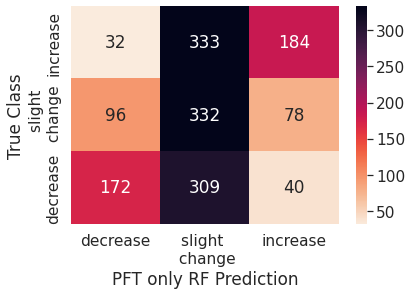

              precision    recall  f1-score   support

    decrease       0.57      0.33      0.42       521
    increase       0.61      0.34      0.43       549
   no_change       0.34      0.66      0.45       506

    accuracy                           0.44      1576
   macro avg       0.51      0.44      0.43      1576
weighted avg       0.51      0.44      0.43      1576



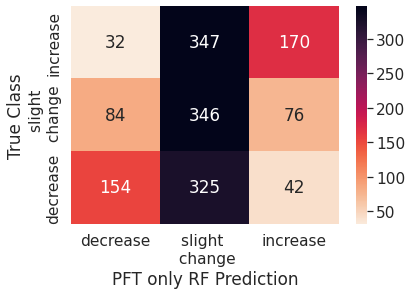

              precision    recall  f1-score   support

    decrease       0.57      0.30      0.39       521
    increase       0.59      0.31      0.41       549
   no_change       0.34      0.68      0.45       506

    accuracy                           0.43      1576
   macro avg       0.50      0.43      0.42      1576
weighted avg       0.50      0.43      0.42      1576



In [133]:
#frp_hist2d(data_test_2020, 'rf_features_pft_frp', 'FRP_MEAN','rf_features_pft_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,'HRRR Eureqa Log(FRP)')
plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_features_all_cat', 'PFT only RF Prediction') 

#plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_features_pft_cat', 'PFT only RF Prediction') 
#plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_features_chi_cat', 'PFT only RF Prediction') 

#plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_features_ncar_cat', 'PFT only RF Prediction') 
#plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_features_cffdrs_cat', 'PFT only RF Prediction') 

plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_features_no_containment_cat', 'PFT only RF Prediction') 


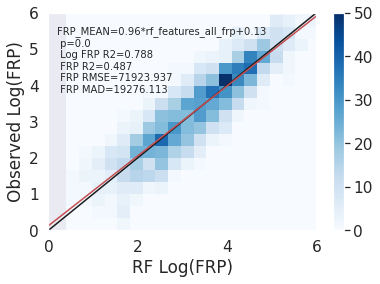

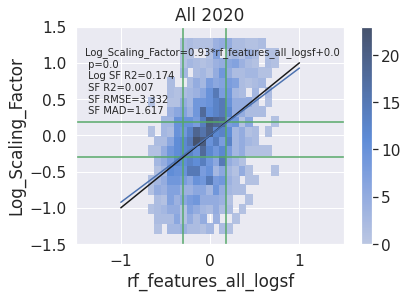

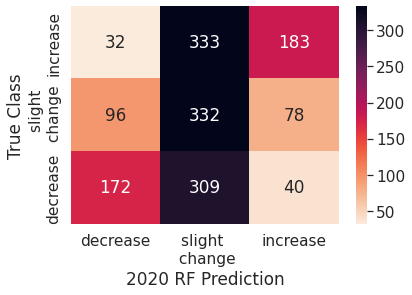

              precision    recall  f1-score   support

    decrease       0.57      0.33      0.42       521
    increase       0.61      0.33      0.43       548
   no_change       0.34      0.66      0.45       506

    accuracy                           0.44      1575
   macro avg       0.51      0.44      0.43      1575
weighted avg       0.51      0.44      0.43      1575



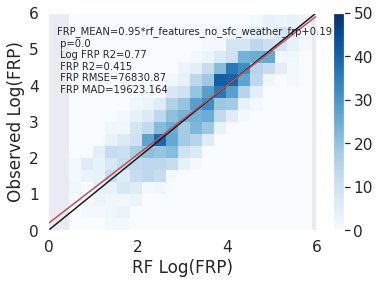

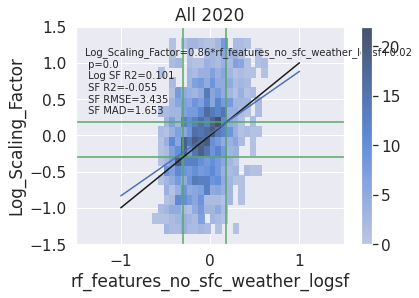

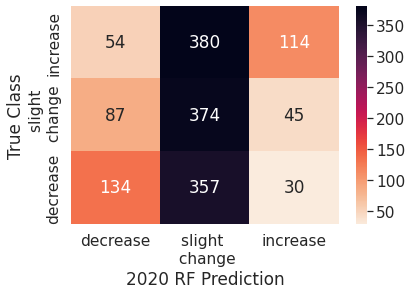

              precision    recall  f1-score   support

    decrease       0.49      0.26      0.34       521
    increase       0.60      0.21      0.31       548
   no_change       0.34      0.74      0.46       506

    accuracy                           0.39      1575
   macro avg       0.48      0.40      0.37      1575
weighted avg       0.48      0.39      0.37      1575



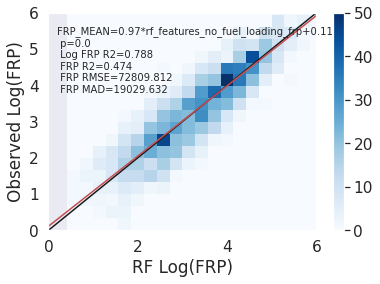

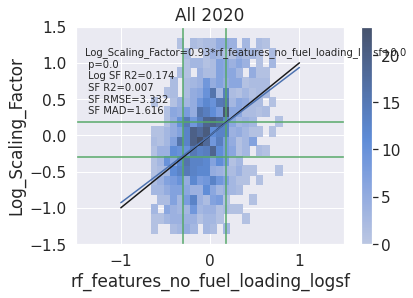

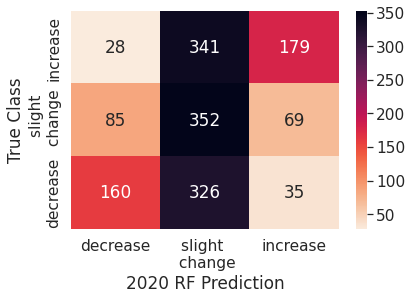

              precision    recall  f1-score   support

    decrease       0.59      0.31      0.40       521
    increase       0.63      0.33      0.43       548
   no_change       0.35      0.70      0.46       506

    accuracy                           0.44      1575
   macro avg       0.52      0.44      0.43      1575
weighted avg       0.52      0.44      0.43      1575



In [63]:
feature_set_names = ['features_all', 'features_no_sfc_weather', 'features_no_fuel_loading']
for ii in range(len(feature_set_names)):

    frp_hist2d(data_test_2020, 'rf_'+feature_set_names[ii]+'_frp', 'FRP_MEAN','rf_'+feature_set_names[ii]+'_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
    plot_2dhist_withfit(data_test_2020, 'rf_'+feature_set_names[ii]+'_sf', 'Scaling_Factor','rf_'+feature_set_names[ii]+'_logsf', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
    plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_'+feature_set_names[ii]+'_cat', '2020 RF Prediction')  



In [ ]:
fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines['right'].set_position(("axes", 1.2))

p1, = ax.plot([0, 1, 2], [0, 1, 2], "b-", label="Density")
p2, = twin1.plot([0, 1, 2], [0, 3, 2], "r-", label="Temperature")
p3, = twin2.plot([0, 1, 2], [50, 30, 15], "g-", label="Velocity")
ax.grid('False')
twin1.grid('False')
twin2.grid('False')

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
twin1.set_ylim(0, 4)
twin2.set_ylim(1, 65)

ax.set_xlabel("Distance")
ax.set_ylabel("Density")
twin1.set_ylabel("Temperature")
twin2.set_ylabel("Velocity")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3])

plt.show()


In [ ]:
plt.figure(figsize=(9,13))
plt.scatter(df_error_metrics['decrease_recall'],df_error_metrics.index, label='Recall of Decreases')
plt.scatter(df_error_metrics['increase_recall'],df_error_metrics.index, label='Recall of Increases')
plt.scatter(df_error_metrics['no_change_recall'],df_error_metrics.index, label='Recall of Slight Changes')
plt.scatter(df_error_metrics['accuracy'],df_error_metrics.index, label='Category Accuracy')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [ ]:


plt.figure(figsize=(9,13))
plt.scatter(df_error_metrics['FRP_R2'],df_error_metrics.index, label='FRP R2', c='k',marker='*')
plt.scatter(df_error_metrics['percent_change_FRP_RMSE'],df_error_metrics.index, label='% decrease FRP RMSE \n wrt Persistence', c='m',marker='*')
plt.scatter(df_error_metrics['percent_change_FRP_MAD'],df_error_metrics.index, label='% decrease FRP MAD \n wrt Persistence', c='g',marker='*')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

plt.figure(figsize=(9,13))
plt.scatter(df_error_metrics['SF_R2'],df_error_metrics.index, label='SF R2', c='k',marker='*')
plt.scatter(df_error_metrics['percent_change_SF_RMSE'],df_error_metrics.index, label='% decrease SF RMSE \n wrt Persistence', c='m',marker='*')
plt.scatter(df_error_metrics['percent_change_SF_MAD'],df_error_metrics.index, label='% decrease SF MAD \n wrt Persistence', c='g',marker='*')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Systematically drop features (7/10/23)

In [ ]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

#do the train-test split
#test fires
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test), np.unique(data_test['year']))

#2020 all fires, including August Complex
data_test_2020 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']>=np.datetime64('2020-01-01 00:00:00'))&
                                              (features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00'))] #time range
print(len(data_test_2020), np.unique(data_test_2020['year'])) #includes august complex

#2019/2021 Training Set
data_train_1921 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2020-01-01 00:00:00'))|
                                              (features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00'))]
print(len(data_train_1921), np.unique(data_train_1921['year']))
data_train_1921 = data_train_1921.iloc[np.where(~data_train_1921.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_1921), np.unique(data_train_1921['year']))

In [ ]:
scaled_methods = ['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI'] #these are already scaling factors
#scaled_methods = [ 'dIMERG.FINAL.v6_FWI'] #these are already scaling factors

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 0.5

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020['persistence_cat'] = 'no_change'



#do the calculations
for ii in range(len(scaled_methods)):
    
    #make predictions for all of the holdout year (2020)
    data_test_2020[scaled_methods[ii]+'_logsf'] = np.log10(data_test_2020[scaled_methods[ii]])
    data_test_2020[scaled_methods[ii]+'_sf'] = data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_frp'] = data_test_2020['FRP_MEAN_1']*data_test_2020[scaled_methods[ii]]
    data_test_2020[scaled_methods[ii]+'_logfrp'] = np.log10(data_test_2020[scaled_methods[ii]+'_frp'])
    data_test_2020[scaled_methods[ii]+'_cat'] = pd.cut(data_test_2020[scaled_methods[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    
#do the plottint
#drop the nans, these will show up in the scaled methods
data_test_2020.replace([np.inf, -np.inf], np.nan, inplace=True)
print(len(data_test_2020))
data_test_2020=data_test_2020.dropna(how='any')
print(len(data_test_2020))

#persistence
frp_hist2d(data_test_2020, 'FRP_MEAN_1', 'FRP_MEAN','log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'Scaling_Factor_Persistence', 'Scaling_Factor',
                    'Log_Scaling_Factor_Persistence', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'persistence_cat', '2020 RF Prediction') 



for ii in range(len(scaled_methods)):

    #all of 2020, trained on all features 19/21
    frp_hist2d(data_test_2020, scaled_methods[ii]+'_frp', 'FRP_MEAN',scaled_methods[ii]+'_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
    plot_2dhist_withfit(data_test_2020, scaled_methods[ii]+'_sf', 'Scaling_Factor',scaled_methods[ii]+'_logsf', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
    plot_category_heatmap(data_test_2020, 'obs_cat', scaled_methods[ii]+'_cat', '2020 RF Prediction')  


In [ ]:
"""FULL DATASET, PLUS PERSONNEL, REFERENCE"""
feature_subsets={'features_all':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                 
                'features_hwp':['dhwp',
                    'hwp',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_hd0w0':['dhd0w0',
                    'hd0w0',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_fwi':['dIMERG.FINAL.v6_FWI',
                    'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                 
                 'features_no_sfc_weather':['PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_pft':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_chi':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'chi', 'dchi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                 
                 'features_no_stability':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_smops':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_cffdrs':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_ncar':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                 
                 'features_no_moisture':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_no_slope':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                 
                'features_Low_N':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                 
                  'features_Moderate_N':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Moderate_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                 
                  'features_High_N':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'High_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                 
                  'features_VeryHigh_N':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'VeryHigh_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                 
                 'features_Extreme_N':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                 
                 'features_no_fuel_loading':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                 
                'features_esi':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_pws':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_no_ecosystem':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_no_persistence':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1'
                   ],
                 
                'features_no_containment':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                 
                 'features_split_personnel':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_total_personnel':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_no_personnel':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_containment_only':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1',
                    'FRP_MEAN_1'],
                 
                'features_split_no_quantity':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'FRP_MEAN_1'],
                
                'features_split_crew':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1',
                    'crew_personnel_1',
                    'crew_quantity_1', 
                    'FRP_MEAN_1'],
                
                'features_split_engine':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1',
                    'engine_personnel_1',
                    'engine_quantity_1', 
                    'FRP_MEAN_1'],
                
                'features_split_air':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1',
                   'air_personnel_1',
                    'air_quantity_1', 
                    'FRP_MEAN_1'],
                
                'features_split_construction':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1',
                    'construction_personnel_1',
                    'construction_quantity_1',
                    'FRP_MEAN_1'],
                
                'features_split_overhead':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1','overhead_personnel_1',
                    'FRP_MEAN_1'],}
                 
"""                 

'features_no_containment':['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1'],"""
                 



In [ ]:
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5

feature_set_names = ['features_all', 
                     'features_no_containment', 'features_split_personnel', 'features_total_personnel', 'features_no_personnel',
                    'features_containment_only', 'features_split_no_quantity',
                    'features_split_crew', 'features_split_engine','features_split_air','features_split_construction', 'features_split_overhead']

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020['persistence_cat'] = 'no_change'


for ii in range(len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5) 
    gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    
    #make predictions for all of the holdout year (2020)
    data_test_2020['rf_'+feature_set_names[ii]+'_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
    data_test_2020['rf_'+feature_set_names[ii]+'_sf'] = 10**(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'])
    data_test_2020['rf_'+feature_set_names[ii]+'_frp'] = data_test_2020['FRP_MEAN_1']*data_test_2020['rf_'+feature_set_names[ii]+'_sf']
    data_test_2020['rf_'+feature_set_names[ii]+'_logfrp'] = np.log10(data_test_2020['rf_'+feature_set_names[ii]+'_frp'])
    data_test_2020['rf_'+feature_set_names[ii]+'_cat'] = pd.cut(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    
    #all of 2020, trained on all features 19/21
    frp_hist2d(data_test_2020, 'rf_'+feature_set_names[ii]+'_frp', 'FRP_MEAN','rf_'+feature_set_names[ii]+'_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
    plot_2dhist_withfit(data_test_2020, 'rf_'+feature_set_names[ii]+'_sf', 'Scaling_Factor','rf_'+feature_set_names[ii]+'_logsf', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
    plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_'+feature_set_names[ii]+'_cat', '2020 RF Prediction')  


    
#persistence
frp_hist2d(data_test_2020, 'FRP_MEAN_1', 'FRP_MEAN','log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'Scaling_Factor_Persistence', 'Scaling_Factor',
                    'Log_Scaling_Factor_Persistence', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'persistence_cat', '2020 RF Prediction') 

plot_importances(gsearch, training_variables, 'logSF Model')




"""#data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
data_test_2020.replace([np.inf, -np.inf], np.nan, inplace=True)

#data_test=data_test.dropna(how='any')
data_test_2020=data_test_2020.dropna(how='any')"""


In [ ]:
print(data_test_2020.columns.values)

In [ ]:
print(data_test_2020['log_persistence'])

In [ ]:
# we shouldn't have to drop nans for the RF, as long as we run it AFTER the scaled method cells

thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5

feature_set_names = ['persistence','features_all', 
                      'features_no_persistence',
                     'features_hwp', 'features_hd0w0','features_fwi', 'features_no_sfc_weather',
                     'features_pft', 'features_chi', 'features_no_stability',
                    'features_smops', 'features_ncar', 'features_cffdrs', 'features_no_moisture',
                    'features_no_slope', 
                     'features_Low_N','features_Moderate_N', 'features_High_N', 'features_VeryHigh_N','features_Extreme_N','features_no_fuel_loading',
                    'features_esi', 'features_pws', 'features_no_ecosystem',
                     'features_no_containment', 'features_split_personnel', 'features_total_personnel', 'features_no_personnel',
                    'features_containment_only', 'features_split_no_quantity',
                  'features_split_crew', 'features_split_engine','features_split_air','features_split_construction', 'features_split_overhead']

df_error_metrics = pd.DataFrame(index=feature_set_names, 
                                columns=['LOG_FRP_R2', 'FRP_R2', 'FRP_RMSE', 'FRP_MAD',
                                         'LOG_SF_R2', 'SF_R2', 'SF_RMSE', 'SF_MAD',
                                        'decrease_precision', 'decrease_recall', 'increase_precision', 'increase_recall',
                                        'no_change_precision', 'no_change_recall', 'accuracy'])

for ii in range(len(feature_set_names)):
    if feature_set_names[ii] =='persistence':
        print('DOING PERSISTENCE')
        errors = summarize_error(data_test_2020,'FRP_MEAN', 'log_FRP_MEAN', 'FRP_MEAN_1', 'log_FRP_MEAN_1')
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'Log_Scaling_Factor', 'persistence', 'log_persistence')
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['persistence_cat'], output_dict=True))
    else:
        errors = summarize_error(data_test_2020,'FRP_MEAN', 'log_FRP_MEAN', 'rf_'+feature_set_names[ii]+'_frp', 'rf_'+feature_set_names[ii]+'_logfrp')
        errors_sf = summarize_error(data_test_2020,'Scaling_Factor', 'Log_Scaling_Factor', 'rf_'+feature_set_names[ii]+'_sf', 'rf_'+feature_set_names[ii]+'_logsf')
        cr=pd.DataFrame(classification_report(data_test_2020['obs_cat'], data_test_2020['rf_'+feature_set_names[ii]+'_cat'], output_dict=True))

    
    df_error_metrics.loc[feature_set_names[ii], 'LOG_FRP_R2'] = errors[0]
    df_error_metrics.loc[feature_set_names[ii], 'FRP_R2'] = errors[1]
    df_error_metrics.loc[feature_set_names[ii], 'FRP_RMSE'] = errors[2]
    df_error_metrics.loc[feature_set_names[ii], 'FRP_MAD'] = errors[3]
    
    df_error_metrics.loc[feature_set_names[ii], 'LOG_SF_R2'] = errors_sf[0]
    df_error_metrics.loc[feature_set_names[ii], 'SF_R2'] = errors_sf[1]
    df_error_metrics.loc[feature_set_names[ii], 'SF_RMSE'] = errors_sf[2]
    df_error_metrics.loc[feature_set_names[ii], 'SF_MAD'] = errors_sf[3]
    
    df_error_metrics.loc[feature_set_names[ii], 'decrease_precision'] = cr.loc['precision', 'decrease']
    df_error_metrics.loc[feature_set_names[ii], 'decrease_recall'] = cr.loc['recall', 'decrease']
    df_error_metrics.loc[feature_set_names[ii], 'increase_precision'] = cr.loc['precision', 'increase']
    df_error_metrics.loc[feature_set_names[ii], 'increase_recall'] = cr.loc['recall', 'increase']
    df_error_metrics.loc[feature_set_names[ii], 'no_change_precision'] = cr.loc['precision', 'no_change']
    df_error_metrics.loc[feature_set_names[ii], 'no_change_recall'] = cr.loc['recall', 'no_change']
    df_error_metrics.loc[feature_set_names[ii], 'accuracy'] = cr.loc['precision', 'accuracy']

#persistence

df_error_metrics['percent_change_FRP_RMSE'] = (df_error_metrics.loc['persistence','FRP_RMSE']-df_error_metrics['FRP_RMSE'])/df_error_metrics.loc['persistence','FRP_RMSE']
df_error_metrics['percent_change_FRP_MAD'] = (df_error_metrics.loc['persistence','FRP_MAD']-df_error_metrics['FRP_MAD'])/df_error_metrics.loc['persistence','FRP_MAD']


df_error_metrics['percent_change_SF_RMSE'] = (df_error_metrics.loc['persistence','SF_RMSE']-df_error_metrics['SF_RMSE'])/df_error_metrics.loc['persistence','SF_RMSE']
df_error_metrics['percent_change_SF_MAD'] = (df_error_metrics.loc['persistence','SF_MAD']-df_error_metrics['SF_MAD'])/df_error_metrics.loc['persistence','SF_MAD']

#print(df_error_metrics)

#df_error_metrics.plot(x='FRP_R2', use_index=True)
plt.figure(figsize=(9,13))
plt.scatter(df_error_metrics['decrease_recall'],df_error_metrics.index, label='Recall of Decreases')
plt.scatter(df_error_metrics['increase_recall'],df_error_metrics.index, label='Recall of Increases')
plt.scatter(df_error_metrics['no_change_recall'],df_error_metrics.index, label='Recall of Slight Changes')
plt.scatter(df_error_metrics['accuracy'],df_error_metrics.index, label='Category Accuracy')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

plt.figure(figsize=(9,13))
plt.scatter(df_error_metrics['FRP_R2'],df_error_metrics.index, label='FRP R2', c='k',marker='*')
plt.scatter(df_error_metrics['percent_change_FRP_RMSE'],df_error_metrics.index, label='% decrease FRP RMSE \n wrt Persistence', c='m',marker='*')
plt.scatter(df_error_metrics['percent_change_FRP_MAD'],df_error_metrics.index, label='% decrease FRP MAD \n wrt Persistence', c='g',marker='*')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

plt.figure(figsize=(9,13))
plt.scatter(df_error_metrics['SF_R2'],df_error_metrics.index, label='SF R2', c='k',marker='*')
plt.scatter(df_error_metrics['percent_change_SF_RMSE'],df_error_metrics.index, label='% decrease SF RMSE \n wrt Persistence', c='m',marker='*')
plt.scatter(df_error_metrics['percent_change_SF_MAD'],df_error_metrics.index, label='% decrease SF MAD \n wrt Persistence', c='g',marker='*')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [ ]:
thresh_inc = 0.18#0.1#, scaling factor of 1.5
thresh_dec = -0.3#-0.1# scaling factor of 1.5

feature_set_names = ['features_all', 'features_no_persistence',
                     'features_hwp', 'features_hd0w0','features_fwi', 'features_no_sfc_weather',
                     'features_pft', 'features_chi', 'features_no_stability',
                    'features_smops', 'features_ncar', 'features_cffdrs', 'features_no_moisture',
                    'features_no_slope', 
                     'features_Low_N','features_Moderate_N', 'features_High_N', 'features_VeryHigh_N','features_Extreme_N','features_no_fuel_loading',
                    'features_esi', 'features_pws', 'features_no_ecosystem']

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020['persistence_cat'] = 'no_change'


for ii in range(len(feature_set_names)):
    training_variables = feature_subsets[feature_set_names[ii]]

    gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5) 
    gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])

    print(feature_set_names[ii] + ' OOB R2 score is: '+ str(gsearch.oob_score_))
    
    #make predictions for all of the holdout year (2020)
    data_test_2020['rf_'+feature_set_names[ii]+'_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
    data_test_2020['rf_'+feature_set_names[ii]+'_sf'] = 10**(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'])
    data_test_2020['rf_'+feature_set_names[ii]+'_frp'] = data_test_2020['FRP_MEAN_1']*data_test_2020['rf_'+feature_set_names[ii]+'_sf']
    data_test_2020['rf_'+feature_set_names[ii]+'_logfrp'] = np.log10(data_test_2020['rf_'+feature_set_names[ii]+'_frp'])
    data_test_2020['rf_'+feature_set_names[ii]+'_cat'] = pd.cut(data_test_2020['rf_'+feature_set_names[ii]+'_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
    
    #all of 2020, trained on all features 19/21
    frp_hist2d(data_test_2020, 'rf_'+feature_set_names[ii]+'_frp', 'FRP_MEAN','rf_'+feature_set_names[ii]+'_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
    plot_2dhist_withfit(data_test_2020, 'rf_'+feature_set_names[ii]+'_sf', 'Scaling_Factor','rf_'+feature_set_names[ii]+'_logsf', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
    plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_'+feature_set_names[ii]+'_cat', '2020 RF Prediction')  


    
#persistence
frp_hist2d(data_test_2020, 'FRP_MEAN_1', 'FRP_MEAN','log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'Scaling_Factor_Persistence', 'Scaling_Factor',
                    'Log_Scaling_Factor_Persistence', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'persistence_cat', '2020 RF Prediction') 

plot_importances(gsearch, training_variables, 'logSF Model')




"""#data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
data_test_2020.replace([np.inf, -np.inf], np.nan, inplace=True)

#data_test=data_test.dropna(how='any')
data_test_2020=data_test_2020.dropna(how='any')"""


### Try Neural Network, Train on 19/21

In [ ]:
# predict the log of the scaling factor
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'FRP_MEAN_1']

thresh_inc = 0.18#0.1#
thresh_dec = -0.3#-0.1#


regr = MLPRegressor(hidden_layer_sizes=(10, 10 ,10,10), random_state=42, activation=('tanh'))
scaler = StandardScaler()

#scaler = StandardScaler()
regr.fit(scaler.fit_transform(data_train_1921.loc[:, training_variables]), data_train_1921.loc[:, 'Log_Scaling_Factor'])



#predict on the test set
data_test['persistence_change_category'] = 'no_change'
#make predictions for the three holdout fires
data_test['nn_all1921_logsf'] = regr.predict(scaler.fit_transform(data_test.loc[:,training_variables]))
data_test['nn_all1921_sf'] = 10**(data_test['nn_all1921_logsf'])
data_test['nn_all1921_frp'] = data_test['FRP_MEAN_1']*data_test['nn_all1921_sf']
data_test['nn_all1921_logfrp'] = np.log10(data_test['nn_all1921_frp'])
data_test['nn_all1921_cat'] = pd.cut(data_test['nn_all1921_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

#make predictions for all of the holdout year (2020)
data_test_2020['nn_all1921_logsf'] = regr.predict(scaler.fit_transform(data_test_2020.loc[:,training_variables]))
data_test_2020['nn_all1921_sf'] = 10**(data_test_2020['nn_all1921_logsf'])
data_test_2020['nn_all1921_frp'] = data_test_2020['FRP_MEAN_1']*data_test_2020['nn_all1921_sf']
data_test_2020['nn_all1921_logfrp'] = np.log10(data_test_2020['nn_all1921_frp'])
data_test_2020['nn_all1921_cat'] = pd.cut(data_test_2020['nn_all1921_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

data_test['obs_cat'] = pd.cut(data_test['Log_Scaling_Factor'].values, 
                                        bins=[-10, thresh_dec, thresh_inc, 10],
                                        labels=['decrease','no_change','increase'])#transform RF SF into categoriess

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020['persistence_cat'] = 'no_change'

data_test['cont_dhwp_sf'] = data_test['dhwp']#*(data_test['percent_contained_1']/100)
data_test['cont_dhwp_logsf'] = np.log10(data_test['cont_dhwp_sf'])
data_test['cont_dhwp_frp'] = data_test['cont_dhwp_sf']*data_test['FRP_MEAN_1']
data_test['cont_dhwp_logfrp'] = np.log10(data_test['cont_dhwp_frp'])

data_test_2020['cont_dhwp_sf'] = data_test_2020['dhwp']*(data_test_2020['percent_contained_1']/100)
data_test_2020['cont_dhwp_logsf'] = np.log10(data_test_2020['cont_dhwp_sf'])
data_test_2020['cont_dhwp_frp'] = data_test_2020['cont_dhwp_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['cont_dhwp_logfrp'] = np.log10(data_test_2020['cont_dhwp_frp'])


data_test_2020['dhwp_sf'] = data_test_2020['dhwp']
data_test_2020['dhwp_logsf'] = np.log10(data_test_2020['dhwp_sf'])
data_test_2020['dhwp_frp'] = data_test_2020['dhwp_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['dhwp_logfrp'] = np.log10(data_test_2020['dhwp_frp'])
data_test_2020['dhwp_cat'] = pd.cut(data_test_2020['dhwp_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

data_test_2020['dhdw_sf'] = data_test_2020['dhd2w0']
data_test_2020['dhdw_logsf'] = np.log10(data_test_2020['dhdw_sf'])
data_test_2020['dhdw_frp'] = data_test_2020['dhdw_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['dhdw_logfrp'] = np.log10(data_test_2020['dhdw_frp'])
data_test_2020['dhdw_cat'] = pd.cut(data_test_2020['dhdw_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

"""data_test_2020['cont_dhwp_sm_sf'] = data_test_2020['dhwp']*(data_test_2020['percent_contained_1']/100)*(1-(data_test_2020['Blended_SM']/100))
data_test_2020['cont_dhwp_sm_logsf'] = np.log10(data_test_2020['cont_dhwp_sm_sf'])
data_test_2020['cont_dhwp_sm_frp'] = data_test_2020['cont_dhwp_sm_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['cont_dhwp_sm_logfrp'] = np.log10(data_test_2020['cont_dhwp_sm_frp'])

data_test_2020['cont_dhdw_sm_sf'] = data_test_2020['dhd0w0']*(data_test_2020['percent_contained_1']/100)*(1-(data_test_2020['Blended_SM']/100))
data_test_2020['cont_dhdw_sm_logsf'] = np.log10(data_test_2020['cont_dhdw_sm_sf'])
data_test_2020['cont_dhdw_sm_frp'] = data_test_2020['cont_dhdw_sm_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['cont_dhdw_sm_logfrp'] = np.log10(data_test_2020['cont_dhdw_sm_frp'])


data_test_2020['dhwp_sm_sf'] = data_test_2020['dhwp']*(1-(data_test_2020['Blended_SM']/100))
data_test_2020['dhwp_sm_logsf'] = np.log10(data_test_2020['dhwp_sm_sf'])
data_test_2020['dhwp_sm_frp'] = data_test_2020['dhwp_sm_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['dhwp_sm_logfrp'] = np.log10(data_test_2020['dhwp_sm_frp'])

data_test_2020['dhdw_sm_sf'] = data_test_2020['dhd0w0']*(1-(data_test_2020['Blended_SM']/100))
data_test_2020['dhdw_sm_logsf'] = np.log10(data_test_2020['dhdw_sm_sf'])
data_test_2020['dhdw_sm_frp'] = data_test_2020['dhdw_sm_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['dhdw_sm_logfrp'] = np.log10(data_test_2020['dhdw_sm_frp'])
"""
#eureqa function (LOGSF)
data_test_2020['eureqa_logsf'] = (0.40*data_test_2020['dhd0w0']) + (0.13*data_test_2020['dIMERG.FINAL.v6_FWI']) + \
                                (0.09*data_test_2020['dchi']) - 0.61 - ((6.21e-7)*data_test_2020['FRP_MEAN_1'])
"""
0.47 + ((0.42*np.log10(data_test_2020['FRP_MEAN_1']))*\
                                          (1/(1+np.exp(-(data_test_2020['dhwp']+data_test_2020['dchi'])))))-\
                                        (0.43*np.log10(data_test_2020['FRP_MEAN_1']))"""
data_test_2020['eureqa_sf'] = 10**(data_test_2020['eureqa_logsf'])
data_test_2020['eureqa_frp'] = data_test_2020['eureqa_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['eureqa_logfrp'] = np.log10(data_test_2020['eureqa_frp'])
data_test_2020['eureqa_cat'] = pd.cut(data_test_2020['eureqa_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories


data_test_2020['hrrr_eureqa_logsf'] = (0.4239*data_test_2020['dhd0w0']) +(0.0614*data_test_2020['dhwp']) + \
                                        (0.0330*data_test_2020['chi'])- 0.5154 - (0.0025*data_test_2020['hd2w0']) - \
                                        (0.1739*data_test_2020['dhd3w0'])


data_test_2020['hrrr_eureqa_sf'] = 10**(data_test_2020['hrrr_eureqa_logsf'])
data_test_2020['hrrr_eureqa_frp'] = data_test_2020['hrrr_eureqa_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['hrrr_eureqa_logfrp'] = np.log10(data_test_2020['hrrr_eureqa_frp'])
data_test_2020['hrrr_eureqa_cat'] = pd.cut(data_test_2020['hrrr_eureqa_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

"""#eureqa function (SF)
data_test_2020['eureqa_sf'] = 0.14 + (1.90*data_test_2020['dhd0w0']) +\
                        (16.56/data_test_2020['FRP_MEAN_1']) + (0.63*np.log10(data_test_2020['dhd0w0']))
data_test_2020['eureqa_logsf'] = np.log10(data_test_2020['eureqa_sf'])
data_test_2020['eureqa_frp'] = data_test_2020['eureqa_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['eureqa_logfrp'] = np.log10(data_test_2020['eureqa_frp'])"""



data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
data_test_2020.replace([np.inf, -np.inf], np.nan, inplace=True)

data_test=data_test.dropna(how='any')
data_test_2020=data_test_2020.dropna(how='any')

In [ ]:
data_test_2020['nn_all1921_logsf'].values

In [ ]:
#all of 2020, trained on all features 19/21
frp_hist2d(data_test_2020, 'nn_all1921_frp', 'FRP_MEAN','nn_all1921_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'nn_all1921_sf', 'Scaling_Factor','nn_all1921_logsf', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'nn_all1921_cat', '21 NN Prediction')  

#persistence
frp_hist2d(data_test_2020, 'FRP_MEAN_1', 'FRP_MEAN','log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 50,'Persistence Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'Scaling_Factor_Persistence', 'Scaling_Factor',
                    'Log_Scaling_Factor_Persistence', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'persistence_cat', '21 Persistence Prediction') 

In [ ]:
# time series plots
fire_names = ['August Complex','Williams Flats', 'Dixie']
for jj in range(len(test_irwin_ids)):
    #get august complex composite
    fire = data_test[data_test['irwinID']==test_irwin_ids[jj]]
    fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!
    #scaling factor space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['nn_all1921_sf'],style=['b--'], alpha=1, ax=ax)
    fire_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' Scaling Factor')
    plt.show()


    #FRP space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['nn_all1921_frp'],style=['r--'], alpha=1, ax=ax)
    fire_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['k-', 'k--'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' FRP')
    plt.show()


### Try XGBOOST, train on 19/21

In [ ]:
# predict the log of the scaling factor
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'dIMERG.FINAL.v6_FFMC',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'FRP_MEAN_1']

thresh_inc = 0.18#0.1#
thresh_dec = -0.3#-0.1#


# xgboost
#define the random forests
boost = xgb.XGBRegressor(random_state=42, n_estimators=100, min_samples_leaf=5, verbosity=2)

#fit the random forests
boost.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']]) # predict the scaling factor with all variables

#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['xgb_pred_sf'] = boost.predict(data_test.loc[:,training_variables])
data_test['xgb_pred_sf_frp'] = data_test['FRP_MEAN_1']*data_test['xgb_pred_sf']



#make predictions for the three holdout fires
data_test['xgb_all1921_logsf'] = boost.predict(data_test.loc[:,training_variables])
data_test['xgb_all1921_sf'] = 10**(data_test['xgb_all1921_logsf'])
data_test['xgb_all1921_frp'] = data_test['FRP_MEAN_1']*data_test['xgb_all1921_sf']
data_test['xgb_all1921_logfrp'] = np.log10(data_test['xgb_all1921_frp'])
data_test['xgb_all1921_cat'] = pd.cut(data_test['xgb_all1921_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

#make predictions for all of the holdout year (2020)
data_test_2020['xgb_all1921_logsf'] = boost.predict(data_test_2020.loc[:,training_variables])
data_test_2020['xgb_all1921_sf'] = 10**(data_test_2020['xgb_all1921_logsf'])
data_test_2020['xgb_all1921_frp'] = data_test_2020['FRP_MEAN_1']*data_test_2020['xgb_all1921_sf']
data_test_2020['xgb_all1921_logfrp'] = np.log10(data_test_2020['xgb_all1921_frp'])
data_test_2020['xgb_all1921_cat'] = pd.cut(data_test_2020['xgb_all1921_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

data_test['obs_cat'] = pd.cut(data_test['Log_Scaling_Factor'].values, 
                                        bins=[-10, thresh_dec, thresh_inc, 10],
                                        labels=['decrease','no_change','increase'])#transform RF SF into categoriess

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020['persistence_cat'] = 'no_change'

data_test['cont_dhwp_sf'] = data_test['dhwp']#*(data_test['percent_contained_1']/100)
data_test['cont_dhwp_logsf'] = np.log10(data_test['cont_dhwp_sf'])
data_test['cont_dhwp_frp'] = data_test['cont_dhwp_sf']*data_test['FRP_MEAN_1']
data_test['cont_dhwp_logfrp'] = np.log10(data_test['cont_dhwp_frp'])

data_test_2020['cont_dhwp_sf'] = data_test_2020['dhwp']*(data_test_2020['percent_contained_1']/100)
data_test_2020['cont_dhwp_logsf'] = np.log10(data_test_2020['cont_dhwp_sf'])
data_test_2020['cont_dhwp_frp'] = data_test_2020['cont_dhwp_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['cont_dhwp_logfrp'] = np.log10(data_test_2020['cont_dhwp_frp'])


data_test_2020['dhwp_sf'] = data_test_2020['dhwp']
data_test_2020['dhwp_logsf'] = np.log10(data_test_2020['dhwp_sf'])
data_test_2020['dhwp_frp'] = data_test_2020['dhwp_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['dhwp_logfrp'] = np.log10(data_test_2020['dhwp_frp'])
data_test_2020['dhwp_cat'] = pd.cut(data_test_2020['dhwp_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

data_test_2020['dhdw_sf'] = data_test_2020['dhd2w0']
data_test_2020['dhdw_logsf'] = np.log10(data_test_2020['dhdw_sf'])
data_test_2020['dhdw_frp'] = data_test_2020['dhdw_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['dhdw_logfrp'] = np.log10(data_test_2020['dhdw_frp'])
data_test_2020['dhdw_cat'] = pd.cut(data_test_2020['dhdw_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

"""data_test_2020['cont_dhwp_sm_sf'] = data_test_2020['dhwp']*(data_test_2020['percent_contained_1']/100)*(1-(data_test_2020['Blended_SM']/100))
data_test_2020['cont_dhwp_sm_logsf'] = np.log10(data_test_2020['cont_dhwp_sm_sf'])
data_test_2020['cont_dhwp_sm_frp'] = data_test_2020['cont_dhwp_sm_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['cont_dhwp_sm_logfrp'] = np.log10(data_test_2020['cont_dhwp_sm_frp'])

data_test_2020['cont_dhdw_sm_sf'] = data_test_2020['dhd0w0']*(data_test_2020['percent_contained_1']/100)*(1-(data_test_2020['Blended_SM']/100))
data_test_2020['cont_dhdw_sm_logsf'] = np.log10(data_test_2020['cont_dhdw_sm_sf'])
data_test_2020['cont_dhdw_sm_frp'] = data_test_2020['cont_dhdw_sm_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['cont_dhdw_sm_logfrp'] = np.log10(data_test_2020['cont_dhdw_sm_frp'])


data_test_2020['dhwp_sm_sf'] = data_test_2020['dhwp']*(1-(data_test_2020['Blended_SM']/100))
data_test_2020['dhwp_sm_logsf'] = np.log10(data_test_2020['dhwp_sm_sf'])
data_test_2020['dhwp_sm_frp'] = data_test_2020['dhwp_sm_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['dhwp_sm_logfrp'] = np.log10(data_test_2020['dhwp_sm_frp'])

data_test_2020['dhdw_sm_sf'] = data_test_2020['dhd0w0']*(1-(data_test_2020['Blended_SM']/100))
data_test_2020['dhdw_sm_logsf'] = np.log10(data_test_2020['dhdw_sm_sf'])
data_test_2020['dhdw_sm_frp'] = data_test_2020['dhdw_sm_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['dhdw_sm_logfrp'] = np.log10(data_test_2020['dhdw_sm_frp'])
"""
#eureqa function (LOGSF)
data_test_2020['eureqa_logsf'] = (0.40*data_test_2020['dhd0w0']) + (0.13*data_test_2020['dIMERG.FINAL.v6_FWI']) + \
                                (0.09*data_test_2020['dchi']) - 0.61 - ((6.21e-7)*data_test_2020['FRP_MEAN_1'])
"""
0.47 + ((0.42*np.log10(data_test_2020['FRP_MEAN_1']))*\
                                          (1/(1+np.exp(-(data_test_2020['dhwp']+data_test_2020['dchi'])))))-\
                                        (0.43*np.log10(data_test_2020['FRP_MEAN_1']))"""
data_test_2020['eureqa_sf'] = 10**(data_test_2020['eureqa_logsf'])
data_test_2020['eureqa_frp'] = data_test_2020['eureqa_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['eureqa_logfrp'] = np.log10(data_test_2020['eureqa_frp'])
data_test_2020['eureqa_cat'] = pd.cut(data_test_2020['eureqa_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories


data_test_2020['hrrr_eureqa_logsf'] = (0.4239*data_test_2020['dhd0w0']) +(0.0614*data_test_2020['dhwp']) + \
                                        (0.0330*data_test_2020['chi'])- 0.5154 - (0.0025*data_test_2020['hd2w0']) - \
                                        (0.1739*data_test_2020['dhd3w0'])


data_test_2020['hrrr_eureqa_sf'] = 10**(data_test_2020['hrrr_eureqa_logsf'])
data_test_2020['hrrr_eureqa_frp'] = data_test_2020['hrrr_eureqa_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['hrrr_eureqa_logfrp'] = np.log10(data_test_2020['hrrr_eureqa_frp'])
data_test_2020['hrrr_eureqa_cat'] = pd.cut(data_test_2020['hrrr_eureqa_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

"""#eureqa function (SF)
data_test_2020['eureqa_sf'] = 0.14 + (1.90*data_test_2020['dhd0w0']) +\
                        (16.56/data_test_2020['FRP_MEAN_1']) + (0.63*np.log10(data_test_2020['dhd0w0']))
data_test_2020['eureqa_logsf'] = np.log10(data_test_2020['eureqa_sf'])
data_test_2020['eureqa_frp'] = data_test_2020['eureqa_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['eureqa_logfrp'] = np.log10(data_test_2020['eureqa_frp'])"""



#data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
data_test_2020.replace([np.inf, -np.inf], np.nan, inplace=True)

#data_test=data_test.dropna(how='any')
data_test_2020=data_test_2020.dropna(how='any')

In [ ]:
#all of 2020, trained on all features 19/21
frp_hist2d(data_test_2020, 'xgb_all1921_frp', 'FRP_MEAN','xgb_all1921_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'xgb_all1921_sf', 'Scaling_Factor','xgb_all1921_logsf', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'xgb_all1921_cat', '21 XGB Prediction')  

#persistence
frp_hist2d(data_test_2020, 'FRP_MEAN_1', 'FRP_MEAN','log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'Scaling_Factor_Persistence', 'Scaling_Factor',
                    'Log_Scaling_Factor_Persistence', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'persistence_cat', '21 RF Prediction') 

In [ ]:
# time series plots
fire_names = ['August Complex','Williams Flats', 'Dixie']
for jj in range(len(test_irwin_ids)):
    #get august complex composite
    fire = data_test[data_test['irwinID']==test_irwin_ids[jj]]
    fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!
    #scaling factor space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['xgb_all1921_sf'],style=['b--'], alpha=1, ax=ax)
    fire_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' Scaling Factor')
    plt.show()


    #FRP space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['xgb_all1921_frp'],style=['r--'], alpha=1, ax=ax)
    fire_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['k-', 'k--'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' FRP')
    plt.show()


In [ ]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

fire_names = ['August Complex','Williams Flats', 'Dixie']
for jj in range(1):#len(test_irwin_ids)):
    #get august complex composite
    fire = data_test[data_test['irwinID']==test_irwin_ids[jj]]
    fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

    #FRP space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['xgb_all1921_frp'],style=['r--'], alpha=1, ax=ax)
    fire_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['k-', 'k--'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' FRP')
    plt.show()
    
    
    path_xgb = dtw.warping_path(fire['FRP_MEAN'].values, fire['xgb_all1921_frp'].values)
    path_persistence = dtw.warping_path(fire['FRP_MEAN'].values, fire['xgb_all1921_frp'].values)
    print(len(path_xgb), len(fire))
    #print(len(path_persistence), len(fire))

    dtwvis.plot_warping(fire['FRP_MEAN'].values, fire['xgb_all1921_frp'].values,path_xgb)
    plt.show()
    
    dtwvis.plot_warping(fire['FRP_MEAN'].values, fire['FRP_MEAN_1'].values,path_persistence)
    plt.show()
    
    """print(path)
    
    #path = dtw.warping_path(fire_plot['FRP_MEAN'].values, fire_plot['FRP_MEAN_1'].values)
    #

    
    d, paths = dtw.warping_paths(fire_plot['FRP_MEAN'].values, fire_plot['xgb_all1921_frp'].values)
    best_path = dtw.best_path(paths)
    dtwvis.plot_warpingpaths(fire_plot['FRP_MEAN'].values, fire_plot['xgb_all1921_frp'].values, paths, best_path)
    
    d, paths = dtw.warping_paths(fire_plot['FRP_MEAN'].values, fire_plot['FRP_MEAN_1'].values)
    best_path = dtw.best_path(paths)
    dtwvis.plot_warpingpaths(fire_plot['FRP_MEAN'].values, fire_plot['FRP_MEAN_1'].values, paths, best_path)"""


### Parameter Tuning for Train 19/21-Test 20

In [ ]:
# predict the log of the scaling factor
#RFs to predict the log


#RFs to predict the log
"""FULL DATASET"""
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'FRP_MEAN_1']
"""DROP FUEL LOADING"""
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi',
                    'dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D','FMCG2D',
                    'PWS', 'ESI',
                    'SLOPE',
                    'DOY',
                    'percent_contained_1', 'FRP_MEAN_1']

"""DROP NCAR MOISTURE"""
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'IMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'dIMERG.FINAL.v6_FWI','dchi', 'dPFT',
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'FRP_MEAN_1']

"""No lagged HDW, only CFFDRS moisture, no fuel loading"""
training_variables=['dhwp','dhd0w0','dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'IMERG.FINAL.v6_FWI','dchi', 'dPFT',
                    'PFT', 'chi',
                    'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',
                    'PWS', 'ESI',
                     'SLOPE',
                    'DOY',
                    'percent_contained_1', 'FRP_MEAN_1']



In [ ]:
# predict the log of the scaling factor
"""FULL DATASET, PLUS PERSONNEL"""
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_FWI',
                    'PFT', 'chi','dchi', 'dPFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', 'FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', 'SLOPE',
                    'DOY',
                    'percent_contained_1', 'personnel_1',
                    'crew_personnel_1','engine_personnel_1','air_personnel_1','construction_personnel_1','overhead_personnel_1',
                    'crew_quantity_1', 'engine_quantity_1',  'air_quantity_1', 'construction_quantity_1',
                    'FRP_MEAN_1']

thresh_inc = 0.18#0.1#
thresh_dec = -0.3#-0.1#

#ALL FEATURES TRAINED ON 2019/2021
gsearch = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5) # we want to tune a random forest
gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])
#gsearch.fit(data_train_19.loc[:, training_variables], data_train_19.loc[:, ['Log_Scaling_Factor']])
#gsearch.fit(data_train_21.loc[:, training_variables], data_train_21.loc[:, ['Log_Scaling_Factor']])

print(gsearch.oob_score_)
#tscv = TimeSeriesSplit(n_splits=5) #using timeseries cross validation

"""kfold = KFold(n_splits=5, shuffle=True)
param_search = {'n_estimators': [100,150, 200],#, 250, 300, 350, 400, 450, 500],
               'min_samples_leaf': [1,3, 5],#, 7, 9, 11],
               'min_samples_split': [2,4]}#,6,8]} #on these parameters
gsearch = RandomizedSearchCV(estimator=gsearch, cv=kfold,
                        param_distributions=param_search, scoring='neg_root_mean_squared_error', verbose=3)

gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Log_Scaling_Factor']])"""


#make predictions for the three holdout fires
data_test['rf_all1921_logsf'] = gsearch.predict(data_test.loc[:,training_variables])
data_test['rf_all1921_sf'] = 10**(data_test['rf_all1921_logsf'])
data_test['rf_all1921_frp'] = data_test['FRP_MEAN_1']*data_test['rf_all1921_sf']
data_test['rf_all1921_logfrp'] = np.log10(data_test['rf_all1921_frp'])
data_test['rf_all1921_cat'] = pd.cut(data_test['rf_all1921_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

#make predictions for all of the holdout year (2020)
data_test_2020['rf_all1921_logsf'] = gsearch.predict(data_test_2020.loc[:,training_variables])
data_test_2020['rf_all1921_sf'] = 10**(data_test_2020['rf_all1921_logsf'])
data_test_2020['rf_all1921_frp'] = data_test_2020['FRP_MEAN_1']*data_test_2020['rf_all1921_sf']
data_test_2020['rf_all1921_logfrp'] = np.log10(data_test_2020['rf_all1921_frp'])
data_test_2020['rf_all1921_cat'] = pd.cut(data_test_2020['rf_all1921_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

data_test['obs_cat'] = pd.cut(data_test['Log_Scaling_Factor'].values, 
                                        bins=[-10, thresh_dec, thresh_inc, 10],
                                        labels=['decrease','no_change','increase'])#transform RF SF into categoriess

data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020['persistence_cat'] = 'no_change'

data_test['cont_dhwp_sf'] = data_test['dhwp']#*(data_test['percent_contained_1']/100)
data_test['cont_dhwp_logsf'] = np.log10(data_test['cont_dhwp_sf'])
data_test['cont_dhwp_frp'] = data_test['cont_dhwp_sf']*data_test['FRP_MEAN_1']
data_test['cont_dhwp_logfrp'] = np.log10(data_test['cont_dhwp_frp'])

data_test_2020['cont_dhwp_sf'] = data_test_2020['dhwp']*(data_test_2020['percent_contained_1']/100)
data_test_2020['cont_dhwp_logsf'] = np.log10(data_test_2020['cont_dhwp_sf'])
data_test_2020['cont_dhwp_frp'] = data_test_2020['cont_dhwp_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['cont_dhwp_logfrp'] = np.log10(data_test_2020['cont_dhwp_frp'])


data_test_2020['dhwp_sf'] = data_test_2020['dhwp']
data_test_2020['dhwp_logsf'] = np.log10(data_test_2020['dhwp_sf'])
data_test_2020['dhwp_frp'] = data_test_2020['dhwp_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['dhwp_logfrp'] = np.log10(data_test_2020['dhwp_frp'])
data_test_2020['dhwp_cat'] = pd.cut(data_test_2020['dhwp_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

data_test_2020['dhdw_sf'] = data_test_2020['dhd2w0']
data_test_2020['dhdw_logsf'] = np.log10(data_test_2020['dhdw_sf'])
data_test_2020['dhdw_frp'] = data_test_2020['dhdw_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['dhdw_logfrp'] = np.log10(data_test_2020['dhdw_frp'])
data_test_2020['dhdw_cat'] = pd.cut(data_test_2020['dhdw_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

"""data_test_2020['cont_dhwp_sm_sf'] = data_test_2020['dhwp']*(data_test_2020['percent_contained_1']/100)*(1-(data_test_2020['Blended_SM']/100))
data_test_2020['cont_dhwp_sm_logsf'] = np.log10(data_test_2020['cont_dhwp_sm_sf'])
data_test_2020['cont_dhwp_sm_frp'] = data_test_2020['cont_dhwp_sm_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['cont_dhwp_sm_logfrp'] = np.log10(data_test_2020['cont_dhwp_sm_frp'])

data_test_2020['cont_dhdw_sm_sf'] = data_test_2020['dhd0w0']*(data_test_2020['percent_contained_1']/100)*(1-(data_test_2020['Blended_SM']/100))
data_test_2020['cont_dhdw_sm_logsf'] = np.log10(data_test_2020['cont_dhdw_sm_sf'])
data_test_2020['cont_dhdw_sm_frp'] = data_test_2020['cont_dhdw_sm_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['cont_dhdw_sm_logfrp'] = np.log10(data_test_2020['cont_dhdw_sm_frp'])


data_test_2020['dhwp_sm_sf'] = data_test_2020['dhwp']*(1-(data_test_2020['Blended_SM']/100))
data_test_2020['dhwp_sm_logsf'] = np.log10(data_test_2020['dhwp_sm_sf'])
data_test_2020['dhwp_sm_frp'] = data_test_2020['dhwp_sm_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['dhwp_sm_logfrp'] = np.log10(data_test_2020['dhwp_sm_frp'])

data_test_2020['dhdw_sm_sf'] = data_test_2020['dhd0w0']*(1-(data_test_2020['Blended_SM']/100))
data_test_2020['dhdw_sm_logsf'] = np.log10(data_test_2020['dhdw_sm_sf'])
data_test_2020['dhdw_sm_frp'] = data_test_2020['dhdw_sm_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['dhdw_sm_logfrp'] = np.log10(data_test_2020['dhdw_sm_frp'])
"""
#eureqa function (LOGSF)
data_test_2020['eureqa_logsf'] = (0.40*data_test_2020['dhd0w0']) + (0.13*data_test_2020['dIMERG.FINAL.v6_FWI']) + \
                                (0.09*data_test_2020['dchi']) - 0.61 - ((6.21e-7)*data_test_2020['FRP_MEAN_1'])
"""
0.47 + ((0.42*np.log10(data_test_2020['FRP_MEAN_1']))*\
                                          (1/(1+np.exp(-(data_test_2020['dhwp']+data_test_2020['dchi'])))))-\
                                        (0.43*np.log10(data_test_2020['FRP_MEAN_1']))"""
data_test_2020['eureqa_sf'] = 10**(data_test_2020['eureqa_logsf'])
data_test_2020['eureqa_frp'] = data_test_2020['eureqa_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['eureqa_logfrp'] = np.log10(data_test_2020['eureqa_frp'])
data_test_2020['eureqa_cat'] = pd.cut(data_test_2020['eureqa_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories


data_test_2020['hrrr_eureqa_logsf'] = (0.4239*data_test_2020['dhd0w0']) +(0.0614*data_test_2020['dhwp']) + \
                                        (0.0330*data_test_2020['chi'])- 0.5154 - (0.0025*data_test_2020['hd2w0']) - \
                                        (0.1739*data_test_2020['dhd3w0'])


data_test_2020['hrrr_eureqa_sf'] = 10**(data_test_2020['hrrr_eureqa_logsf'])
data_test_2020['hrrr_eureqa_frp'] = data_test_2020['hrrr_eureqa_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['hrrr_eureqa_logfrp'] = np.log10(data_test_2020['hrrr_eureqa_frp'])
data_test_2020['hrrr_eureqa_cat'] = pd.cut(data_test_2020['hrrr_eureqa_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

"""#eureqa function (SF)
data_test_2020['eureqa_sf'] = 0.14 + (1.90*data_test_2020['dhd0w0']) +\
                        (16.56/data_test_2020['FRP_MEAN_1']) + (0.63*np.log10(data_test_2020['dhd0w0']))
data_test_2020['eureqa_logsf'] = np.log10(data_test_2020['eureqa_sf'])
data_test_2020['eureqa_frp'] = data_test_2020['eureqa_sf']*data_test_2020['FRP_MEAN_1']
data_test_2020['eureqa_logfrp'] = np.log10(data_test_2020['eureqa_frp'])"""


#data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
data_test_2020.replace([np.inf, -np.inf], np.nan, inplace=True)

#data_test=data_test.dropna(how='any')
data_test_2020=data_test_2020.dropna(how='any')

In [ ]:
## PREDICT SCALING FACTOR/CROSS VALIDATION
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1']

#ALL FEATURES TRAINED ON 2019/2021
rf = RandomForestRegressor(oob_score=True, random_state=42, min_samples_leaf=5) # we want to tune a random forest
"""#tscv = TimeSeriesSplit(n_splits=5) #using timeseries cross validation
kfold = KFold(n_splits=5, shuffle=True)
param_search = {'n_estimators': [100,150],
               'min_samples_leaf': [1,3]} #on these parameters
gsearch = GridSearchCV(estimator=rf, cv=kfold,
                        param_grid=param_search, scoring='r2', verbose=3)

#gsearch.fit(data_train_sorted.loc[:, training_variables], data_train_sorted.loc[:, ['Scaling_Factor']])
gsearch.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Scaling_Factor']])
"""
rf.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Scaling_Factor']])

#make predictions for the three holdout fires
data_test['rf_all1921_sf'] = rf.predict(data_test.loc[:,training_variables])
data_test['rf_all1921_logsf'] = np.log10(data_test['rf_all1921_sf'])
data_test['rf_all1921_frp'] = data_test['FRP_MEAN_1']*data_test['rf_all1921_sf']
data_test['rf_all1921_logfrp'] = np.log10(data_test['rf_all1921_frp'])
data_test['rf_all1921_cat'] = pd.cut(data_test['rf_all1921_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

#make predictions for all of the holdout year (2020)
data_test_2020['rf_all1921_sf'] = rf.predict(data_test_2020.loc[:,training_variables])
data_test_2020['rf_all1921_logsf'] = np.log10(data_test_2020['rf_all1921_sf'])
data_test_2020['rf_all1921_frp'] = data_test_2020['FRP_MEAN_1']*data_test_2020['rf_all1921_sf']
data_test_2020['rf_all1921_logfrp'] = np.log10(data_test_2020['rf_all1921_frp'])
data_test_2020['rf_all1921_cat'] = pd.cut(data_test_2020['rf_all1921_logsf'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test['obs_cat'] = pd.cut(data_test['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories
data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, thresh_dec, thresh_inc, 10],
                                            labels=['decrease','no_change','increase'])#transform RF SF into categories

In [ ]:
def plot_category_heatmap(data_plot, obs_label, mod_label, model_axis_label):
    conf_mat = confusion_matrix(data_plot[obs_label], data_plot[mod_label], labels=['decrease', 'no_change', 'increase'])
    columns = ['decrease', 'slight \n change', 'increase'] #makes sure the columns are in the right order
    df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
    #swap order of rows and cols
    df_cm_reverse = df_cm.iloc[::-1]

    # Visualize it as a heatmap
    sns.heatmap(df_cm_reverse, annot=True,cmap='rocket_r', fmt='g' ) #fmt g keeps things out of scientific notation
    plt.xlabel(model_axis_label)
    plt.ylabel('True Class')
    plt.show()
    print(classification_report(data_plot[obs_label], data_plot[mod_label]))
    
    
def frp_hist2d(df_plot, x_data, y_data,log_x_data,log_y_data, cmap_name, v_min, v_max, x_axis_label):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    errors = summarize_error(df_plot,y_data, log_y_data, x_data, log_x_data)
    norm = colors.Normalize(vmin=v_min, vmax=v_max)
    cmap=cm.get_cmap(cmap_name)
    fig, axn = plt.subplots()#figsize=(6,6))
    hist1=axn.hist2d(df_plot[log_x_data], df_plot[log_y_data],bins=20, norm=norm, cmap=cmap) 
    axn.plot(np.arange(-1,7), np.arange(-1,7), 'k-')
    axn.plot(np.arange(-1,7), np.arange(-1,7)*lr.slope+lr.intercept, 'r-')
    axn.text(0.2,3.8,y_data+'='+str(round(lr.slope,2))+'*'+x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log FRP R2='+str(round(errors[0],3))
             +'\n FRP R2='+str(round(errors[1],3))
             +'\n FRP RMSE='+str(round(errors[2],3))
             +'\n FRP MAD='+str(round(errors[3],3)), fontsize=10)
    fig.colorbar(hist1[3], ax=axn)
    plt.xlim(0,6)
    plt.ylim(0,6)
    plt.ylabel('Observed Log(FRP)')
    plt.xlabel(x_axis_label)
    plt.show()


def summarize_error(df, truth_name, log_truth_name, method_name, log_method_name):
    log_r2 =r2_score(df[log_truth_name], df[log_method_name])
    r2 =r2_score(df[truth_name], df[method_name])
    rmse =RMSE(df[truth_name], df[method_name])
    mad =MAD(df[truth_name], df[method_name])
    
    return(log_r2, r2, rmse, mad)

def plot_2dhist_withfit(df_plot, x_data, y_data, log_x_data,log_y_data, inc_cutoff, dec_cutoff, title):
    lr = linregress(df_plot[log_x_data], df_plot[log_y_data])
    errors = summarize_error(df_plot,y_data, log_y_data, x_data, log_x_data)

    fig, axn = plt.subplots()#figsize=(6,6))
    

    plt.axhline(y=inc_cutoff, xmin=-1, xmax=1, color='g')
    plt.axhline(y=dec_cutoff, xmin=-1, xmax=1, color='g')
    
    plt.axvline(x=inc_cutoff, ymin=-1, ymax=1, color='g')
    plt.axvline(x=dec_cutoff, ymin=-1, ymax=1, color='g')
    
    sns.histplot(data=df_plot, x=log_x_data, y=log_y_data, bins=20,cbar=True, ax=axn) 
    plt.plot(np.arange(-1,2), np.arange(-1,2), 'k-')
    plt.plot(np.arange(-1,2), np.arange(-1,2)*lr.slope+lr.intercept, 'b-')
    
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    
    
    #plt.text(-1.6,0.8,log_y_data+'=\n'+str(round(lr.slope,2))+'*'+log_x_data+'+'+str(round(lr.intercept,2)), fontsize=12)
    plt.text(-1.4, 0.3,log_y_data+'='+str(round(lr.slope,2))+'*'+log_x_data+'+'+str(round(lr.intercept,2))
            +'\n p='+str(round(lr.pvalue,5))
             +'\n Log SF R2='+str(round(errors[0],3))
             +'\n SF R2='+str(round(errors[1],3))
             +'\n SF RMSE='+str(round(errors[2],3))
             +'\n SF MAD='+str(round(errors[3],3)), fontsize=10)
    plt.title(title)
    plt.show()
    


In [ ]:
#all of 2020, trained on all features 19/21
frp_hist2d(data_test_2020, 'rf_all1921_frp', 'FRP_MEAN','rf_all1921_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'rf_all1921_sf', 'Scaling_Factor','rf_all1921_logsf', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_all1921_cat', '21 RF Prediction')  

#persistence
frp_hist2d(data_test_2020, 'FRP_MEAN_1', 'FRP_MEAN','log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'Scaling_Factor_Persistence', 'Scaling_Factor',
                    'Log_Scaling_Factor_Persistence', 'Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'persistence_cat', '21 RF Prediction') 

plot_importances(gsearch, training_variables, 'logSF Model')

In [ ]:
print(pd.DataFrame(gsearch.cv_results_))
print(gsearch.best_estimator_)

In [ ]:
#SPLIT THE TEST DATA
test_irwin_ids_dix = [dix['irwinID'].values[0][2:38]] 
data_test_dix = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_dix)))]

test_irwin_ids_ac = [ac['irwinID'].values[0][2:38]] 
data_test_ac = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_ac)))]

test_irwin_ids_wf = [wf['irwinID'].values[0][2:38]] 
data_test_wf = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_wf)))]


In [ ]:
#compare all features with just weather, for sensitivity to hyperparameters

#all of 2020, Persistence
frp_hist2d(data_test_2020, 'FRP_MEAN_1', 'FRP_MEAN','log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 50, 'Persistence Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'log_persistence','Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'persistence_cat', '19/21 Persistence Prediction')  

#all of 2020, trained on all features 19/21
frp_hist2d(data_test_2020, 'dhwp_frp', 'FRP_MEAN','dhwp_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50, 'dHWP Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'dhwp_logsf','Log_Scaling_Factor',-.3, .18,  'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'dhwp_cat', 'dHWP Prediction')  

#all of 2020, trained on all features 19/21
frp_hist2d(data_test_2020, 'dhdw_frp', 'FRP_MEAN','dhdw_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50, 'dHD2W0 Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'dhdw_logsf','Log_Scaling_Factor',-.3, .18,  'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'dhdw_cat', 'dHD2W0 Prediction')  


#all of 2020, trained on all features 19/21
frp_hist2d(data_test_2020, 'eureqa_frp', 'FRP_MEAN','eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50, 'Eureqa Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'eureqa_logsf','Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'eureqa_cat', 'Eureqa Prediction')  


#all of 2020, trained on all features 19/21
frp_hist2d(data_test_2020, 'hrrr_eureqa_frp', 'FRP_MEAN','hrrr_eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50, 'HRRR Eureqa Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'hrrr_eureqa_logsf','Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'hrrr_eureqa_cat', 'HRRR Only Eureqa Prediction')  


#all of 2020, trained on all features 19/21
frp_hist2d(data_test_2020, 'rf_all1921_frp', 'FRP_MEAN','rf_all1921_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50,'RF Log(FRP)')
plot_2dhist_withfit(data_test_2020, 'rf_all1921_logsf','Log_Scaling_Factor',-.3, .18,   'All 2020')
plot_category_heatmap(data_test_2020, 'obs_cat', 'rf_all1921_cat', '19/21 RF Prediction')  


In [ ]:
#NON-EUREQA INDICES

#all of 2020, cont_hwp
print(r2_score(data_test_2020['Log_Scaling_Factor'],data_test_2020['cont_dhwp_logsf'] ))
print(r2_score(data_test_2020['Scaling_Factor'],data_test_2020['cont_dhwp_sf'] ))
print(explained_variance_score(data_test_2020['Scaling_Factor'],data_test_2020['cont_dhwp_sf'] ))
plot_2dhist_withfit(data_test_2020, 'cont_dhwp_logsf','Log_Scaling_Factor', -.1, .1,  'All 2020')

#eureqa function
print(r2_score(data_test_2020['Log_Scaling_Factor'],data_test_2020['eureqa_logsf'] ))
print(r2_score(data_test_2020['Scaling_Factor'],data_test_2020['eureqa_sf'] ))
print(explained_variance_score(data_test_2020['Scaling_Factor'],data_test_2020['eureqa_sf'] ))
plot_2dhist_withfit(data_test_2020, 'eureqa_logsf','Log_Scaling_Factor', -.1, .1,  'All 2020')

#August Complex, trained on all features 19/21
print(accuracy_score(data_test_ac['rf_all1921_cat'],data_test_ac['obs_cat'] ))
print(r2_score(data_test_ac['Log_Scaling_Factor'],data_test_ac['rf_all1921_logsf'] ))
print(r2_score(data_test_ac['Scaling_Factor'],data_test_ac['rf_all1921_sf'] ))
print(explained_variance_score(data_test_ac['Scaling_Factor'],data_test_ac['rf_all1921_sf'] ))

plot_2dhist_withfit(data_test_ac, 'rf_all1921_logsf','Log_Scaling_Factor', -.1, .1,  'August Complex')

#Williams Flats, trained on all features 19/21
print(accuracy_score(data_test_wf['rf_all1921_cat'],data_test_wf['obs_cat'] ))
print(r2_score(data_test_wf['Log_Scaling_Factor'],data_test_wf['rf_all1921_logsf'] ))
print(r2_score(data_test_wf['Scaling_Factor'],data_test_wf['rf_all1921_sf'] ))
plot_2dhist_withfit(data_test_wf, 'rf_all1921_logsf','Log_Scaling_Factor', -.1, .1,  'Williams Flats')

#Dixie, Trained on all features 19/21
print(accuracy_score(data_test_dix['rf_all1921_cat'],data_test_dix['obs_cat'] ))
print(r2_score(data_test_dix['Log_Scaling_Factor'],data_test_dix['rf_all1921_logsf'] ))
print(r2_score(data_test_dix['Scaling_Factor'],data_test_dix['rf_all1921_sf'] ))
plot_2dhist_withfit(data_test_dix, 'rf_all1921_logsf','Log_Scaling_Factor', -.1, .1,  'Dixie')


In [ ]:


#persistence
print(r2_score(data_test_2020['log_FRP_MEAN'], data_test_2020['log_FRP_MEAN_1']))
print(r2_score(data_test_2020['FRP_MEAN'], data_test_2020['FRP_MEAN_1']))
print(RMSE(data_test_2020['FRP_MEAN_1'],data_test_2020['FRP_MEAN']))
frp_hist2d(data_test_2020, 'log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 50)

#contained HWP
print(r2_score(data_test_2020['log_FRP_MEAN'], data_test_2020['cont_dhwp_logfrp']))
print(r2_score(data_test_2020['FRP_MEAN'], data_test_2020['cont_dhwp_frp']))
print(RMSE(data_test_2020['cont_dhwp_frp'],data_test_2020['FRP_MEAN']))
frp_hist2d(data_test_2020, 'cont_dhwp_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50)

#contained HWP and SM
print(r2_score(data_test_2020['log_FRP_MEAN'], data_test_2020['cont_dhwp_sm_logfrp']))
print(r2_score(data_test_2020['FRP_MEAN'], data_test_2020['cont_dhwp_sm_frp']))
print(RMSE(data_test_2020['cont_dhwp_sm_frp'],data_test_2020['FRP_MEAN']))
frp_hist2d(data_test_2020, 'cont_dhwp_sm_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50)

#HWP and SM
print(r2_score(data_test_2020['log_FRP_MEAN'], data_test_2020['dhwp_sm_logfrp']))
print(r2_score(data_test_2020['FRP_MEAN'], data_test_2020['dhwp_sm_frp']))
frp_hist2d(data_test_2020, 'dhwp_sm_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50)

frp_hist2d(data_test_2020, 'cont_dhdw_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50)
frp_hist2d(data_test_2020, 'cont_dhdw_sm_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50)
frp_hist2d(data_test_2020, 'dhdw_sm_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50)

#EUREQA
print(r2_score(data_test_2020['log_FRP_MEAN'], data_test_2020['eureqa_logfrp']))
print(r2_score(data_test_2020['FRP_MEAN'], data_test_2020['eureqa_frp']))
frp_hist2d(data_test_2020, 'eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50)

#random forest
print(r2_score(data_test_2020['log_FRP_MEAN'], data_test_2020['rf_all1921_logfrp']))
print(r2_score(data_test_2020['FRP_MEAN'], data_test_2020['rf_all1921_frp']))
frp_hist2d(data_test_2020, 'rf_all1921_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50)

In [ ]:
# (EVAL MODEL) rows are truth, cols are prediction
R2_RF = pd.DataFrame(index=['increase', 'no change', 'decrease'], columns=['increase', 'no change', 'decrease'])
RMSE_RF = pd.DataFrame(index=['increase', 'no change', 'decrease'], columns=['increase', 'no change', 'decrease'])

increases = np.where((data_test_2020['obs_cat']=='increase')&
                     (data_test_2020['rf_all1921_cat']=='increase'))

fake_increase_real_nochange = np.where((data_test_2020['obs_cat']=='no_change')&
                     (data_test_2020['rf_all1921_cat']=='increase'))

fake_increase_real_decrease = np.where((data_test_2020['obs_cat']=='decrease')&
                     (data_test_2020['rf_all1921_cat']=='increase'))

decreases = np.where((data_test_2020['obs_cat']=='decrease')&
                     (data_test_2020['rf_all1921_cat']=='decrease'))

fake_decrease_real_nochange = np.where((data_test_2020['obs_cat']=='no_change')&
                     (data_test_2020['rf_all1921_cat']=='decrease'))

fake_decrease_real_increase = np.where((data_test_2020['obs_cat']=='increase')&
                     (data_test_2020['rf_all1921_cat']=='decrease'))

nochanges = np.where((data_test_2020['obs_cat']=='no_change')&
                     (data_test_2020['rf_all1921_cat']=='no_change'))

fake_nochange_real_increase = np.where((data_test_2020['obs_cat']=='increase')&
                     (data_test_2020['rf_all1921_cat']=='no_change'))

fake_nochange_real_decrease = np.where((data_test_2020['obs_cat']=='decrease')&
                     (data_test_2020['rf_all1921_cat']=='no_change'))

R2_RF.loc['increase', 'increase'] = r2_score(data_test_2020['FRP_MEAN'].iloc[increases], data_test_2020['rf_all1921_frp'].iloc[increases])
R2_RF.loc['increase', 'no change'] = r2_score(data_test_2020['FRP_MEAN'].iloc[fake_nochange_real_increase], data_test_2020['rf_all1921_frp'].iloc[fake_nochange_real_increase])
R2_RF.loc['increase', 'decrease'] = r2_score(data_test_2020['FRP_MEAN'].iloc[fake_decrease_real_increase], data_test_2020['rf_all1921_frp'].iloc[fake_decrease_real_increase])

R2_RF.loc['no change', 'increase'] = r2_score(data_test_2020['FRP_MEAN'].iloc[fake_increase_real_nochange], data_test_2020['rf_all1921_frp'].iloc[fake_increase_real_nochange])
R2_RF.loc['no change', 'no change'] = r2_score(data_test_2020['FRP_MEAN'].iloc[nochanges], data_test_2020['rf_all1921_frp'].iloc[nochanges])
R2_RF.loc['no change', 'decrease'] = r2_score(data_test_2020['FRP_MEAN'].iloc[fake_decrease_real_nochange], data_test_2020['rf_all1921_frp'].iloc[fake_decrease_real_nochange])


R2_RF.loc['decrease', 'increase'] = r2_score(data_test_2020['FRP_MEAN'].iloc[fake_increase_real_decrease], data_test_2020['rf_all1921_frp'].iloc[fake_increase_real_decrease])
R2_RF.loc['decrease', 'no change'] = r2_score(data_test_2020['FRP_MEAN'].iloc[fake_nochange_real_decrease], data_test_2020['rf_all1921_frp'].iloc[fake_nochange_real_decrease])
R2_RF.loc['decrease', 'decrease'] = r2_score(data_test_2020['FRP_MEAN'].iloc[decreases], data_test_2020['rf_all1921_frp'].iloc[decreases])

RMSE_RF.loc['increase', 'increase'] = RMSE(data_test_2020['FRP_MEAN'].iloc[increases], data_test_2020['rf_all1921_frp'].iloc[increases])
RMSE_RF.loc['increase', 'no change'] = RMSE(data_test_2020['FRP_MEAN'].iloc[fake_nochange_real_increase], data_test_2020['rf_all1921_frp'].iloc[fake_nochange_real_increase])
RMSE_RF.loc['increase', 'decrease'] = RMSE(data_test_2020['FRP_MEAN'].iloc[fake_decrease_real_increase], data_test_2020['rf_all1921_frp'].iloc[fake_decrease_real_increase])

RMSE_RF.loc['no change', 'increase'] = RMSE(data_test_2020['FRP_MEAN'].iloc[fake_increase_real_nochange], data_test_2020['rf_all1921_frp'].iloc[fake_increase_real_nochange])
RMSE_RF.loc['no change', 'no change'] = RMSE(data_test_2020['FRP_MEAN'].iloc[nochanges], data_test_2020['rf_all1921_frp'].iloc[nochanges])
RMSE_RF.loc['no change', 'decrease'] = RMSE(data_test_2020['FRP_MEAN'].iloc[fake_decrease_real_nochange], data_test_2020['rf_all1921_frp'].iloc[fake_decrease_real_nochange])


RMSE_RF.loc['decrease', 'increase'] = RMSE(data_test_2020['FRP_MEAN'].iloc[fake_increase_real_decrease], data_test_2020['rf_all1921_frp'].iloc[fake_increase_real_decrease])
RMSE_RF.loc['decrease', 'no change'] = RMSE(data_test_2020['FRP_MEAN'].iloc[fake_nochange_real_decrease], data_test_2020['rf_all1921_frp'].iloc[fake_nochange_real_decrease])
RMSE_RF.loc['decrease', 'decrease'] = RMSE(data_test_2020['FRP_MEAN'].iloc[decreases], data_test_2020['rf_all1921_frp'].iloc[decreases])



print(R2_RF)
print(RMSE_RF)

In [ ]:
#rows are truth, cols are prediction
R2_RF = pd.DataFrame(index=['increase', 'no change', 'decrease'], columns=['increase', 'no change', 'decrease'])
RMSE_RF = pd.DataFrame(index=['increase', 'no change', 'decrease'], columns=['increase', 'no change', 'decrease'])

increases = np.where((data_test_2020['obs_cat']=='increase')&
                     (data_test_2020['persistence_cat']=='increase'))

fake_increase_real_nochange = np.where((data_test_2020['obs_cat']=='no_change')&
                     (data_test_2020['persistence_cat']=='increase'))

fake_increase_real_decrease = np.where((data_test_2020['obs_cat']=='decrease')&
                     (data_test_2020['persistence_cat']=='increase'))

decreases = np.where((data_test_2020['obs_cat']=='decrease')&
                     (data_test_2020['persistence_cat']=='decrease'))

fake_decrease_real_nochange = np.where((data_test_2020['obs_cat']=='no_change')&
                     (data_test_2020['persistence_cat']=='decrease'))

fake_decrease_real_increase = np.where((data_test_2020['obs_cat']=='increase')&
                     (data_test_2020['persistence_cat']=='decrease'))

nochanges = np.where((data_test_2020['obs_cat']=='no_change')&
                     (data_test_2020['persistence_cat']=='no_change'))

fake_nochange_real_increase = np.where((data_test_2020['obs_cat']=='increase')&
                     (data_test_2020['persistence_cat']=='no_change'))

fake_nochange_real_decrease = np.where((data_test_2020['obs_cat']=='decrease')&
                     (data_test_2020['persistence_cat']=='no_change'))

R2_RF.loc['increase', 'increase'] = np.nan#r2_score(data_test_2020['FRP_MEAN'].iloc[increases], data_test_2020['FRP_MEAN_1'].iloc[increases])
R2_RF.loc['increase', 'no change'] = r2_score(data_test_2020['FRP_MEAN'].iloc[fake_nochange_real_increase], data_test_2020['FRP_MEAN_1'].iloc[fake_nochange_real_increase])
R2_RF.loc['increase', 'decrease'] = np.nan#r2_score(data_test_2020['FRP_MEAN'].iloc[fake_decrease_real_increase], data_test_2020['FRP_MEAN_1'].iloc[fake_decrease_real_increase])

R2_RF.loc['no change', 'increase'] = np.nan#r2_score(data_test_2020['FRP_MEAN'].iloc[fake_increase_real_nochange], data_test_2020['FRP_MEAN_1'].iloc[fake_increase_real_nochange])
R2_RF.loc['no change', 'no change'] = r2_score(data_test_2020['FRP_MEAN'].iloc[nochanges], data_test_2020['FRP_MEAN_1'].iloc[nochanges])
R2_RF.loc['no change', 'decrease'] = np.nan#r2_score(data_test_2020['FRP_MEAN'].iloc[fake_decrease_real_nochange], data_test_2020['FRP_MEAN_1'].iloc[fake_decrease_real_nochange])


R2_RF.loc['decrease', 'increase'] = np.nan#r2_score(data_test_2020['FRP_MEAN'].iloc[fake_increase_real_decrease], data_test_2020['FRP_MEAN_1'].iloc[fake_increase_real_decrease])
R2_RF.loc['decrease', 'no change'] = r2_score(data_test_2020['FRP_MEAN'].iloc[fake_nochange_real_decrease], data_test_2020['FRP_MEAN_1'].iloc[fake_nochange_real_decrease])
R2_RF.loc['decrease', 'decrease'] = np.nan#r2_score(data_test_2020['FRP_MEAN'].iloc[decreases], data_test_2020['FRP_MEAN_1'].iloc[decreases])

RMSE_RF.loc['increase', 'increase'] = np.nan#RMSE(data_test_2020['FRP_MEAN'].iloc[increases], data_test_2020['FRP_MEAN_1'].iloc[increases])
RMSE_RF.loc['increase', 'no change'] = RMSE(data_test_2020['FRP_MEAN'].iloc[fake_nochange_real_increase], data_test_2020['FRP_MEAN_1'].iloc[fake_nochange_real_increase])
RMSE_RF.loc['increase', 'decrease'] = np.nan#RMSE(data_test_2020['FRP_MEAN'].iloc[fake_decrease_real_increase], data_test_2020['FRP_MEAN_1'].iloc[fake_decrease_real_increase])

RMSE_RF.loc['no change', 'increase'] = np.nan#RMSE(data_test_2020['FRP_MEAN'].iloc[fake_increase_real_nochange], data_test_2020['FRP_MEAN_1'].iloc[fake_increase_real_nochange])
RMSE_RF.loc['no change', 'no change'] = RMSE(data_test_2020['FRP_MEAN'].iloc[nochanges], data_test_2020['FRP_MEAN_1'].iloc[nochanges])
RMSE_RF.loc['no change', 'decrease'] = np.nan#RMSE(data_test_2020['FRP_MEAN'].iloc[fake_decrease_real_nochange], data_test_2020['FRP_MEAN_1'].iloc[fake_decrease_real_nochange])


RMSE_RF.loc['decrease', 'increase'] = np.nan#RMSE(data_test_2020['FRP_MEAN'].iloc[fake_increase_real_decrease], data_test_2020['FRP_MEAN_1'].iloc[fake_increase_real_decrease])
RMSE_RF.loc['decrease', 'no change'] = RMSE(data_test_2020['FRP_MEAN'].iloc[fake_nochange_real_decrease], data_test_2020['FRP_MEAN_1'].iloc[fake_nochange_real_decrease])
RMSE_RF.loc['decrease', 'decrease'] = np.nan#RMSE(data_test_2020['FRP_MEAN'].iloc[decreases], data_test_2020['FRP_MEAN_1'].iloc[decreases])



print(R2_RF)
print(RMSE_RF)

In [ ]:

    #print('Log FRP R2='+ str(round(log_r2, 3)))
    #print('FRP R2='+ str(round(r2, 3)))
    #print('RMSE='+ str(round(rmse, 3)))
    #print('MAD='+ str(round(mad, 3)))



In [ ]:
increases = np.where(data_test_2020['obs_cat']=='increase') #correct increases
nochanges = np.where(data_test_2020['obs_cat']=='no_change') #correct no changes
decreases = np.where(data_test_2020['obs_cat']=='decrease') #correct decreases

#Persistence increases
print('ICNREASES')
frp_hist2d(data_test_2020.iloc[increases], 'FRP_MEAN_1', 'FRP_MEAN','log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 25)
frp_hist2d(data_test_2020.iloc[increases], 'dhwp_frp', 'FRP_MEAN','dhwp_logfrp', 'log_FRP_MEAN', 'Blues', 0, 25)
frp_hist2d(data_test_2020.iloc[increases], 'eureqa_frp', 'FRP_MEAN','eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 25)
frp_hist2d(data_test_2020.iloc[increases], 'hrrr_eureqa_frp', 'FRP_MEAN','hrrr_eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 25)
frp_hist2d(data_test_2020.iloc[increases], 'rf_all1921_frp', 'FRP_MEAN','rf_all1921_logfrp', 'log_FRP_MEAN', 'Blues', 0, 25)

print('NO CHANGES')
frp_hist2d(data_test_2020.iloc[nochanges], 'FRP_MEAN_1', 'FRP_MEAN','log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 25)
frp_hist2d(data_test_2020.iloc[nochanges], 'dhwp_frp', 'FRP_MEAN','dhwp_logfrp', 'log_FRP_MEAN', 'Blues', 0, 25)
frp_hist2d(data_test_2020.iloc[nochanges], 'eureqa_frp', 'FRP_MEAN','eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 25)
frp_hist2d(data_test_2020.iloc[nochanges], 'hrrr_eureqa_frp', 'FRP_MEAN','hrrr_eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 25)
frp_hist2d(data_test_2020.iloc[nochanges], 'rf_all1921_frp', 'FRP_MEAN','rf_all1921_logfrp', 'log_FRP_MEAN', 'Blues', 0, 25)

print('DECREASES')
frp_hist2d(data_test_2020.iloc[decreases], 'FRP_MEAN_1', 'FRP_MEAN','log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 25)
frp_hist2d(data_test_2020.iloc[decreases], 'dhwp_frp', 'FRP_MEAN','dhwp_logfrp', 'log_FRP_MEAN', 'Blues', 0, 25)
frp_hist2d(data_test_2020.iloc[decreases], 'eureqa_frp', 'FRP_MEAN','eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 25)
frp_hist2d(data_test_2020.iloc[decreases], 'hrrr_eureqa_frp', 'FRP_MEAN','hrrr_eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 25)
frp_hist2d(data_test_2020.iloc[decreases], 'rf_all1921_frp', 'FRP_MEAN','rf_all1921_logfrp', 'log_FRP_MEAN', 'Blues', 0, 25)

print('EVERYTHING')
print('DECREASES')
frp_hist2d(data_test_2020, 'FRP_MEAN_1', 'FRP_MEAN','log_FRP_MEAN_1', 'log_FRP_MEAN', 'Blues', 0, 50)
frp_hist2d(data_test_2020, 'dhwp_frp', 'FRP_MEAN','dhwp_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50)
frp_hist2d(data_test_2020, 'eureqa_frp', 'FRP_MEAN','eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50)
frp_hist2d(data_test_2020, 'hrrr_eureqa_frp', 'FRP_MEAN','hrrr_eureqa_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50)
frp_hist2d(data_test_2020, 'rf_all1921_frp', 'FRP_MEAN','rf_all1921_logfrp', 'log_FRP_MEAN', 'Blues', 0, 50)

In [ ]:
# time series plots
fire_names = ['August Complex','Williams Flats', 'Dixie']
for jj in range(len(test_irwin_ids)):
    #get august complex composite
    fire = data_test[data_test['irwinID']==test_irwin_ids[jj]]
    fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!
    #scaling factor space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['rf_all1921_sf'],style=['b--'], alpha=1, ax=ax)
    fire_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' Scaling Factor')
    plt.show()


    #FRP space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['rf_all1921_frp'],style=['r--'], alpha=1, ax=ax)
    fire_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['k-', 'k--'], ax=ax)
    #plt.yscale('log')
    plt.title(fire_names[jj]+' FRP')
    plt.show()


In [ ]:
data_test_ac.loc[2674,['Log_Scaling_Factor', 'rf_all1921_logsf',
                       'Scaling_Factor', 'rf_all1921_sf',
                       'log_FRP_MEAN', 'rf_all1921_logfrp']]

#### Ideas (REC Curve and looking by fire)

In [ ]:
def REC(y_pred, y_test):
    #percent_error = np.abs((y_pred-y_test)/y_test)*100
    percent_error = np.abs((y_pred-y_test)) #this is absolute error
    thresholds = np.arange(0,200000, 100)
    #thresholds = np.arange(0,10, 0.1)
    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc


thresh, acc = REC(data_test_2020['FRP_MEAN_1'],data_test_2020['FRP_MEAN'])
thresh_rf, acc_rf = REC(data_test_2020['rf_all1921_frp'],data_test_2020['FRP_MEAN'])


plt.plot(thresh, acc, color='b', label='AUC='+str(round(AUC(acc),2)))
plt.plot(thresh_rf, acc_rf, color='orange',label='AUC='+str(round(AUC(acc_rf),2)))
plt.legend()
plt.show()

In [ ]:
#fixes the format of the irwinids
for jj in range(len(incidents_all)):
    incidents_all['irwinID'][jj] = incidents_all['irwinID'][jj][2:38]

In [ ]:
#print(incidents_all) #look at things fire-by-fire

performance_by_incident = pd.DataFrame(columns=['irwinID', 'Fire Name', 'Lat Fire', 'Lon Fire', 
                                                'Persistence RMSE','Persistence R2', 'Persistence LR Slope', 'Persistence LR Intercept','Persistence LR Pval',
                                                'RF RMSE', 'RF R2', 'RF LR Slope', 'RF LR Intercept', 'RF LR Pval'])
irwins = np.unique(data_test_2020['irwinID'].values)

for ii in range(len(irwins)):
    incident = incidents_all[incidents_all['irwinID']==irwins[ii]]
    performance_by_incident.loc[ii,'irwinID'] = irwins[ii]
    performance_by_incident.loc[ii,'Fire Name'] = incident['Fire Name'].iloc[0]
    performance_by_incident.loc[ii,'Lat Fire'] = incident['Lat Fire'].iloc[0]
    performance_by_incident.loc[ii,'Lon Fire'] = incident['Lon Fire'].iloc[0]
    
    data_test_incident = data_test_2020[data_test_2020['irwinID']==irwins[ii]]
    
    lr_persistence = linregress(data_test_incident['log_FRP_MEAN_1'], data_test_incident['log_FRP_MEAN'])
    lr_rf = linregress(data_test_incident['rf_all1921_logfrp'], data_test_incident['log_FRP_MEAN'])
    
    #print(RMSE(data_test_2020['rf_all1921_frp'],data_test_2020['FRP_MEAN']))
    performance_by_incident.loc[ii, 'Persistence RMSE'] = MAD(data_test_incident['FRP_MEAN_1'], data_test_incident['FRP_MEAN'])
    performance_by_incident.loc[ii, 'RF RMSE'] = MAD(data_test_incident['rf_all1921_frp'], data_test_incident['FRP_MEAN'])
    
    performance_by_incident.loc[ii, 'Persistence R2'] = r2_score(data_test_incident['FRP_MEAN'], data_test_incident['FRP_MEAN_1'])
    performance_by_incident.loc[ii, 'RF R2'] = r2_score(data_test_incident['FRP_MEAN'], data_test_incident['rf_all1921_frp'])
    
    performance_by_incident.loc[ii, 'Persistence LR Slope'] = lr_persistence.slope
    performance_by_incident.loc[ii, 'Persistence LR Intercept'] = lr_persistence.intercept
    performance_by_incident.loc[ii, 'Persistence LR Pval'] = lr_persistence.pvalue

    
    performance_by_incident.loc[ii, 'RF LR Slope'] = lr_rf.slope
    performance_by_incident.loc[ii, 'RF LR Intercept'] = lr_rf.intercept
    performance_by_incident.loc[ii, 'RF LR Pval'] = lr_rf.pvalue


print(performance_by_incident)
    

In [ ]:
# plot FRP obs vs modeled for all 2020 cases

for jj in range(len(irwins)):
    print(irwins[jj])
    data_test_plot = data_test_2020[data_test_2020['irwinID']==irwins[jj]]    
    print(len(data_test_plot))
    plot_frphist_withfit(data_test_plot, 'rf_all1921_logfrp', 'log_FRP_MEAN', irwins[jj])

In [ ]:
performance_by_incident['Persistence LR Slope'].values

In [ ]:
fig = plt.subplots(figsize=(8,6))# plot map on axis
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(performance_by_incident['Lon Fire'], performance_by_incident['Lat Fire'], 
            c=performance_by_incident['Persistence RMSE'], 
            norm=colors.TwoSlopeNorm(vcenter=1e3),cmap='bwr')
ax.set_extent([-125, -101, 31, 49])
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)
ax.grid(b=True, alpha=1)
plt.colorbar()
plt.title('Persistence RMSE')
plt.show()

fig = plt.subplots(figsize=(8,6))# plot map on axis
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(performance_by_incident['Lon Fire'], performance_by_incident['Lat Fire'], 
            c=performance_by_incident['RF RMSE'], 
            norm=colors.TwoSlopeNorm(vcenter=1e3),cmap='bwr')
ax.set_extent([-125, -101, 31, 49])
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)
ax.grid(b=True, alpha=1)
plt.colorbar()
plt.title('RF RMSE')
plt.show()

fig = plt.subplots(figsize=(8,6))# plot map on axis
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(performance_by_incident['Lon Fire'], performance_by_incident['Lat Fire'], 
            c=performance_by_incident['persistence_minus_rf_rmse'], 
            norm=colors.TwoSlopeNorm(vcenter=0), cmap='bwr')
ax.set_extent([-125, -101, 31, 49])
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)
ax.grid(b=True, alpha=1)
plt.colorbar()
plt.title('Persistence-RF RMSE')
plt.show()

In [ ]:
fig = plt.subplots(figsize=(8,6))# plot map on axis
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(performance_by_incident['Lon Fire'], performance_by_incident['Lat Fire'], 
            c=performance_by_incident['Persistence LR Slope'], 
            norm=colors.LogNorm())
ax.set_extent([-125, -101, 31, 49])
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)
ax.grid(b=True, alpha=1)
plt.colorbar()
plt.title('e of obs_frp = C*rf_frp$^{e}$')
plt.show()

fig = plt.subplots(figsize=(8,6))# plot map on axis
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(performance_by_incident['Lon Fire'], performance_by_incident['Lat Fire'], c=performance_by_incident['RF LR Intercept'])
ax.set_extent([-125, -101, 31, 49])
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)
ax.grid(b=True, alpha=1)
plt.colorbar()
plt.title('C of obs_frp = C*rf_frp$^{e}$')
plt.show()

fig = plt.subplots(figsize=(8,6))# plot map on axis
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(performance_by_incident['Lon Fire'], performance_by_incident['Lat Fire'], c=performance_by_incident['RF LR Pval'])
ax.set_extent([-125, -101, 31, 49])
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.STATES)
ax.grid(b=True, alpha=1)
plt.colorbar()
plt.show()

### Compare Train 19/20-Test 21 and Train 19/21-Test 20

In [ ]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

In [ ]:
#add some features
features_no_outliers_weighted['DOY'] = features_no_outliers_weighted['datetime'].dt.strftime('%j').astype(int)
features_no_outliers_weighted['year'] = features_no_outliers_weighted['datetime'].dt.strftime('%Y').astype(int)
features_no_outliers_weighted['log_FRP_MEAN'] = np.log10(features_no_outliers_weighted['FRP_MEAN'])
features_no_outliers_weighted['log_FRP_MEAN_1'] = np.log10(features_no_outliers_weighted['FRP_MEAN_1'])
features_no_outliers_weighted['Log_Scaling_Factor_Persistence'] = 0
features_no_outliers_weighted['log_dhwp'] = np.log10(features_no_outliers_weighted['dhwp'])
features_no_outliers_weighted['log_dhdw'] = np.log10(features_no_outliers_weighted['dhd0w0'])
features_no_outliers_weighted['log_dfwi'] = np.log10(features_no_outliers_weighted['dIMERG.FINAL.v6_FWI'])
features_no_outliers_weighted['log_SM'] = np.log10(features_no_outliers_weighted['Blended_SM'])
features_no_outliers_weighted['log_ffmc'] = np.log10(features_no_outliers_weighted['IMERG.FINAL.v6_FFMC'])

features_no_outliers_weighted['1_Blended_SM'] = 1-features_no_outliers_weighted['Blended_SM']
features_no_outliers_weighted['log_1_SM'] = np.log10(features_no_outliers_weighted['1_Blended_SM'])

#do one-hot encoding on the cause
ohe = OneHotEncoder()
transformed = ohe.fit_transform(features_no_outliers_weighted[['cause']])
#print(transformed)
features_no_outliers_weighted[ohe.categories_[0]] = transformed.toarray()

In [ ]:
#do the train-test split
#test fires
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test), np.unique(data_test['year']))

#2020 all fires, including August Complex
data_test_2020 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']>=np.datetime64('2020-01-01 00:00:00'))&
                                              (features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00'))] #time range
print(len(data_test_2020), np.unique(data_test_2020['year'])) #includes august complex

data_test_2021 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00'))] 
print(len(data_test_2021), np.unique(data_test_2021['year'])) #includes august complex

#2019/2020 Training set
data_train_1920 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2021-01-01 00:00:00'))]
print(len(data_train_1920), np.unique(data_train_1920['year']))
data_train_1920 = data_train_1920.iloc[np.where(~data_train_1920.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and AC
print(len(data_train_1920), np.unique(data_train_1920['year']))

#2019/2021 Training Set
data_train_1921 = features_no_outliers_weighted[(features_no_outliers_weighted['datetime']<np.datetime64('2020-01-01 00:00:00'))|
                                              (features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00'))]
print(len(data_train_1921), np.unique(data_train_1921['year']))
data_train_1921 = data_train_1921.iloc[np.where(~data_train_1921.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and Dixie
print(len(data_train_1921), np.unique(data_train_1921['year']))

In [ ]:
#RFs to predict the log
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1']

#ALL FEATURES TRAINED ON 2019/2021
rf_all_1921 = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_all_1921.fit(data_train_1921.loc[:, training_variables], data_train_1921.loc[:, ['Scaling_Factor']])
#make predictions for the three holdout fires
data_test['rf_all1921_sf'] = rf_all_1921.predict(data_test.loc[:,training_variables])
data_test['rf_all1921_logsf'] = np.log10(data_test['rf_all1921_sf'])
data_test['rf_all1921_frp'] = data_test['FRP_MEAN_1']*data_test['rf_all1921_sf']
data_test['rf_all1921_logfrp'] = np.log10(data_test['rf_all1921_frp'])
data_test['rf_all1921_cat'] = pd.cut(data_test['rf_all1921_logsf'].values, 
                                            bins=[-10, 0, 10],
                                            labels=['decrease','increase'])#transform RF SF into categories

#make predictions for all of the holdout year (2020)
data_test_2020['rf_all1921_sf'] = rf_all_1921.predict(data_test_2020.loc[:,training_variables])
data_test_2020['rf_all1921_logsf'] = np.log10(data_test_2020['rf_all1921_sf'])
data_test_2020['rf_all1921_frp'] = data_test_2020['FRP_MEAN_1']*data_test_2020['rf_all1921_sf']
data_test_2020['rf_all1921_logfrp'] = np.log10(data_test_2020['rf_all1921_frp'])
data_test_2020['rf_all1921_cat'] = pd.cut(data_test_2020['rf_all1921_logsf'].values, 
                                            bins=[-10, 0, 10],
                                            labels=['decrease','increase'])#transform RF SF into categories
print(rf_all_1921.oob_score_)


#ALL FEATURES TRAINED ON 2019/2020
rf_all_1920 = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_all_1920.fit(data_train_1920.loc[:, training_variables], data_train_1920.loc[:, ['Scaling_Factor']])

#make predictions for the three holdout fires
data_test['rf_all1920_sf'] = rf_all_1920.predict(data_test.loc[:,training_variables])
data_test['rf_all1920_logsf'] = np.log10(data_test['rf_all1920_sf'])
data_test['rf_all1920_frp'] = data_test['FRP_MEAN_1']*data_test['rf_all1920_sf']
data_test['rf_all1920_logfrp'] = np.log10(data_test['rf_all1920_frp'])
data_test['rf_all1920_cat'] = pd.cut(data_test['rf_all1920_logsf'].values, 
                                            bins=[-10, 0, 10],
                                            labels=['decrease','increase'])#transform RF SF into categories
#make predictions for the holdout YEAR (2021)
data_test_2021['rf_all1920_sf'] = rf_all_1920.predict(data_test_2021.loc[:,training_variables])
data_test_2021['rf_all1920_logsf'] = np.log10(data_test_2021['rf_all1920_sf'])
data_test_2021['rf_all1920_frp'] = data_test_2021['FRP_MEAN_1']*data_test_2021['rf_all1920_sf']
data_test_2021['rf_all1920_logfrp'] = np.log10(data_test_2021['rf_all1920_frp'])
data_test_2021['rf_all1920_cat'] = pd.cut(data_test_2021['rf_all1920_logsf'].values, 
                                            bins=[-10, 0, 10],
                                            labels=['decrease','increase'])#transform RF SF into categories

print(rf_all_1920.oob_score_)

rf_hwp_1921 = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_hwp_1921.fit(data_train_1921.loc[:, ['dhwp']].values.reshape(-1,1), data_train_1921.loc[:, ['Scaling_Factor']])
data_test['rf_hwp1921_sf'] = rf_hwp_1921.predict(data_test.loc[:,'dhwp'].values.reshape(-1,1))
data_test['rf_hwp1921_logsf'] = np.log10(data_test['rf_hwp1921_sf'])
data_test['rf_hwp1921_cat'] = pd.cut(data_test['rf_hwp1921_logsf'].values, 
                                            bins=[-10, 0, 10],
                                            labels=['decrease','increase'])#transform RF SF into categories
data_test_2020['rf_hwp1921_sf'] = rf_hwp_1921.predict(data_test_2020.loc[:,'dhwp'].values.reshape(-1,1))
data_test_2020['rf_hwp1921_logsf'] = np.log10(data_test_2020['rf_hwp1921_sf'])
data_test_2020['rf_hwp1921_cat'] = pd.cut(data_test_2020['rf_hwp1921_logsf'].values, 
                                            bins=[-10, 0, 10],
                                            labels=['decrease','increase'])#transform RF SF into categories

print(rf_hwp_1921.oob_score_)


rf_hwp_1920 = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_hwp_1920.fit(data_train_1920.loc[:, ['dhwp']].values.reshape(-1,1), data_train_1920.loc[:, ['Scaling_Factor']])
data_test['rf_hwp1920_sf'] = rf_hwp_1920.predict(data_test.loc[:,'dhwp'].values.reshape(-1,1))
data_test['rf_hwp1920_logsf'] = np.log10(data_test['rf_hwp1920_sf'])
data_test['rf_hwp1920_cat'] = pd.cut(data_test['rf_hwp1920_logsf'].values, 
                                            bins=[-10, 0, 10],
                                            labels=['decrease','increase'])#transform RF SF into categories
data_test_2021['rf_hwp1920_sf'] = rf_hwp_1920.predict(data_test_2021.loc[:,'dhwp'].values.reshape(-1,1))
data_test_2021['rf_hwp1920_logsf'] = np.log10(data_test_2021['rf_hwp1920_sf'])
data_test_2021['rf_hwp1920_cat'] = pd.cut(data_test_2021['rf_hwp1920_logsf'].values, 
                                            bins=[-10, 0, 10],
                                            labels=['decrease','increase'])#transform RF SF into categories
print(rf_hwp_1920.oob_score_)


data_test['obs_cat'] = pd.cut(data_test['Log_Scaling_Factor'].values, 
                                            bins=[-10, 0, 10],
                                            labels=['decrease','increase'])#transform RF SF into categories
data_test_2020['obs_cat'] = pd.cut(data_test_2020['Log_Scaling_Factor'].values, 
                                            bins=[-10, 0, 10],
                                            labels=['decrease','increase'])#transform RF SF into categories
data_test_2021['obs_cat'] = pd.cut(data_test_2021['Log_Scaling_Factor'].values, 
                                            bins=[-10, 0, 10],
                                            labels=['decrease','increase'])#transform RF SF into categories

In [ ]:
#SPLIT THE TEST DATA
test_irwin_ids_dix = [dix['irwinID'].values[0][2:38]] 
data_test_dix = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_dix)))]

test_irwin_ids_ac = [ac['irwinID'].values[0][2:38]] 
data_test_ac = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_ac)))]

test_irwin_ids_wf = [wf['irwinID'].values[0][2:38]] 
data_test_wf = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_wf)))]


In [ ]:
#compare all features with just weather, for sensitivity to hyperparameters
print(r2_score(data_test_2020['Log_Scaling_Factor_Persistence'],data_test_2020['Log_Scaling_Factor'] ))
plot_2dhist_withfit(data_test_2020, 'Log_Scaling_Factor_Persistence','Log_Scaling_Factor',  'All 2020')

#compare trained on HWP 19/21, all of 2020
print(accuracy_score(data_test_2020['rf_hwp1921_cat'],data_test_2020['obs_cat'] ))
print(r2_score(data_test_2020['Log_Scaling_Factor'],data_test_2020['rf_hwp1921_logsf'] ))
print(r2_score(data_test_2020['Scaling_Factor'],data_test_2020['rf_hwp1921_sf'] ))
plot_2dhist_withfit(data_test_2020, 'rf_hwp1921_logsf','Log_Scaling_Factor',  'All 2020')

#compare trained on HWP 19/20, all of 2021
print(accuracy_score(data_test_2021['rf_hwp1920_cat'],data_test_2021['obs_cat'] ))
print(r2_score(data_test_2021['Log_Scaling_Factor'],data_test_2021['rf_hwp1920_logsf'] ))
print(r2_score(data_test_2021['Scaling_Factor'],data_test_2021['rf_hwp1920_sf'] ))
plot_2dhist_withfit(data_test_2021, 'rf_hwp1920_logsf','Log_Scaling_Factor',  'All 2021')

#August Complex HWP trained on 19/21
print(accuracy_score(data_test_ac['rf_hwp1921_cat'],data_test_ac['obs_cat'] ))
print(r2_score(data_test_ac['Log_Scaling_Factor'],data_test_ac['rf_hwp1921_logsf'] ))
plot_2dhist_withfit(data_test_ac, 'rf_hwp1921_logsf','Log_Scaling_Factor',  'August Complex')

#August Complex HWP trained on 19/20
print(accuracy_score(data_test_ac['rf_hwp1920_cat'],data_test_ac['obs_cat'] ))
print(r2_score(data_test_ac['Log_Scaling_Factor'],data_test_ac['rf_hwp1920_logsf'] ))
plot_2dhist_withfit(data_test_ac, 'rf_hwp1920_logsf','Log_Scaling_Factor',  'August Complex')


#Williams Flats HWP trained on 19/21
print(accuracy_score(data_test_wf['rf_hwp1921_cat'],data_test_wf['obs_cat'] ))
print(r2_score(data_test_wf['Log_Scaling_Factor'],data_test_wf['rf_hwp1921_logsf'] ))
plot_2dhist_withfit(data_test_wf, 'rf_hwp1921_logsf','Log_Scaling_Factor',  'Williams Flats')

#Williams Flats HWP trained on 19/20
print(accuracy_score(data_test_wf['rf_hwp1920_cat'],data_test_wf['obs_cat'] ))
print(r2_score(data_test_wf['Log_Scaling_Factor'],data_test_wf['rf_hwp1920_logsf'] ))
plot_2dhist_withfit(data_test_wf, 'rf_hwp1920_logsf','Log_Scaling_Factor',  'Williams Flats')


#Dixie HWP trained on 19/21
print(accuracy_score(data_test_dix['rf_hwp1921_cat'],data_test_dix['obs_cat'] ))
print(r2_score(data_test_dix['Log_Scaling_Factor'],data_test_dix['rf_hwp1921_logsf'] ))
plot_2dhist_withfit(data_test_dix, 'rf_hwp1921_logsf','Log_Scaling_Factor',  'Dixie')

#Dixie HWP trained on 19/20
print(accuracy_score(data_test_dix['rf_hwp1920_cat'],data_test_dix['obs_cat'] ))
print(r2_score(data_test_dix['Log_Scaling_Factor'],data_test_dix['rf_hwp1920_logsf'] ))
plot_2dhist_withfit(data_test_dix, 'rf_hwp1920_logsf','Log_Scaling_Factor',  'Dixie')

In [ ]:
#compare all features with just weather, for sensitivity to hyperparameters



#all of 2020, trained on all features 19/20
print(accuracy_score(data_test_2020['rf_all1921_cat'],data_test_2020['obs_cat'] ))
print(r2_score(data_test_2020['Log_Scaling_Factor'],data_test_2020['rf_all1921_logsf'] ))
print(r2_score(data_test_2020['Scaling_Factor'],data_test_2020['rf_all1921_sf'] ))
plot_2dhist_withfit(data_test_2020, 'rf_all1921_logsf','Log_Scaling_Factor',  'All 2020')

#all of 2021, trained on all features 19/20
print(accuracy_score(data_test_2021['rf_all1920_cat'],data_test_2021['obs_cat'] ))
print(r2_score(data_test_2021['Log_Scaling_Factor'],data_test_2021['rf_all1920_logsf'] ))
print(r2_score(data_test_2021['Scaling_Factor'],data_test_2021['rf_all1920_sf'] ))
plot_2dhist_withfit(data_test_2021, 'rf_all1920_logsf','Log_Scaling_Factor',  'All 2021')

#August Complex, trained on all features 19/21
print(accuracy_score(data_test_ac['rf_all1921_cat'],data_test_ac['obs_cat'] ))
print(r2_score(data_test_ac['Log_Scaling_Factor'],data_test_ac['rf_all1921_logsf'] ))
print(r2_score(data_test_ac['Scaling_Factor'],data_test_ac['rf_all1921_sf'] ))
plot_2dhist_withfit(data_test_ac, 'rf_all1921_logsf','Log_Scaling_Factor',  'August Complex')

#August Complex, trained on all features 19/20
print(accuracy_score(data_test_ac['rf_all1920_cat'],data_test_ac['obs_cat'] ))
print(r2_score(data_test_ac['Log_Scaling_Factor'],data_test_ac['rf_all1920_logsf'] ))
print(r2_score(data_test_ac['Scaling_Factor'],data_test_ac['rf_all1920_sf'] ))
plot_2dhist_withfit(data_test_ac, 'rf_all1920_logsf','Log_Scaling_Factor',  'August Complex')

#Williams Flats, trained on all features 19/21
print(accuracy_score(data_test_wf['rf_all1921_cat'],data_test_wf['obs_cat'] ))
print(r2_score(data_test_wf['Log_Scaling_Factor'],data_test_wf['rf_all1921_logsf'] ))
print(r2_score(data_test_wf['Scaling_Factor'],data_test_wf['rf_all1921_sf'] ))
plot_2dhist_withfit(data_test_wf, 'rf_all1921_logsf','Log_Scaling_Factor',  'Williams Flats')

#Williams Flats, trained on all features 19/20
print(accuracy_score(data_test_wf['rf_all1920_cat'],data_test_wf['obs_cat'] ))
print(r2_score(data_test_wf['Log_Scaling_Factor'],data_test_wf['rf_all1920_logsf'] ))
print(r2_score(data_test_wf['Scaling_Factor'],data_test_wf['rf_all1920_sf'] ))
plot_2dhist_withfit(data_test_wf, 'rf_all1920_logsf','Log_Scaling_Factor',  'Williams Flats')

#Dixie, Trained on all features 19/21
print(accuracy_score(data_test_dix['rf_all1921_cat'],data_test_dix['obs_cat'] ))
print(r2_score(data_test_dix['Log_Scaling_Factor'],data_test_dix['rf_all1921_logsf'] ))
print(r2_score(data_test_dix['Scaling_Factor'],data_test_dix['rf_all1921_sf'] ))
plot_2dhist_withfit(data_test_dix, 'rf_all1921_logsf','Log_Scaling_Factor',  'Dixie')

#Dixie, Trained on all features 19/20
print(accuracy_score(data_test_dix['rf_all1920_cat'],data_test_dix['obs_cat'] ))
print(r2_score(data_test_dix['Log_Scaling_Factor'],data_test_dix['rf_all1920_logsf'] ))
print(r2_score(data_test_dix['Scaling_Factor'],data_test_dix['rf_all1920_sf'] ))
plot_2dhist_withfit(data_test_dix, 'rf_all1920_logsf','Log_Scaling_Factor',  'Dixie')

In [ ]:
fire_names = ['August Complex','Williams Flats', 'Dixie']
for jj in range(len(test_irwin_ids)):
    #get august complex composite
    fire = data_test[data_test['irwinID']==test_irwin_ids[jj]]
    fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!
    #scaling factor space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['rf_hwp1921_sf','rf_all1921_sf'],style=['b--', 'r--'], alpha=1, ax=ax)
    fire_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' Scaling Factor')
    plt.show()


    """    #FRP space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=[ 'rf_hwp_frp', 'rf_hdw_frp', 'rf_fwi_frp'],style=['b--', 'r--', 'g--'], alpha=1, ax=ax)
    fire_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' FRP')
    plt.show()"""


In [ ]:
# compare FRP histograms
print(r2_score(data_test_2020['log_FRP_MEAN'], data_test_2020['rf_all1921_logfrp']))
plot_frphist_withfit(data_test_2020, 'rf_all1921_logfrp', 'log_FRP_MEAN', 'All 2020')

print(r2_score(data_test_2020['log_FRP_MEAN'], data_test_2020['log_FRP_MEAN_1']))
plot_frphist_withfit(data_test_2020,'log_FRP_MEAN_1', 'log_FRP_MEAN',  'All 2020')

print(r2_score(data_test_2021['log_FRP_MEAN'], data_test_2021['rf_all1920_logfrp']))
plot_frphist_withfit(data_test_2021, 'rf_all1920_logfrp','log_FRP_MEAN',  'All 2021')

print(r2_score(data_test_2021['log_FRP_MEAN'], data_test_2021['log_FRP_MEAN_1']))
plot_frphist_withfit(data_test_2021,'log_FRP_MEAN_1','log_FRP_MEAN',   'All 2021')

#August Complex
print(r2_score(data_test_ac['log_FRP_MEAN'], data_test_ac['log_FRP_MEAN_1']))
plot_frphist_withfit(data_test_ac,'log_FRP_MEAN_1','log_FRP_MEAN',  'August Complex')
print(r2_score(data_test_ac['log_FRP_MEAN'], data_test_ac['rf_all1920_logfrp']))
plot_frphist_withfit(data_test_ac,'rf_all1920_logfrp','log_FRP_MEAN',  'August Complex (19/20 Training)')
print(r2_score(data_test_ac['log_FRP_MEAN'], data_test_ac['rf_all1921_logfrp']))
plot_frphist_withfit(data_test_ac,'rf_all1921_logfrp','log_FRP_MEAN',  'August Complex (19/21 Training)')

#Williams Flats
print(r2_score(data_test_wf['log_FRP_MEAN'], data_test_wf['log_FRP_MEAN_1']))
plot_frphist_withfit(data_test_wf,'log_FRP_MEAN_1','log_FRP_MEAN',  'Williams Flats')
print(r2_score(data_test_wf['log_FRP_MEAN'], data_test_wf['rf_all1920_logfrp']))
plot_frphist_withfit(data_test_wf,'rf_all1920_logfrp','log_FRP_MEAN',  'Williams Flats (19/20 Training)')
print(r2_score(data_test_wf['log_FRP_MEAN'], data_test_wf['rf_all1921_logfrp']))
plot_frphist_withfit(data_test_wf,'rf_all1921_logfrp','log_FRP_MEAN',  'Williams Flats (19/21 Training)')


#Dixie
print(r2_score(data_test_dix['log_FRP_MEAN'], data_test_dix['log_FRP_MEAN_1']))
plot_frphist_withfit(data_test_dix,'log_FRP_MEAN_1','log_FRP_MEAN',  'Dixie')
print(r2_score(data_test_dix['log_FRP_MEAN'], data_test_dix['rf_all1920_logfrp']))
plot_frphist_withfit(data_test_dix,'rf_all1920_logfrp','log_FRP_MEAN',  'Dixie (19/20 Training)')
print(r2_score(data_test_dix['log_FRP_MEAN'], data_test_dix['rf_all1921_logfrp']))
plot_frphist_withfit(data_test_dix,'rf_all1921_logfrp','log_FRP_MEAN',  'Dixie (19/21 Training)')

### Test very simple RFs, train 19/20, test 21

In [ ]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

In [ ]:
features_no_outliers_weighted['DOY'] = features_no_outliers_weighted['datetime'].dt.strftime('%j').astype(int)
features_no_outliers_weighted['year'] = features_no_outliers_weighted['datetime'].dt.strftime('%Y').astype(int)
features_no_outliers_weighted['log_FRP_MEAN'] = np.log10(features_no_outliers_weighted['FRP_MEAN'])
features_no_outliers_weighted['log_FRP_MEAN_1'] = np.log10(features_no_outliers_weighted['FRP_MEAN_1'])
features_no_outliers_weighted['log_dhwp'] = np.log10(features_no_outliers_weighted['dhwp'])
features_no_outliers_weighted['log_dhdw'] = np.log10(features_no_outliers_weighted['dhd0w0'])
features_no_outliers_weighted['log_dfwi'] = np.log10(features_no_outliers_weighted['dIMERG.FINAL.v6_FWI'])
features_no_outliers_weighted['log_SM'] = np.log10(features_no_outliers_weighted['Blended_SM'])
features_no_outliers_weighted['log_ffmc'] = np.log10(features_no_outliers_weighted['IMERG.FINAL.v6_FFMC'])

features_no_outliers_weighted['1_Blended_SM'] = 1-features_no_outliers_weighted['Blended_SM']
features_no_outliers_weighted['log_1_SM'] = np.log10(features_no_outliers_weighted['1_Blended_SM'])




#do one-hot encoding on the cause
ohe = OneHotEncoder()
transformed = ohe.fit_transform(features_no_outliers_weighted[['cause']])
#print(transformed)
features_no_outliers_weighted[ohe.categories_[0]] = transformed.toarray()


data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test))
print(np.where(data_test.isna()))

data_train = features_no_outliers_weighted[features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00')] #time range
print(len(data_train))
data_train = data_train.iloc[np.where(~data_train.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and AC
print(np.unique(data_train['year']), np.unique(data_test['year']))

print(len(data_train), len(data_test))
print(np.where(data_train.irwinID.str.contains('|'.join(test_irwin_ids))))

data_test_all = features_no_outliers_weighted[features_no_outliers_weighted['datetime']>np.datetime64('2020-12-31 23:00:00')] #time range
print(len(data_test_all), np.unique(data_test_all['year'])) #includes dixie

In [ ]:
features_no_test = features_no_outliers_weighted.iloc[np.where(~features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and AC

fig, axes = plt.subplots(figsize=(6,6))
features_no_test.boxplot(column="Log_Scaling_Factor", by="year", ax=axes,positions=[0.8, 1.8, 2.8]) #no outliers
data_test.boxplot(column="Log_Scaling_Factor", by="year", ax=axes,positions=[1.2, 2.2, 3.2], color='r') #no outliers
plt.show()


fig, axes = plt.subplots(figsize=(6,6))
features_no_test.boxplot(column="Scaling_Factor", by="year", ax=axes, showfliers=False, positions=[0.8, 1.8, 2.8]) #no outliers
data_test.boxplot(column="Scaling_Factor", by="year", ax=axes,showfliers=False, positions=[1.2, 2.2, 3.2], color='r') #no outliers
plt.show()


fig, axes = plt.subplots(figsize=(6,6))
features_no_test.boxplot(column="dhwp", by="year", ax=axes, positions=[0.8, 1.8, 2.8]) #no outliers
data_test.boxplot(column="dhwp", by="year", ax=axes, positions=[1.2, 2.2, 3.2], color='r') #no outliers
plt.yscale('log')
plt.show()

fig, axes = plt.subplots(figsize=(6,6))
features_no_test.boxplot(column="hwp", by="year", ax=axes,positions=[0.8, 1.8, 2.8]) #no outliers
data_test.boxplot(column="hwp", by="year", ax=axes, positions=[1.2, 2.2, 3.2], color='r') #no outliers
plt.show()


fig, axes = plt.subplots(figsize=(6,6))
features_no_test.boxplot(column="dhd0w0", by="year", ax=axes, positions=[0.8, 1.8, 2.8]) #no outliers
data_test.boxplot(column="dhd0w0", by="year", ax=axes, positions=[1.2, 2.2, 3.2], color='r') #no outliers
plt.show()

fig, axes = plt.subplots(figsize=(6,6))
features_no_test.boxplot(column="hd0w0", by="year", ax=axes,positions=[0.8, 1.8, 2.8]) #no outliers
data_test.boxplot(column="hd0w0", by="year", ax=axes, positions=[1.2, 2.2, 3.2], color='r') #no outliers
plt.show()


fig, axes = plt.subplots(figsize=(6,6))
features_no_test.boxplot(column="dIMERG.FINAL.v6_FWI", by="year", showfliers=False,ax=axes, positions=[0.8, 1.8, 2.8]) #no outliers
data_test.boxplot(column="dIMERG.FINAL.v6_FWI", by="year", showfliers=False, ax=axes, positions=[1.2, 2.2, 3.2], color='r') #no outliers
plt.show()

fig, axes = plt.subplots(figsize=(6,6))
features_no_test.boxplot(column="IMERG.FINAL.v6_FWI", by="year", ax=axes,positions=[0.8, 1.8, 2.8]) #no outliers
data_test.boxplot(column="IMERG.FINAL.v6_FWI", by="year", ax=axes, positions=[1.2, 2.2, 3.2], color='r') #no outliers
plt.show()

moisture_indices = ['Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',
                   'FMCG2D', 'FMCGLH2D']
for mind in moisture_indices:
    fig, axes = plt.subplots(figsize=(6,6))
    features_no_test.boxplot(column=mind, by="year", ax=axes,positions=[0.8, 1.8, 2.8]) #no outliers
    data_test.boxplot(column=mind, by="year", ax=axes, positions=[1.2, 2.2, 3.2], color='r') #no outliers
    plt.show()

In [ ]:
#RFs to predict the log
rf_hwp = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_hwp.fit(data_train.loc[:, ['dhwp']].values.reshape(-1,1), data_train.loc[:, ['Scaling_Factor']])
data_test['rf_hwp_sf'] = rf_hwp.predict(data_test.loc[:,'dhwp'].values.reshape(-1,1))
data_test['rf_hwp_logsf'] = np.log10(data_test['rf_hwp_sf'])
print(rf_hwp.oob_score_)

rf_sm = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_sm.fit(data_train.loc[:, ['Blended_SM']].values.reshape(-1,1), data_train.loc[:, ['Scaling_Factor']])
data_test['rf_sm_sf'] = rf_sm.predict(data_test.loc[:,['Blended_SM']].values.reshape(-1,1))
data_test['rf_sm_logsf'] = np.log10(data_test['rf_sm_sf'])
print(rf_sm.oob_score_)

rf_ffmc = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100,min_samples_leaf=5)
rf_ffmc.fit(data_train.loc[:, ['IMERG.FINAL.v6_FFMC']].values.reshape(-1,1), data_train.loc[:, ['Scaling_Factor']])
data_test['rf_ffmc_sf'] = rf_ffmc.predict(data_test.loc[:,['IMERG.FINAL.v6_FFMC']].values.reshape(-1,1))
data_test['rf_ffmc_logsf'] = np.log10(data_test['rf_ffmc_sf'])
print(rf_ffmc.oob_score_)

rf_hdw = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_hdw.fit(data_train.loc[:, ['dhd0w0']].values.reshape(-1,1), data_train.loc[:, ['Scaling_Factor']])
data_test['rf_hdw_sf'] = rf_hdw.predict(data_test.loc[:,'dhd0w0'].values.reshape(-1,1))
data_test['rf_hdw_logsf'] = np.log10(data_test['rf_hdw_sf'])
data_test['log_dhdw'] = np.log10(data_test['dhd0w0'])
print(rf_hdw.oob_score_)


rf_fwi = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_fwi.fit(data_train.loc[:, ['dIMERG.FINAL.v6_FWI']].values.reshape(-1,1), data_train.loc[:, ['Scaling_Factor']])
data_test['rf_fwi_sf'] = rf_fwi.predict(data_test.loc[:,'dhd0w0'].values.reshape(-1,1))
data_test['rf_fwi_logsf'] = np.log10(data_test['rf_fwi_sf'])
print(rf_fwi.oob_score_)

rf_allweather= RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_allweather.fit(data_train.loc[:, ['dhd0w0', 'dhwp', 'dIMERG.FINAL.v6_FWI']], data_train.loc[:, ['Scaling_Factor']])
data_test['rf_allweather_sf'] = rf_allweather.predict(data_test.loc[:,['dhd0w0', 'dhwp', 'dIMERG.FINAL.v6_FWI']])
data_test['rf_allweather_logsf'] = np.log10(data_test['rf_allweather_sf'])
print(rf_allweather.oob_score_)

rf_hwpsm= RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_hwpsm.fit(data_train.loc[:, ['dhwp', 'Blended_SM']], data_train.loc[:, ['Scaling_Factor']])
data_test['rf_hwpsm_sf'] = rf_hwpsm.predict(data_test.loc[:,['dhwp', 'Blended_SM']])
data_test['rf_hwpsm_logsf'] = np.log10(data_test['rf_hwpsm_sf'])
print(rf_hwpsm.oob_score_)



In [ ]:
#F to predict the log
data_test_all['rf_hwp_sf'] = rf_hwp.predict(data_test_all.loc[:,'dhwp'].values.reshape(-1,1))
data_test_all['rf_hwp_logsf'] = np.log10(data_test_all['rf_hwp_sf'])

data_test_all['rf_hdw_sf'] = rf_hdw.predict(data_test_all.loc[:,'dhd0w0'].values.reshape(-1,1))
data_test_all['rf_hdw_logsf'] = np.log10(data_test_all['rf_hdw_sf'])


data_test_all['rf_fwi_sf'] = rf_fwi.predict(data_test_all.loc[:,'dhd0w0'].values.reshape(-1,1))
data_test_all['rf_fwi_logsf'] = np.log10(data_test_all['rf_fwi_sf'])

data_test_all['rf_sm_sf'] = rf_fwi.predict(data_test_all.loc[:,'Blended_SM'].values.reshape(-1,1))
data_test_all['rf_sm_logsf'] = np.log10(data_test_all['rf_sm_sf'])

data_test_all['rf_ffmc_sf'] = rf_fwi.predict(data_test_all.loc[:,'IMERG.FINAL.v6_FFMC'].values.reshape(-1,1))
data_test_all['rf_ffmc_logsf'] = np.log10(data_test_all['rf_ffmc_sf'])

data_test_all['rf_allweather_sf'] = rf_allweather.predict(data_test_all.loc[:,['dhd0w0', 'dhwp', 'dIMERG.FINAL.v6_FWI']])
data_test_all['rf_allweather_logsf'] = np.log10(data_test_all['rf_allweather_sf'])

data_test_all['rf_hwpsm_sf'] = rf_hwpsm.predict(data_test_all.loc[:,['dhwp', 'Blended_SM']])
data_test_all['rf_hwpsm_logsf'] = np.log10(data_test_all['rf_hwpsm_sf'])

In [ ]:
#SPLIT THE TEST DATA
test_irwin_ids_dix = [dix['irwinID'].values[0][2:38]] 
data_test_dix = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_dix)))]

test_irwin_ids_ac = [ac['irwinID'].values[0][2:38]] 
data_test_ac = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_ac)))]

test_irwin_ids_wf = [wf['irwinID'].values[0][2:38]] 
data_test_wf = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_wf)))]

test_irwin_ids_sub = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38]] 
data_test_sub = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_sub)))]


In [ ]:
def plot_2dhist_withfit(df_plot, x_data, y_data, title):
    sns.histplot(data=df_plot, x=x_data, y=y_data, bins=20,cbar=True)
    plt.plot(np.arange(-1,2), np.arange(-1,2), 'k-')
    plt.plot(np.arange(-1,2), np.arange(-1,2)*linregress(df_plot[x_data], df_plot[y_data]).slope+
                                 linregress(df_plot[x_data], df_plot[y_data]).intercept, 'b-')
    plt.axhline(y=0, xmin=-1, xmax=1, color='r')
    plt.axvline(x=0, ymin=-1, ymax=1, color='r')
    plt.title(title)
    plt.show()
    
def plot_2dhist(df_plot, x_data, y_data, title):
    sns.histplot(data=df_plot, x=x_data, y=y_data, bins=20,cbar=True)
    plt.plot(np.arange(-1,2), np.arange(-1,2), 'k-')
    plt.axhline(y=0, xmin=-1, xmax=1, color='r')
    plt.axvline(x=0, ymin=-1, ymax=1, color='r')
    plt.title(title)
    plt.show()

In [ ]:
#HWP and SM
print('R2: ' + str(r2_score(data_test_all['Log_Scaling_Factor'],data_test_all['rf_hwpsm_logsf'])))
plot_2dhist_withfit(data_test_all, 'rf_hwpsm_logsf','Log_Scaling_Factor',  'All 2021')

print('R2: ' + str(r2_score(data_test_dix['Log_Scaling_Factor'],data_test_dix['rf_hwpsm_logsf'])))
plot_2dhist_withfit(data_test_dix, 'rf_hwpsm_logsf','Log_Scaling_Factor',  'Dixie')

print('R2: ' + str(r2_score(data_test_ac['Log_Scaling_Factor'],data_test_ac['rf_hwpsm_logsf'])))
plot_2dhist_withfit(data_test_ac, 'rf_hwpsm_logsf','Log_Scaling_Factor',  'August Complex')

print('R2: ' + str(r2_score(data_test_wf['Log_Scaling_Factor'],data_test_wf['rf_hwpsm_logsf'])))
plot_2dhist_withfit(data_test_wf, 'rf_hwpsm_logsf','Log_Scaling_Factor',  'Williams Flats')

In [ ]:
#HWP
print('R2: ' + str(r2_score(data_test_all['Log_Scaling_Factor'],data_test_all['rf_hwp_logsf'])))
plot_2dhist_withfit(data_test_all, 'Log_Scaling_Factor', 'rf_hwp_logsf', 'All 2021')
plot_2dhist_withfit(data_test_all, 'log_dhwp', 'rf_hwp_logsf', 'All 2021')

print('R2: ' + str(r2_score(data_test_dix['Log_Scaling_Factor'],data_test_dix['rf_hwp_logsf'])))
plot_2dhist_withfit(data_test_dix, 'Log_Scaling_Factor', 'rf_hwp_logsf', 'Dixie')
plot_2dhist_withfit(data_test_dix, 'log_dhwp', 'rf_hwp_logsf', 'Dixie')

print('R2: ' + str(r2_score(data_test_ac['Log_Scaling_Factor'],data_test_ac['rf_hwp_logsf'])))
plot_2dhist_withfit(data_test_ac, 'Log_Scaling_Factor', 'rf_hwp_logsf', 'August Complex')
plot_2dhist_withfit(data_test_ac, 'log_dhwp', 'rf_hwp_logsf', 'August Complex')

print('R2: ' + str(r2_score(data_test_wf['Log_Scaling_Factor'],data_test_wf['rf_hwp_logsf'])))
plot_2dhist_withfit(data_test_wf, 'Log_Scaling_Factor', 'rf_hwp_logsf', 'Williams Flats')
plot_2dhist_withfit(data_test_wf, 'log_dhwp', 'rf_hwp_logsf', 'Williams Flats')

In [ ]:
#HWP
plot_2dhist_withfit(data_test_all, 'Log_Scaling_Factor', 'rf_hwp_logsf', 'All 2021')
plot_2dhist(data_test_all, 'log_dhwp', 'rf_hwp_logsf', 'All 2021')

plot_2dhist_withfit(data_test_ac,  'Log_Scaling_Factor','rf_hwp_logsf', 'August Complex')
plot_2dhist(data_test_ac, 'log_dhwp', 'rf_hwp_logsf', 'August Complex')

#HDW
plot_2dhist_withfit(data_test_all, 'rf_hdw_logsf', 'Log_Scaling_Factor', 'All 2021')
plot_2dhist(data_test_all, 'log_dhdw', 'rf_hdw_logsf', 'All 2021')

#FWI
plot_2dhist_withfit(data_test_all, 'rf_fwi_logsf', 'Log_Scaling_Factor', 'All 2021')
plot_2dhist(data_test_all, 'log_dfwi', 'rf_fwi_logsf', 'All 2021')

#SM
plot_2dhist_withfit(data_test_all, 'rf_sm_logsf', 'Log_Scaling_Factor', 'All 2021')
plot_2dhist(data_test_all, 'log_SM', 'rf_sm_logsf', 'All 2021')

#FFMC
plot_2dhist_withfit(data_test_all, 'rf_ffmc_logsf', 'Log_Scaling_Factor', 'All 2021')
plot_2dhist(data_test_all, 'log_ffmc', 'rf_ffmc_logsf', 'All 2021')

#allweather
plot_2dhist_withfit(data_test_all, 'rf_allweather_logsf', 'Log_Scaling_Factor', 'All 2021')
plot_2dhist(data_test_all, 'log_dhwp', 'rf_allweather_logsf', 'All 2021')
plot_2dhist(data_test_all, 'log_dhdw', 'rf_allweather_logsf', 'All 2021')
plot_2dhist(data_test_all, 'log_dfwi', 'rf_allweather_logsf', 'All 2021')

"""plot_2dhist_withfit(data_test_ac, 'rf_allweather_logsf', 'Log_Scaling_Factor', 'August Complex')
plot_2dhist(data_test_ac, 'log_dhwp', 'rf_allweather_logsf', 'August Complex')
plot_2dhist(data_test_ac, 'log_dhdw', 'rf_allweather_logsf', 'August Complex')
plot_2dhist(data_test_ac, 'log_dfwi', 'rf_allweather_logsf', 'August Complex')"""


#hwpsm
plot_2dhist_withfit(data_test_all, 'rf_hwpsm_logsf', 'Log_Scaling_Factor', 'All 2021')
plot_2dhist(data_test_all, 'log_dhwp', 'rf_hwpsm_logsf', 'All 2021')
plot_2dhist(data_test_all, 'log_SM', 'rf_hwpsm_logsf', 'All 2021')


In [ ]:
fake_hwp = np.concatenate((np.random.random(250), np.random.random(250)*10))
fake_sm = np.random.random(500)

fake_df = pd.DataFrame()
fake_df['fake_data'] = np.log10(fake_hwp)
fake_df['fake_data_sm'] = np.log10(fake_sm)
fake_df['fake_hwp_logsf'] = np.log10(rf_hwp.predict(fake_hwp.reshape(-1,1)))
fake_df['fake_hdw_logsf'] = np.log10(rf_hdw.predict(fake_hwp.reshape(-1,1)))
fake_df['fake_fwi_logsf'] = np.log10(rf_fwi.predict(fake_hwp.reshape(-1,1)))
fake_df['fake_sm_logsf'] = np.log10(rf_sm.predict(fake_sm.reshape(-1,1)))



fig, axes = plt.subplots(1, 4, figsize=(30,10), sharex=True, sharey=True)
sns.histplot(data=fake_df, x='fake_data', y='fake_hwp_logsf', ax=axes[0], bins=20,cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0].set_title('FAKE dHWP')
sns.histplot(data=fake_df, x='fake_data', y='fake_hdw_logsf',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1].set_title('FAKE dHDW')
sns.histplot(data=fake_df, x='fake_data', y='fake_fwi_logsf',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[2].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[2].set_title('FAKE dFWI')

sns.histplot(data=fake_df, x='fake_data_sm', y='fake_sm_logsf',ax=axes[3], bins=20, cbar=True)
axes[3].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[3].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[3].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[3].set_title('FAKE SM')
fig.suptitle('FAKE DATA')
plt.show()

In [ ]:
fire_names = ['August Complex','Williams Flats', 'Dixie']
for jj in range(len(test_irwin_ids)):
    #get august complex composite
    fire = data_test[data_test['irwinID']==test_irwin_ids[jj]]
    fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!
    
    #scaling factor space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=[ 'rf_hwp_sf', 'rf_hdw_sf', 'rf_fwi_sf'],style=['b--', 'r--', 'g--'], alpha=1, ax=ax)
    fire_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' Scaling Factor')
    plt.show()


    #FRP space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=[ 'rf_hwp_frp', 'rf_hdw_frp', 'rf_fwi_frp'],style=['b--', 'r--', 'g--'], alpha=1, ax=ax)
    fire_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' FRP')
    plt.show()


In [ ]:
correlation_summary(data_test, 'Log_Scaling_Factor', 'rf_hwp_logsf')
rf_hwp_linreg = linregress(data_test['rf_hwp_logsf'], data_test['Log_Scaling_Factor'])
print(rf_hwp_linreg.slope)
print(rf_hwp_linreg.intercept)
print(rf_hwp_linreg.rvalue)

In [ ]:
x = np.arange(0,100)
print(x.shape)
y= np.random.rand(x.shape[0])-np.nanmean(y)
print(y.shape)

lr = linregress(x,y)
print(lr)
plt.scatter(x,y)
plt.plot(x,lr.slope*x+lr.intercept)
plt.show()

In [ ]:
#look at RF trained on SM and how it is assigning dHWP data to log scaling factors
print('Dixie')
print(r2_score(data_test_dix['Log_Scaling_Factor'], data_test_dix['rf_sm_logsf']))
print(linregress(data_test_dix['rf_sm_logsf'], data_test_dix['Log_Scaling_Factor']))
print()
print('AC')
print(r2_score(data_test_ac['Log_Scaling_Factor'], data_test_ac['rf_sm_logsf']))
print(linregress(data_test_ac['rf_sm_logsf'], data_test_ac['Log_Scaling_Factor']))
print()
print('WF')
print(r2_score(data_test_wf['Log_Scaling_Factor'], data_test_wf['rf_sm_logsf']))
print(linregress(data_test_wf['rf_sm_logsf'], data_test_wf['Log_Scaling_Factor']))
print()

#density plots
fig, axes = plt.subplots(1, 3, figsize=(25,10), sharey=True)
sns.histplot(data=data_test_dix, x='rf_sm_logsf', y='Log_Scaling_Factor', ax=axes[0], bins=20,cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].plot(np.arange(-1,2), np.arange(-1,2)*linregress(data_test_dix['rf_sm_logsf'], data_test_dix['Log_Scaling_Factor']).slope+
                                 linregress(data_test_dix['rf_sm_logsf'], data_test_dix['Log_Scaling_Factor']).intercept, 'b-')

axes[0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0].set_title('Dix')

sns.histplot(data=data_test_ac, x='rf_sm_logsf', y='Log_Scaling_Factor',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1].plot(np.arange(-1,2), np.arange(-1,2)*linregress(data_test_ac['rf_sm_logsf'], data_test_ac['Log_Scaling_Factor']).slope+
                                 linregress(data_test_ac['rf_sm_logsf'], data_test_ac['Log_Scaling_Factor']).intercept, 'b-')
axes[1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1].set_title('AC')
sns.histplot(data=data_test_wf, x='rf_hwp_logsf', y='Log_Scaling_Factor',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2].plot(np.arange(-1,2), np.arange(-1,2)*linregress(data_test_wf['rf_sm_logsf'], data_test_wf['Log_Scaling_Factor']).slope+
                                 linregress(data_test_wf['rf_sm_logsf'], data_test_wf['Log_Scaling_Factor']).intercept, 'b-')
axes[2].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[2].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[2].set_title('WF')
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(25,10), sharex=True)
sns.histplot(data=data_test_dix, x='log_SM', y='rf_sm_logsf', ax=axes[0], bins=10,cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0].set_title('Dix')
sns.histplot(data=data_test_ac, x='log_SM', y='rf_sm_logsf',ax=axes[1], bins=10, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1].set_title('AC')
sns.histplot(data=data_test_wf, x='log_SM', y='rf_sm_logsf',ax=axes[2], bins=10, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[2].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[2].set_title('WF')


fig.suptitle('RF Trained on Blended_SM')
plt.show()

In [ ]:
#look at RF trained on dHWP and how it is assigning dHWP data to log scaling factors
print('Dixie')
print(r2_score(data_test_dix['Log_Scaling_Factor'], data_test_dix['rf_hwp_logsf']))
print(linregress(data_test_dix['rf_hwp_logsf'], data_test_dix['Log_Scaling_Factor']))
print()
print('AC')
print(r2_score(data_test_ac['Log_Scaling_Factor'], data_test_ac['rf_hwp_logsf']))
print(linregress(data_test_ac['rf_hwp_logsf'], data_test_ac['Log_Scaling_Factor']))
print()
print('WF')
print(r2_score(data_test_wf['Log_Scaling_Factor'], data_test_wf['rf_hwp_logsf']))
print(linregress(data_test_wf['rf_hwp_logsf'], data_test_wf['Log_Scaling_Factor']))
print()
#density plots
fig, axes = plt.subplots(1, 3, figsize=(25,10), sharey=True)
sns.histplot(data=data_test_dix, x='rf_hwp_logsf', y='Log_Scaling_Factor', ax=axes[0], bins=20,cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].plot(np.arange(-1,2), np.arange(-1,2)*linregress(data_test_dix['rf_hwp_logsf'], data_test_dix['Log_Scaling_Factor']).slope+
                                 linregress(data_test_dix['rf_hwp_logsf'], data_test_dix['Log_Scaling_Factor']).intercept, 'b-')

axes[0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0].set_title('Dix')
sns.histplot(data=data_test_ac, x='rf_hwp_logsf', y='Log_Scaling_Factor',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1].plot(np.arange(-1,2), np.arange(-1,2)*linregress(data_test_ac['rf_hwp_logsf'], data_test_ac['Log_Scaling_Factor']).slope+
                                 linregress(data_test_ac['rf_hwp_logsf'], data_test_ac['Log_Scaling_Factor']).intercept, 'b-')
axes[1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1].set_title('AC')
sns.histplot(data=data_test_wf, x='rf_hwp_logsf', y='Log_Scaling_Factor',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2].plot(np.arange(-1,2), np.arange(-1,2)*linregress(data_test_wf['rf_hwp_logsf'], data_test_wf['Log_Scaling_Factor']).slope+
                                 linregress(data_test_wf['rf_hwp_logsf'], data_test_wf['Log_Scaling_Factor']).intercept, 'b-')
axes[2].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[2].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[2].set_title('WF')
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(30,10), sharex=True)
sns.histplot(data=data_test_dix, x='log_dhwp', y='rf_hwp_logsf', ax=axes[0], bins=20,cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0].set_title('Dix')
sns.histplot(data=data_test_ac, x='log_dhwp', y='rf_hwp_logsf',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1].set_title('AC')
sns.histplot(data=data_test_wf, x='log_dhwp', y='rf_hwp_logsf',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[2].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[2].set_title('WF')
sns.histplot(data=fake_df, x='fake_data', y='fake_hwp_logsf', ax=axes[3], bins=20,cbar=True)
axes[3].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[3].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[3].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[3].set_title('FAKE dHWP')

fig.suptitle('RF Trained on dHWP')
plt.show()

In [ ]:
#look at RF trained on dHDW and how it is assigning dHWP data to log scaling factors
print('Dixie')
print(r2_score(data_test_dix['Log_Scaling_Factor'], data_test_dix['rf_hdw_logsf']))
print(linregress(data_test_dix['rf_hdw_logsf'], data_test_dix['Log_Scaling_Factor']))
print()
print('AC')
print(r2_score(data_test_ac['Log_Scaling_Factor'], data_test_ac['rf_hdw_logsf']))
print(linregress(data_test_ac['rf_hdw_logsf'], data_test_ac['Log_Scaling_Factor']))
print()
print('WF')
print(r2_score(data_test_wf['Log_Scaling_Factor'], data_test_wf['rf_hdw_logsf']))
print(linregress(data_test_wf['rf_hdw_logsf'], data_test_wf['Log_Scaling_Factor']))
print()

#density plots
fig, axes = plt.subplots(1, 3, figsize=(25,10), sharey=True)
sns.histplot(data=data_test_dix, x='rf_hdw_logsf', y='Log_Scaling_Factor', ax=axes[0], bins=20,cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].plot(np.arange(-1,2), np.arange(-1,2)*linregress(data_test_dix['rf_hdw_logsf'], data_test_dix['Log_Scaling_Factor']).slope+
                                 linregress(data_test_dix['rf_hdw_logsf'], data_test_dix['Log_Scaling_Factor']).intercept, 'b-')

axes[0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0].set_title('Dix')
sns.histplot(data=data_test_ac, x='rf_hdw_logsf', y='Log_Scaling_Factor',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1].plot(np.arange(-1,2), np.arange(-1,2)*linregress(data_test_ac['rf_hdw_logsf'], data_test_ac['Log_Scaling_Factor']).slope+
                                 linregress(data_test_ac['rf_hdw_logsf'], data_test_ac['Log_Scaling_Factor']).intercept, 'b-')
axes[1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1].set_title('AC')
sns.histplot(data=data_test_wf, x='rf_hdw_logsf', y='Log_Scaling_Factor',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2].plot(np.arange(-1,2), np.arange(-1,2)*linregress(data_test_wf['rf_hdw_logsf'], data_test_wf['Log_Scaling_Factor']).slope+
                                 linregress(data_test_wf['rf_hdw_logsf'], data_test_wf['Log_Scaling_Factor']).intercept, 'b-')
axes[2].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[2].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[2].set_title('WF')
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(30,10), sharex=True)
sns.histplot(data=data_test_dix, x='log_dhdw', y='rf_hdw_logsf', ax=axes[0], bins=20,cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0].set_title('Dix')
sns.histplot(data=data_test_ac, x='log_dhdw', y='rf_hdw_logsf',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1].set_title('AC')
sns.histplot(data=data_test_wf, x='log_dhdw', y='rf_hdw_logsf',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[2].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[2].set_title('WF')
sns.histplot(data=fake_df, x='fake_data', y='fake_hdw_logsf',ax=axes[3], bins=20, cbar=True)
axes[3].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[3].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[3].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[3].set_title('FAKE dHDW')

fig.suptitle('RF Trained on dHDW')
plt.show()

In [ ]:
#look at RF trained on dHDW and how it is assigning dHWP data to log scaling factors
print('Dixie')
print(r2_score(data_test_dix['Log_Scaling_Factor'], data_test_dix['rf_fwi_logsf']))
print(linregress(data_test_dix['rf_fwi_logsf'], data_test_dix['Log_Scaling_Factor']))
print()
print('AC')
print(r2_score(data_test_ac['Log_Scaling_Factor'], data_test_ac['rf_fwi_logsf']))
print(linregress(data_test_ac['rf_fwi_logsf'], data_test_ac['Log_Scaling_Factor']))
print()
print('WF')
print(r2_score(data_test_wf['Log_Scaling_Factor'], data_test_wf['rf_fwi_logsf']))
print(linregress(data_test_wf['rf_fwi_logsf'], data_test_wf['Log_Scaling_Factor']))
print()

#density plots
fig, axes = plt.subplots(1, 3, figsize=(25,10), sharey=True)
sns.histplot(data=data_test_dix, x='rf_fwi_logsf', y='Log_Scaling_Factor', ax=axes[0], bins=20,cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].plot(np.arange(-1,2), np.arange(-1,2)*linregress(data_test_dix['rf_fwi_logsf'], data_test_dix['Log_Scaling_Factor']).slope+
                                 linregress(data_test_dix['rf_fwi_logsf'], data_test_dix['Log_Scaling_Factor']).intercept, 'b-')

axes[0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0].set_title('Dix')
sns.histplot(data=data_test_ac, x='rf_fwi_logsf', y='Log_Scaling_Factor',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1].plot(np.arange(-1,2), np.arange(-1,2)*linregress(data_test_ac['rf_fwi_logsf'], data_test_ac['Log_Scaling_Factor']).slope+
                                 linregress(data_test_ac['rf_fwi_logsf'], data_test_ac['Log_Scaling_Factor']).intercept, 'b-')
axes[1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1].set_title('AC')
sns.histplot(data=data_test_wf, x='rf_fwi_logsf', y='Log_Scaling_Factor',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2].plot(np.arange(-1,2), np.arange(-1,2)*linregress(data_test_wf['rf_fwi_logsf'], data_test_wf['Log_Scaling_Factor']).slope+
                                 linregress(data_test_wf['rf_fwi_logsf'], data_test_wf['Log_Scaling_Factor']).intercept, 'b-')
axes[2].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[2].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[2].set_title('WF')
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(30,10), sharex=True)
sns.histplot(data=data_test_dix, x='log_dfwi', y='rf_fwi_logsf', ax=axes[0], bins=20,cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0].set_title('Dix')
sns.histplot(data=data_test_ac, x='log_dfwi', y='rf_fwi_logsf',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1].set_title('AC')
sns.histplot(data=data_test_wf, x='log_dfwi', y='rf_fwi_logsf',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[2].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[2].set_title('WF')
sns.histplot(data=fake_df, x='fake_data', y='fake_fwi_logsf',ax=axes[3], bins=20, cbar=True)
axes[3].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[3].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[3].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[3].set_title('FAKE dFWI')

fig.suptitle('RF Trained on dFWI')
plt.show()

### Train on 19/20, test on 21, RF only, simplified features

In [ ]:
training_variables=['dhwp','dhwp_1',#dweather
                    'hwp', #weather
                    'dchi', #dstability
                     'chi', #stability
                    'Blended_SM', 'FMCGLH2D', #moisture
                    'PWS', 'ESI', #ecosystem
                    'Low_N',#fuel load
                    'DOY', 'day_of_fire']#, # day vaiables
                    #'percent_contained_1']#, 'FRP_MEAN_1'] #persistence and containment'Scaling_Factor_1',

In [ ]:
#define the random forests

rf_reg_sf = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)

#fit the random forests
rf_reg_sf.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Log_Scaling_Factor']])


#predict on the test set
data_test['persistence_change_category'] = 'no_change' #persistence
data_test['change_category'] = pd.cut(np.log10(data_test['Scaling_Factor'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase']) #observed category

data_test['rf_log_sf'] = rf_reg_sf.predict(data_test.loc[:,training_variables])
data_test['rf_sf'] = 10**(data_test['rf_log_sf'])
data_test['rf_sf_frp'] = data_test['FRP_MEAN_1']*data_test['rf_sf']
data_test['rf_change_category'] = pd.cut(np.log10(data_test['rf_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase']) #observed category
plot_importances(rf_reg_sf, training_variables, 'Variable Importance for RF SF')

In [ ]:
sns.set()
fig, axes = plt.subplots(1, 2, figsize=(20,8), sharex=True, sharey=True)
pplot= sns.histplot(data=data_test, x='log_persistence', y='Log_Scaling_Factor', label='Persistence', ax = axes[0], bins=10, cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].set_title('persistence')
sns.histplot(data=data_test, x='rf_log_sf', y='Log_Scaling_Factor', label='RF', ax=axes[1], binwidth=0.1, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].set_title('RF')
plt.show()

In [ ]:
print('Correlations for Persistence FRP')
print('Pearson Correlation: ' + str(data_test[['FRP_MEAN_1', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['FRP_MEAN_1', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['FRP_MEAN_1', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
print('Correlations for RF FRP')
print('Pearson Correlation: ' + str(data_test[['rf_sf_frp', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['rf_sf_frp', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['rf_sf_frp', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()

fig, axes=plt.subplots(1,2, figsize=(10,10))

sns.scatterplot(data=data_test, x='FRP_MEAN_1', y='FRP_MEAN', label='Persistence', color='b',ax=axes[0])
axes[0].plot(np.arange(1, 1e6), np.arange(1, 1e6), 'k-')
axes[0].set(xscale="log", yscale="log")

sns.scatterplot(data=data_test, x='rf_sf_frp', y='FRP_MEAN', label='RF', color='orange', ax= axes[1])
axes[1].plot(np.arange(1, 1e6), np.arange(1, 1e6), 'k-')
axes[1].set(xscale="log", yscale="log")

plt.legend()
plt.show()

In [ ]:
data_test['Log_FRP_MEAN_1'] = np.log10(data_test['FRP_MEAN_1'])
data_test['Log_FRP_MEAN'] = np.log10(data_test['FRP_MEAN'])
data_test['Log_rf_sf_frp'] = np.log10(data_test['rf_sf_frp'])


print('Correlations for Persistence Log FRP')
print('Pearson Correlation: ' + str(data_test[['Log_FRP_MEAN_1', 'Log_FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['Log_FRP_MEAN_1', 'Log_FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['Log_FRP_MEAN_1', 'Log_FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()

fig, axes=plt.subplots(1,2, figsize=(10,10))
sns.histplot(data=data_test, x='Log_FRP_MEAN_1', y='Log_FRP_MEAN', label='Persistence', cbar=True, ax=axes[0])
axes[0].plot(np.arange(0,7), np.arange(0,7), 'k-')

print('Correlations for RF Log FRP')
print('Pearson Correlation: ' + str(data_test[['Log_rf_sf_frp', 'Log_FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['Log_rf_sf_frp', 'Log_FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['Log_rf_sf_frp', 'Log_FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
sns.histplot(data=data_test, x='Log_rf_sf_frp', y='Log_FRP_MEAN', label='Persistence', cbar=True, ax=axes[1])
axes[1].plot(np.arange(0,7), np.arange(0,7), 'k-')

plt.show()

### Train on 19/20, test on 2021, logSF, one day back
Adding days back doesn't seem to do anything

In [ ]:
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI', #dweather
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI', #weather
                    'dPFT','dchi', #dstability
                    'PFT', 'chi', #stability
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D', #moisture
                    'PWS', 'ESI', #ecosystem
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', #fuel load
                    'percent_contained_1', 'FRP_MEAN_1',] #persistence and containment

In [ ]:
#define the random forests

rf_reg_sf = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)

#fit the random forests
rf_reg_sf.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Log_Scaling_Factor']])


#predict on the test set
data_test['persistence_change_category'] = 'no_change' #persistence
data_test['change_category'] = pd.cut(np.log10(data_test['Scaling_Factor'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase']) #observed category

data_test['rf_log_sf'] = rf_reg_sf.predict(data_test.loc[:,training_variables])
data_test['rf_sf'] = 10**(data_test['rf_log_sf'])
data_test['rf_sf_frp'] = data_test['FRP_MEAN_1']*data_test['rf_sf']
data_test['rf_change_category'] = pd.cut(np.log10(data_test['rf_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase']) #observed category
plot_importances(rf_reg_sf, training_variables, 'Variable Importance for RF SF')

# train a neural network
regr = MLPRegressor(hidden_layer_sizes=(10,20), random_state=42, activation=('relu'))
scaler = MinMaxScaler()

#scaler = StandardScaler()
regr.fit(scaler.fit_transform(data_train.loc[:, training_variables]), data_train.loc[:, 'Log_Scaling_Factor'])

data_test['nn_log_sf'] = regr.predict(scaler.transform(data_test.loc[:,training_variables]))
data_test['nn_sf'] = 10**(data_test['nn_log_sf'])
data_test['nn_sf_frp'] = data_test['FRP_MEAN_1']*data_test['nn_sf']
data_test['nn_change_category'] = pd.cut(np.log10(data_test['nn_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase']) #observed category


# xgboost
boost = xgb.XGBRegressor(random_state=42, n_estimators=50)

#fit the random forests
boost.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Log_Scaling_Factor']]) # predict the scaling factor with all variables

#predict on the test set

data_test['xgb_log_sf'] = boost.predict(data_test.loc[:,training_variables])
data_test['xgb_sf'] = 10**(data_test['xgb_log_sf'])
data_test['xgb_sf_frp'] = data_test['FRP_MEAN_1']*data_test['xgb_sf']
data_test['xgb_change_category'] = pd.cut(np.log10(data_test['xgb_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase']) #observed category


In [ ]:
#get august complex composite
data_test_composite_ac = data_test[data_test['irwinID']==test_irwin_ids[2]]
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=[ 'rf_sf', 'nn_sf', 'xgb_sf'],style=['b--','r--', 'g--'], alpha=1, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
plt.yscale('log')
plt.title('Dixie Scaling Factor')
plt.show()


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=[ 'rf_sf_frp', 'nn_sf_frp', 'xgb_sf_frp'],style=['b--', 'r--', 'g--'], alpha=1, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
plt.title('Dixie FRP')
plt.show()

In [ ]:
plot_confusion(data_test, 'change_category', 'persistence_change_category', 'Persistence for Log, All 2021 Fires  \n 1/4 sig for cutoff')
plot_confusion(data_test, 'change_category', 'rf_change_category', 'RF for Log, All 2021 Fires  \n 1/4 sig for cutoff')
plot_confusion(data_test, 'change_category', 'nn_change_category', 'NN for Log, All 2021 Fires  \n 1/4 sig for cutoff')
plot_confusion(data_test, 'change_category', 'xgb_change_category', 'XGB for Log, All 2021 Fires  \n 1/4 sig for cutoff')

In [ ]:
print('Correlations for Persistence FRP')
print('Pearson Correlation: ' + str(data_test[['FRP_MEAN_1', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['FRP_MEAN_1', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['FRP_MEAN_1', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
print('Correlations for RF FRP')
print('Pearson Correlation: ' + str(data_test[['rf_sf_frp', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['rf_sf_frp', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['rf_sf_frp', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
print('Correlations for NN FRP')
print('Pearson Correlation: ' + str(data_test[['nn_sf_frp', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['nn_sf_frp', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['nn_sf_frp', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
print('Correlations for XGB FRP')
print('Pearson Correlation: ' + str(data_test[['xgb_sf_frp', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['xgb_sf_frp', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['xgb_sf_frp', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))


In [ ]:
sns.set()
fig, axes = plt.subplots(1, 4, figsize=(20,8), sharex=True, sharey=True)
pplot= sns.histplot(data=data_test, x='log_persistence', y='Log_Scaling_Factor', label='Persistence', ax = axes[0], bins=10, cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].set_title('persistence')
sns.histplot(data=data_test, x='rf_log_sf', y='Log_Scaling_Factor', label='RF', ax=axes[1], binwidth=0.1, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].set_title('RF')

sns.histplot(data=data_test, x='nn_log_sf', y='Log_Scaling_Factor', label='NN', ax=axes[2], binwidth=0.1, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].set_title('NN')

sns.histplot(data=data_test, x='xgb_log_sf', y='Log_Scaling_Factor', label='XGB', ax=axes[3], binwidth=0.1, cbar=True)
axes[3].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].set_title('XGB')

plt.show()


fig, axes = plt.subplots(1, 4, figsize=(20,8), sharex=True, sharey=True)
sns.scatterplot(data=data_test, x='persistence', y='Scaling_Factor', label='Persistence', ax = axes[0])
sns.scatterplot(data=data_test, x='rf_sf', y='Scaling_Factor', label='RF', ax=axes[1])
sns.scatterplot(data=data_test, x='nn_sf', y='Scaling_Factor', label='NN', ax=axes[2])
sns.scatterplot(data=data_test, x='xgb_sf', y='Scaling_Factor', label='NN', ax=axes[3])

plt.show()

In [ ]:
print('Correlations for Persistence FRP')
print('Pearson Correlation: ' + str(data_test[['FRP_MEAN_1', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['FRP_MEAN_1', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['FRP_MEAN_1', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
print('Correlations for RF FRP')
print('Pearson Correlation: ' + str(data_test[['rf_sf_frp', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['rf_sf_frp', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['rf_sf_frp', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
print('Correlations for NN FRP')
print('Pearson Correlation: ' + str(data_test[['nn_sf_frp', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['nn_sf_frp', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['nn_sf_frp', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
print('Correlations for XGB FRP')
print('Pearson Correlation: ' + str(data_test[['xgb_sf_frp', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['xgb_sf_frp', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['xgb_sf_frp', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))

fig, ax = plt.subplots(figsize= (7,7))
sns.scatterplot(data=data_test, x='FRP_MEAN_1', y='FRP_MEAN', label='Persistence')
sns.scatterplot(data=data_test, x='rf_sf_frp', y='FRP_MEAN', label='RF')
sns.scatterplot(data=data_test, x='nn_sf_frp', y='FRP_MEAN', label='NN')
sns.scatterplot(data=data_test, x='xgb_sf_frp', y='FRP_MEAN', label='NN')

plt.plot(np.arange(1, 1e6), np.arange(1, 1e6), 'k-')
plt.xlabel('Predicted FRP')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
print(len(np.where((data_test['FRP_MEAN_1']<=2*data_test['FRP_MEAN'])&
              (data_test['FRP_MEAN_1']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test))

print(len(np.where((data_test['rf_sf_frp']<=2*data_test['FRP_MEAN'])&
              (data_test['rf_sf_frp']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test))

print(len(np.where((data_test['nn_sf_frp']<=2*data_test['FRP_MEAN'])&
              (data_test['nn_sf_frp']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test))

print(len(np.where((data_test['xgb_sf_frp']<=2*data_test['FRP_MEAN'])&
              (data_test['xgb_sf_frp']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test))

In [ ]:
data_test['Log_FRP_MEAN_1'] = np.log10(data_test['FRP_MEAN_1'])
data_test['Log_FRP_MEAN'] = np.log10(data_test['FRP_MEAN'])
data_test['Log_rf_sf_frp'] = np.log10(data_test['rf_sf_frp'])
data_test['Log_nn_sf_frp'] = np.log10(data_test['nn_sf_frp'])
data_test['Log_xgb_sf_frp'] = np.log10(data_test['xgb_sf_frp'])



print('Correlations for Persistence Log FRP')
print('Pearson Correlation: ' + str(data_test[['Log_FRP_MEAN_1', 'Log_FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['Log_FRP_MEAN_1', 'Log_FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['Log_FRP_MEAN_1', 'Log_FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
sns.displot(data=data_test, x='Log_FRP_MEAN_1', y='Log_FRP_MEAN', label='Persistence', cbar=True)
plt.plot(np.arange(0,7), np.arange(0,7), 'k-')
plt.show()

print('Correlations for RF Log FRP')
print('Pearson Correlation: ' + str(data_test[['Log_rf_sf_frp', 'Log_FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['Log_rf_sf_frp', 'Log_FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['Log_rf_sf_frp', 'Log_FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
sns.displot(data=data_test, x='Log_rf_sf_frp', y='Log_FRP_MEAN', label='Persistence', cbar=True)
plt.plot(np.arange(0,7), np.arange(0,7), 'k-')
plt.show()

print('Correlations for NN Log FRP')
print('Pearson Correlation: ' + str(data_test[['Log_nn_sf_frp', 'Log_FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['Log_nn_sf_frp', 'Log_FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['Log_nn_sf_frp', 'Log_FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
sns.displot(data=data_test, x='Log_nn_sf_frp', y='Log_FRP_MEAN', label='Persistence', cbar=True)
plt.plot(np.arange(0,7), np.arange(0,7), 'k-')
plt.show()

print('Correlations for XGB Log FRP')
print('Pearson Correlation: ' + str(data_test[['Log_xgb_sf_frp', 'Log_FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['Log_xgb_sf_frp', 'Log_FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['Log_xgb_sf_frp', 'Log_FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
sns.displot(data=data_test, x='Log_xgb_sf_frp', y='Log_FRP_MEAN', label='Persistence', cbar=True)
plt.plot(np.arange(0,7), np.arange(0,7), 'k-')
plt.show()

### Train on 19/20, test on 2021 (log(SF) is the target)

In [ ]:
"""training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI', #dweather
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI', #weather
                    'dPFT','dchi', #dstability
                    'PFT', 'chi', #stability
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D', #moisture
                    'PWS', 'ESI', #ecosystem
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N', #fuel load
                    'Scaling_Factor_1','percent_contained_1', 'FRP_MEAN_1'] #persistence and containment"""

training_variables=['dhwp','dhwp_1',#dweather
                    'hwp', #weather
                    'dchi', #dstability
                     'chi', #stability
                    'Blended_SM', 'FMCGLH2D', #moisture
                    'PWS', 'ESI', #ecosystem
                    'Low_N',#fuel load
                    'DOY', 'day_of_fire', # day vaiables
                    'percent_contained_1']#, 'FRP_MEAN_1'] #persistence and containment'Scaling_Factor_1',

In [ ]:
#define the random forests

rf_reg_sf = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)

#fit the random forests
rf_reg_sf.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Log_Scaling_Factor']])


#predict on the test set
data_test['persistence_change_category'] = 'no_change' #persistence
data_test['change_category'] = pd.cut(np.log10(data_test['Scaling_Factor'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase']) #observed category

data_test['rf_log_sf'] = rf_reg_sf.predict(data_test.loc[:,training_variables])
data_test['rf_sf'] = 10**(data_test['rf_log_sf'])
data_test['rf_sf_frp'] = data_test['FRP_MEAN_1']*data_test['rf_sf']
data_test['rf_change_category'] = pd.cut(np.log10(data_test['rf_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase']) #observed category
plot_importances(rf_reg_sf, training_variables, 'Variable Importance for RF SF')


# train a neural network
regr = MLPRegressor(hidden_layer_sizes=(15,15), random_state=42, activation=('tanh'))
scaler = MinMaxScaler()

#scaler = StandardScaler()
regr.fit(scaler.fit_transform(data_train.loc[:, training_variables]), data_train.loc[:, 'Log_Scaling_Factor'])

data_test['nn_log_sf'] = regr.predict(scaler.transform(data_test.loc[:,training_variables]))
data_test['nn_sf'] = 10**(data_test['nn_log_sf'])
data_test['nn_sf_frp'] = data_test['FRP_MEAN_1']*data_test['nn_sf']
data_test['nn_change_category'] = pd.cut(np.log10(data_test['nn_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase']) #observed category


# xgboost
boost = xgb.XGBRegressor(random_state=42, n_estimators=30)

#fit the random forests
boost.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Log_Scaling_Factor']]) # predict the scaling factor with all variables

#predict on the test set

data_test['xgb_log_sf'] = boost.predict(data_test.loc[:,training_variables])
data_test['xgb_sf'] = 10**(data_test['xgb_log_sf'])
data_test['xgb_sf_frp'] = data_test['FRP_MEAN_1']*data_test['xgb_sf']
data_test['xgb_change_category'] = pd.cut(np.log10(data_test['xgb_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase']) #observed category


In [ ]:
data_test = data_test.dropna(how='any')

In [ ]:
#get august complex composite
data_test_composite_ac = data_test[data_test['irwinID']==test_irwin_ids[2]]
#print(data_test_composite_ac)
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=[ 'rf_sf', 'nn_sf', 'xgb_sf'],style=['b--','r--', 'g--'], alpha=1, ax=ax)
data_composite_ac_plot.plot(y=['dhwp'],style=['k--'], ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
#plt.legend(loc='outside')
plt.yscale('log')
plt.title('Dixie Scaling Factor')
plt.show()


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=[ 'rf_sf_frp', 'nn_sf_frp', 'xgb_sf_frp'],style=['b--', 'r--', 'g--'], alpha=1, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
#plt.yscale('log')
plt.title('Dixie FRP')
plt.show()

In [ ]:
plot_confusion(data_test, 'change_category', 'persistence_change_category', 'Persistence for Log, All 2021 Fires  \n 1/4 sig for cutoff')
plot_confusion(data_test, 'change_category', 'rf_change_category', 'RF for Log, All 2021 Fires  \n 1/4 sig for cutoff')
plot_confusion(data_test, 'change_category', 'nn_change_category', 'NN for Log, All 2021 Fires  \n 1/4 sig for cutoff')
plot_confusion(data_test, 'change_category', 'xgb_change_category', 'XGB for Log, All 2021 Fires  \n 1/4 sig for cutoff')

#### Play with density plots/scatter plots

In [ ]:
print('Correlations for Persistenge LOG_SF')
print('Pearson Correlation: ' + str(data_test[['log_persistence', 'Log_Scaling_Factor']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['log_persistence', 'Log_Scaling_Factor']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['log_persistence', 'Log_Scaling_Factor']].corr(method='kendall').iloc[0,1]))
print('R2: ' + str(r2_score(data_test['Log_Scaling_Factor'],data_test['log_persistence'])))

print()
print('Correlations for RF LOG_SF')
print('Pearson Correlation: ' + str(data_test[['rf_log_sf', 'Log_Scaling_Factor']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['rf_log_sf', 'Log_Scaling_Factor']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['rf_log_sf', 'Log_Scaling_Factor']].corr(method='kendall').iloc[0,1]))
print('R2: ' + str(r2_score(data_test['Log_Scaling_Factor'],data_test['rf_log_sf'])))
print()
print('Correlations for NN LOG_SF')
print('Pearson Correlation: ' + str(data_test[['nn_log_sf', 'Log_Scaling_Factor']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['nn_log_sf', 'Log_Scaling_Factor']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['nn_log_sf', 'Log_Scaling_Factor']].corr(method='kendall').iloc[0,1]))
print('R2: ' + str(r2_score(data_test['Log_Scaling_Factor'],data_test['nn_log_sf'])))

print()
print('Correlations for XGB LOG_SF')
print('Pearson Correlation: ' + str(data_test[['xgb_log_sf', 'Log_Scaling_Factor']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['xgb_log_sf', 'Log_Scaling_Factor']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['xgb_log_sf', 'Log_Scaling_Factor']].corr(method='kendall').iloc[0,1]))
print('R2: ' + str(r2_score(data_test['Log_Scaling_Factor'],data_test['xgb_log_sf'])))



In [ ]:
sns.set()
fig, axes = plt.subplots(1, 4, figsize=(20,8), sharex=True, sharey=True)
pplot= sns.histplot(data=data_test, x='log_persistence', y='Log_Scaling_Factor', label='Persistence', ax = axes[0], bins=10, cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].set_title('persistence')
sns.histplot(data=data_test, x='rf_log_sf', y='Log_Scaling_Factor', label='RF', ax=axes[1], binwidth=0.1, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].set_title('RF')

sns.histplot(data=data_test, x='nn_log_sf', y='Log_Scaling_Factor', label='NN', ax=axes[2], binwidth=0.1, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].set_title('NN')

sns.histplot(data=data_test, x='xgb_log_sf', y='Log_Scaling_Factor', label='XGB', ax=axes[3], binwidth=0.1, cbar=True)
axes[3].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].set_title('XGB')

plt.show()


fig, axes = plt.subplots(1, 4, figsize=(20,8), sharex=True, sharey=True)
sns.regplot(data=data_test, x='log_persistence', y='Log_Scaling_Factor', label='Persistence', ax = axes[0])
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
sns.regplot(data=data_test, x='rf_log_sf', y='Log_Scaling_Factor', label='RF', ax=axes[1])
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
sns.regplot(data=data_test, x='nn_log_sf', y='Log_Scaling_Factor', label='NN', ax=axes[2])
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
sns.regplot(data=data_test, x='xgb_log_sf', y='Log_Scaling_Factor', label='XGB', ax=axes[3])
axes[3].plot(np.arange(-1,2), np.arange(-1,2), 'k-')

plt.show()

In [ ]:
print('Correlations for Persistence FRP')
print('Pearson Correlation: ' + str(data_test[['FRP_MEAN_1', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['FRP_MEAN_1', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['FRP_MEAN_1', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
print('Correlations for RF FRP')
print('Pearson Correlation: ' + str(data_test[['rf_sf_frp', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['rf_sf_frp', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['rf_sf_frp', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
print('Correlations for NN FRP')
print('Pearson Correlation: ' + str(data_test[['nn_sf_frp', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['nn_sf_frp', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['nn_sf_frp', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
print('Correlations for XGB FRP')
print('Pearson Correlation: ' + str(data_test[['xgb_sf_frp', 'FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['xgb_sf_frp', 'FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['xgb_sf_frp', 'FRP_MEAN']].corr(method='kendall').iloc[0,1]))

fig, axes=plt.subplots(2,2, figsize=(10,10))

sns.scatterplot(data=data_test, x='FRP_MEAN_1', y='FRP_MEAN', label='Persistence', color='b',ax=axes[0,0])
axes[0,0].plot(np.arange(1, 1e6), np.arange(1, 1e6), 'k-')
axes[0,0].set(xscale="log", yscale="log")

sns.scatterplot(data=data_test, x='rf_sf_frp', y='FRP_MEAN', label='RF', color='orange', ax= axes[0,1])
axes[0,1].plot(np.arange(1, 1e6), np.arange(1, 1e6), 'k-')
axes[0,1].set(xscale="log", yscale="log")

sns.scatterplot(data=data_test, x='nn_sf_frp', y='FRP_MEAN', label='NN', color='g', ax= axes[1,0])
axes[1,0].plot(np.arange(1, 1e6), np.arange(1, 1e6), 'k-')
axes[1,0].set(xscale="log", yscale="log")

sns.scatterplot(data=data_test, x='xgb_sf_frp', y='FRP_MEAN', label='XGB', color='r', ax= axes[1,1])
axes[1,1].plot(np.arange(1, 1e6), np.arange(1, 1e6), 'k-')
axes[1,1].set(xscale="log", yscale="log")

plt.legend()
plt.show()

In [ ]:
print(len(np.where((data_test['FRP_MEAN_1']<=2*data_test['FRP_MEAN'])&
              (data_test['FRP_MEAN_1']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test))

print(len(np.where((data_test['rf_sf_frp']<=2*data_test['FRP_MEAN'])&
              (data_test['rf_sf_frp']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test))

print(len(np.where((data_test['nn_sf_frp']<=2*data_test['FRP_MEAN'])&
              (data_test['nn_sf_frp']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test))

print(len(np.where((data_test['xgb_sf_frp']<=2*data_test['FRP_MEAN'])&
              (data_test['xgb_sf_frp']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test))

In [ ]:
data_test['Log_FRP_MEAN_1'] = np.log10(data_test['FRP_MEAN_1'])
data_test['Log_FRP_MEAN'] = np.log10(data_test['FRP_MEAN'])
data_test['Log_rf_sf_frp'] = np.log10(data_test['rf_sf_frp'])
data_test['Log_nn_sf_frp'] = np.log10(data_test['nn_sf_frp'])
data_test['Log_xgb_sf_frp'] = np.log10(data_test['xgb_sf_frp'])



print('Correlations for Persistence Log FRP')
print('Pearson Correlation: ' + str(data_test[['Log_FRP_MEAN_1', 'Log_FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['Log_FRP_MEAN_1', 'Log_FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['Log_FRP_MEAN_1', 'Log_FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()

fig, axes=plt.subplots(2,2, figsize=(10,10))
sns.histplot(data=data_test, x='Log_FRP_MEAN_1', y='Log_FRP_MEAN', label='Persistence', cbar=True, ax=axes[0,0])
axes[0,0].plot(np.arange(0,7), np.arange(0,7), 'k-')

print('Correlations for RF Log FRP')
print('Pearson Correlation: ' + str(data_test[['Log_rf_sf_frp', 'Log_FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['Log_rf_sf_frp', 'Log_FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['Log_rf_sf_frp', 'Log_FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
sns.histplot(data=data_test, x='Log_rf_sf_frp', y='Log_FRP_MEAN', label='Persistence', cbar=True, ax=axes[0,1])
axes[0,1].plot(np.arange(0,7), np.arange(0,7), 'k-')

print('Correlations for NN Log FRP')
print('Pearson Correlation: ' + str(data_test[['Log_nn_sf_frp', 'Log_FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['Log_nn_sf_frp', 'Log_FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['Log_nn_sf_frp', 'Log_FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
sns.histplot(data=data_test, x='Log_nn_sf_frp', y='Log_FRP_MEAN', label='Persistence', cbar=True, ax=axes[1,0])
axes[1,0].plot(np.arange(0,7), np.arange(0,7), 'k-')

print('Correlations for XGB Log FRP')
print('Pearson Correlation: ' + str(data_test[['Log_xgb_sf_frp', 'Log_FRP_MEAN']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['Log_xgb_sf_frp', 'Log_FRP_MEAN']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['Log_xgb_sf_frp', 'Log_FRP_MEAN']].corr(method='kendall').iloc[0,1]))
print()
sns.histplot(data=data_test, x='Log_xgb_sf_frp', y='Log_FRP_MEAN', label='Persistence', cbar=True, ax=axes[1,1])
axes[1,1].plot(np.arange(0,7), np.arange(0,7), 'k-')
plt.show()

#### AUC Curves

In [ ]:
# don't split by category
thresh_rf, acc_rf = REC(data_test['rf_sf'], data_test['Scaling_Factor'])
thresh_nn, acc_nn = REC(data_test['nn_sf'], data_test['Scaling_Factor'])
thresh_xgb, acc_xgb = REC(data_test['xgb_sf'], data_test['Scaling_Factor'])

thresh_pers, acc_pers = REC(data_test['persistence'], data_test['Scaling_Factor'])




print('performance for AUC:')
print('for persistence:  ' + str(AUC(acc_pers)))
print('for ML (RF predicting the LOG scaling): ' + str(AUC(acc_rf)))
print('for ML (NN predicting the LOG scaling): ' + str(AUC(acc_nn)))
print('for ML (XGB predicting the LOG scaling): ' + str(AUC(acc_xgb)))



print()


plt.figure(figsize=(10,10))
plt.plot(thresh_rf, acc_rf, 'b-',  label = 'RF SF')
plt.plot(thresh_nn, acc_nn, 'r-',  label = 'NN SF')
plt.plot(thresh_xgb, acc_xgb, 'g-',  label = 'XGB SF')

plt.plot(thresh_pers, acc_pers, 'k--',  label = 'Persistence')
plt.legend(fontsize=15)
plt.title('REC Curve for Machine Learning\n to predict SF', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
#plt.xscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

In [ ]:
thresholds = ['change_cat_tenthsig', 'change_cat_fifthsig', 'change_cat_fourthsig', 
              'change_cat_thirdsig', 'change_cat_halfsig', 'change_cat_.75sig','change_cat_sig',
             'change_cat_1.5sig']

metrics_persistence = get_metrics_df(data_test, 'persistence', 'Scaling_Factor', thresholds)
metrics_rf = get_metrics_df(data_test, 'rf_sf', 'Scaling_Factor', thresholds)
metrics_nn = get_metrics_df(data_test, 'nn_sf', 'Scaling_Factor', thresholds)
metrics_xgb = get_metrics_df(data_test, 'xgb_sf', 'Scaling_Factor', thresholds)



fig, ax = plt.subplots(figsize= (15, 10))
metrics_persistence.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
metrics_nn.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)
metrics_xgb.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle=':', ax=ax)

plt.title('AUC by category as function of threshold used to draw category')
plt.show()


fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
metrics_nn.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)
metrics_xgb.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle=':', ax=ax)

plt.title('RMSE by category as function of threshold used to draw category')
plt.show()

### Train on 19/20, test on AC/WF/Dix (Compare SF and log(SF) as the target)

In [ ]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

In [ ]:
features_no_outliers_weighted['DOY'] = features_no_outliers_weighted['datetime'].dt.strftime('%j').astype(int)
features_no_outliers_weighted['year'] = features_no_outliers_weighted['datetime'].dt.strftime('%Y').astype(int)
print(features_no_outliers_weighted.columns.values)

#do one-hot encoding on the cause
ohe = OneHotEncoder()
transformed = ohe.fit_transform(features_no_outliers_weighted[['cause']])
#print(transformed)
features_no_outliers_weighted[ohe.categories_[0]] = transformed.toarray()
print(features_no_outliers_weighted.columns.values)


data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test))
print(np.where(data_test.isna()))

data_train = features_no_outliers_weighted[features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00')] #time range
data_train = data_train.iloc[np.where(~data_train.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and AC

print(len(data_train), len(data_test))
print(np.where(data_train.irwinID.str.contains('|'.join(test_irwin_ids))))

In [ ]:
print(np.unique(features_no_outliers_weighted[["year"]]))
print(np.unique(features_no_outliers_weighted[["cause"]]))

print(np.where((features_no_outliers_weighted['year']==2019)&
              (features_no_outliers_weighted['cause']=='Human')))

print(len(np.unique(features_no_outliers_weighted[features_no_outliers_weighted['cause']=='Human']['irwinID'].values)))
print(len(np.unique(features_no_outliers_weighted[features_no_outliers_weighted['cause']=='Lightning/Natural']['irwinID'].values)))
print(len(np.unique(features_no_outliers_weighted[features_no_outliers_weighted['cause']=='Unknown']['irwinID'].values)))
print(len(np.unique(features_no_outliers_weighted[features_no_outliers_weighted['cause']=='Undetermined']['irwinID'].values)))


features_no_outliers_weighted[features_no_outliers_weighted['irwinID']=='3E4C7421-2185-4955-B318-30C2E3CF4246']

In [ ]:
fig, axes = plt.subplots(figsize=(25,6))
features_no_outliers_weighted.boxplot(column="FRP_MEAN", by=["year","cause"], ax=axes,showfliers=False)
plt.show() #2019 doesn't seem to have any human caused fires

fig, axes = plt.subplots(figsize=(25,6))
features_no_outliers_weighted.boxplot(column="Scaling_Factor", by=["year","cause"], ax=axes,showfliers=False)
plt.yscale('log')
plt.show() #2019 doesn't seem to have any human caused fires

In [ ]:
fig, axes = plt.subplots(figsize=(6,6))
features_no_outliers_weighted.boxplot(column="Log_Scaling_Factor", by="year", ax=axes)
plt.show()

fig, axes = plt.subplots(figsize=(6,6))
features_no_outliers_weighted.boxplot(column="Scaling_Factor", by="year", ax=axes)
plt.show()

In [ ]:


#get rid of the test data
features_plot = features_no_outliers_weighted.iloc[np.where(~data_train.irwinID.str.contains('|'.join(test_irwin_ids)))]

training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI',
                    'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1']

for var in training_variables:
    print(var)
    fig, axes = plt.subplots(figsize=(6,6))
    features_no_outliers_weighted.boxplot(column=var, by="year", ax=axes, showfliers=False, positions=[0.8, 1.8, 2.8]) #no outliers
    features_plot.boxplot(column=var, by="year", ax=axes, showfliers=False, positions=[1.2, 2.2, 3.2], color='r') #no outliers
    axes.set_xticks([1,2,3])
    axes.set_xticklabels(['2019', '2020', '2021'])
    axes.set_yscale('log')
    plt.show()

In [ ]:
#ORIGINAL MODEL
"""training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI',
                    'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D','FMCG2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1']"""

#remove fmcg2d
"""training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI',
                    'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', #NO MORE DEAD FM
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1']"""

#remove dFWI/FWI and fmcg2d ((d)fwi doesn't predict the decrease in dixie)
"""training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0',  #no FWI
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI', #no FWI
                    'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', #NO MORE DEAD FM
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1']"""

# remove canadian fire weather (used on the no days back and the 3days back case of shifting)
"""training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0',  #no canadian weather index
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', #no canadian weather index
                    'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', #NO MORE DEAD FM
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1']"""

# add in the day of year
"""training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0',  #no canadian weather index
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', #no canadian weather index
                    'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', #NO MORE DEAD FM
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'DOY',
                    'percent_contained_1', 'FRP_MEAN_1']"""

#add scaling factor persistence
"""training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0',  #no canadian weather index
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', #no canadian weather index
                    'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', #NO MORE DEAD FM
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'DOY',
                    'percent_contained_1', 'FRP_MEAN_1', 'Scaling_Factor_1']"""
#only use weather and moisture
training_variables=['dhwp', 'Blended_SM']

#test out adding in the cause
"""training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0',  #no canadian weather index
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', #no canadian weather index
                    'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', #NO MORE DEAD FM
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'DOY', 'Human', 'Lightning/Natural',
                    'percent_contained_1', 'FRP_MEAN_1']"""

#no cause, do weather no moisture
"""training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0',  #no canadian weather index
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', #no canadian weather index
                    'dPFT','dchi', 
                    'PFT', 'chi',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'DOY', 'Human', 'Lightning/Natural',
                    'percent_contained_1', 'FRP_MEAN_1']"""

#no cause, do moisture no surface weather
"""training_variables=['dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', #NO MORE DEAD FM
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'DOY',
                    'percent_contained_1', 'FRP_MEAN_1']"""

# add in time series of Scaling factor (2 days back)
"""training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0',  #no canadian weather index
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', #no canadian weather index
                    'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', #NO MORE DEAD FM
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1',
                   'Scaling_Factor_1', 'Scaling_Factor_2']"""

# add in time series of weather derivatives (2 days back)
"""training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0',  #no canadian weather index
                    'dhwp_1','dhd0w0_1','dhd1w0_1', 'dhd2w0_1', 'dhd3w0_1',  #no canadian weather index
                    'dhwp_2','dhd0w0_2','dhd1w0_2', 'dhd2w0_2', 'dhd3w0_2',  #no canadian weather index
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0', #no canadian weather index
                    'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC',  'FMCGLH2D', #NO MORE DEAD FM
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1',
                   'Scaling_Factor_1', 'Scaling_Factor_2']"""

In [ ]:
#MACHINE LEARNING PREDICTIONS

#F to predict the log
rf_log = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_log.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Log_Scaling_Factor']])
data_test['log_predicted_logsf'] = rf_log.predict(data_test.loc[:,training_variables])
data_test['log_predicted_sf'] = 10**(data_test['log_predicted_logsf'])
data_test['log_predicted_frp'] = data_test['FRP_MEAN_1']*data_test['log_predicted_sf']
data_test['log_predicted_logfrp'] = np.log10(data_test['log_predicted_frp'])

data_test['log_predicted_category'] = pd.cut(data_test['log_predicted_logsf'].values, 
                                            bins=[-5, 0, 5],
                                            labels=['decrease','increase'])#transform RF SF into categories
print(rf_log.oob_score_)

#RF to predict the scaling factor
rf_sf = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)
rf_sf.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Scaling_Factor']])
data_test['sf_predicted_sf'] = rf_sf.predict(data_test.loc[:,training_variables])
data_test['sf_predicted_logsf'] = np.log10(data_test['sf_predicted_sf'])
data_test['sf_predicted_frp'] = data_test['FRP_MEAN_1']*data_test['sf_predicted_sf']
data_test['sf_predicted_logfrp'] = np.log10(data_test['sf_predicted_frp'])

data_test['sf_predicted_category'] = pd.cut(data_test['sf_predicted_logsf'].values, 
                                            bins=[-5, 0, 5],
                                            labels=['decrease','increase'])#transform RF SF into categories
#predict on the test set
data_test['persistence_change_category'] = 'no_change' #persistence
data_test['change_category'] = pd.cut(data_test['Log_Scaling_Factor'].values, 
                                            bins=[-5, 0, 5],
                                            labels=['decrease','increase']) #observed category

data_test['log_FRP_MEAN_1'] = np.log10(data_test['FRP_MEAN_1'])
data_test['log_FRP_MEAN'] = np.log10(data_test['FRP_MEAN'])
print(rf_sf.oob_score_)

plot_importances(rf_log, training_variables, 'RF logSF importances')
plot_importances(rf_sf, training_variables, 'RF SF importances')

In [ ]:
plot_correlations(features_no_outliers_weighted[['dhwp', 'dhd0w0', 'dhd1w0', 'dhd2w0', 'dhd3w0',
                                               'dPFT', 'dchi','Scaling_Factor']], 
                  'train and test set','pearson', 15)

plot_correlations(features_no_outliers_weighted[['hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0',
                                               'PFT', 'chi','FRP_MEAN']], 
                  'train and test set','pearson', 15)

In [ ]:
#indices

#scaling factors
data_test['dhwp_sf'] = data_test['dhwp'] #dHWP is the scaling factor forecast
data_test['dhd0w0_sf'] = data_test['dhd0w0'] #dHD0W0 is the scaling factor forecast
data_test['dhd0w0_dchi_sf'] = data_test['dhd0w0']*data_test['dchi']
data_test['sm_dhwp_sf'] = data_test['dhwp']*(1-data_test['Blended_SM'])
data_test['sm_dhd0w0_sf'] = data_test['dhd0w0']*(1-data_test['Blended_SM'])

#logs of the scaling factors
data_test['dhwp_logsf'] = np.log10(data_test['dhwp_sf'])
data_test['dhd0w0_logsf'] = np.log10(data_test['dhd0w0_sf'])
data_test['dhd0w0_dchi_logsf'] = np.log10(data_test['dhd0w0_dchi_sf'])
data_test['sm_dhwp_logsf'] = np.log10(data_test['sm_dhwp_sf'])
data_test['sm_dhd0w0_logsf'] = np.log10(data_test['sm_dhd0w0_sf'])

#FRP predictions
data_test['dhwp_frp'] = data_test['FRP_MEAN_1']*data_test['dhwp_sf'] 
data_test['dhd0w0_frp'] = data_test['FRP_MEAN_1']*data_test['dhd0w0_sf']
data_test['dhd0w0_dchi_frp'] = data_test['FRP_MEAN_1']*data_test['dhd0w0_dchi_sf'] 
data_test['sm_dhwp_frp'] = data_test['FRP_MEAN_1']*data_test['sm_dhwp_sf'] 
data_test['sm_dhd0w0_frp'] = data_test['FRP_MEAN_1']*data_test['sm_dhd0w0_sf'] 

#logs of the FRP predictions
data_test['dhwp_logfrp'] = np.log10(data_test['dhwp_frp'])
data_test['dhd0w0_logfrp'] = np.log10(data_test['dhd0w0_frp']) 
data_test['dhd0w0_dchi_logfrp'] = np.log10(data_test['dhd0w0_dchi_frp']) 
data_test['sm_dhwp_logfrp'] = np.log10(data_test['sm_dhwp_frp']) 
data_test['sm_dhd0w0_logfrp'] = np.log10(data_test['sm_dhd0w0_frp'])

#categories
data_test['dhwp_category'] = pd.cut(data_test['dhwp_logsf'].values, bins=[-5, 0, 5],labels=['decrease','increase']) 
data_test['dhd0w0_category'] = pd.cut(data_test['dhd0w0_logsf'].values, bins=[-5, 0, 5],labels=['decrease','increase']) 
data_test['dhd0w0_dchi_category'] = pd.cut(data_test['dhd0w0_dchi_logsf'].values, bins=[-5, 0, 5],labels=['decrease','increase']) 
data_test['sm_dhwp_category'] = pd.cut(data_test['sm_dhwp_logsf'].values, bins=[-5, 0, 5],labels=['decrease','increase']) 
data_test['sm_dhd0w0_category'] = pd.cut(data_test['sm_dhd0w0_logsf'].values, bins=[-5, 0, 5],labels=['decrease','increase']) 

In [ ]:
#SPLIT THE TEST DATA
test_irwin_ids_dix = [dix['irwinID'].values[0][2:38]] 
data_test_dix = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_dix)))]

test_irwin_ids_sub = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38]] 
data_test_sub = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_sub)))]


In [ ]:
fire_names = ['August Complex','Williams Flats', 'Dixie']
for jj in range(len(test_irwin_ids)):
    #get august complex composite
    fire = data_test[data_test['irwinID']==test_irwin_ids[jj]]
    fire_plot = fire.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!
    
    #scaling factor space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=[ 'log_predicted_sf', 'sf_predicted_sf'],style=['b--','r--'], alpha=1, ax=ax)
    fire_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' Scaling Factor')
    plt.show()
    
    #scaling factor space, incides
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
    fire_plot.plot(y=['dhwp_sf', 'dhd0w0_sf', 'dhd0w0_dchi_sf','sm_dhwp_sf', 'sm_dhd0w0_sf'], alpha=1, ax=ax)

    plt.yscale('log')
    plt.title(fire_names[jj]+' Scaling Factor')
    plt.show()



    #FRP space, RF predictions
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=[ 'log_predicted_frp', 'sf_predicted_frp'],style=['b--','r--'], alpha=1, ax=ax)
    fire_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' FRP')
    plt.show()
    
    
    #FRP space, indices
    fig, ax = plt.subplots(figsize=(20, 7))
    fire_plot.plot(y=['dhwp_frp', 'dhd0w0_frp', 'dhd0w0_dchi_frp','sm_dhwp_frp', 'sm_dhd0w0_frp'], alpha=1, ax=ax)
    fire_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
    plt.yscale('log')
    plt.title(fire_names[jj]+' FRP')
    plt.show()
    


In [ ]:
#CONFUSION MATRICES

#for dixie
test_irwin_ids_sub = [dix['irwinID'].values[0][2:38]] 
data_test_dix = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_sub)))]
plot_confusion(data_test_dix, 'change_category', 'persistence_change_category', 'Persistence, Dixie Fire, 1/4 sig cutoff')
plot_confusion(data_test_dix, 'change_category', 'sf_predicted_category', 'Regression Forest (SF), Dixie Fire, 1/4 sig cutoff')
plot_confusion(data_test_dix, 'change_category', 'log_predicted_category', 'Regression Forest (logSF), Dixie Fire, 1/4 sig cutoff')
plot_confusion(data_test_dix, 'change_category', 'dhwp_category', 'dHWP, Dixie Fire, 1/4 sig cutoff')

#density plots
fig, axes = plt.subplots(1, 3, figsize=(25,10), sharex=True)
sns.histplot(data=data_test_dix, x='log_predicted_logsf', y='Log_Scaling_Factor', ax=axes[0], bins=20, cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
sns.histplot(data=data_test_dix, x='sf_predicted_logsf', y='Log_Scaling_Factor',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
sns.histplot(data=data_test_dix, x='dhwp_logsf', y='Log_Scaling_Factor',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
fig.suptitle('DIXIE')
plt.show()

#for WF and AC
test_irwin_ids_sub = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38]] 
data_test_sub = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_sub)))]
plot_confusion(data_test_sub, 'change_category', 'persistence_change_category', 'Persistence, WF/AC Fire, 1/4 sig cutoff')
plot_confusion(data_test_sub, 'change_category', 'sf_predicted_category', 'Regression Forest (SF), WF/AC Fire, 1/4 sig cutoff')
plot_confusion(data_test_sub, 'change_category', 'log_predicted_category', 'Regression Forest (logSF), WF/AC Fire, 1/4 sig cutoff')
plot_confusion(data_test_sub, 'change_category', 'dhwp_category', 'dHWP, WF/AC Fire, 1/4 sig cutoff')

#density plots
fig, axes = plt.subplots(1, 3, figsize=(25,10), sharex=True)
sns.histplot(data=data_test_sub, x='log_predicted_logsf', y='Log_Scaling_Factor', ax=axes[0], bins=20, cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
sns.histplot(data=data_test_sub, x='sf_predicted_logsf', y='Log_Scaling_Factor',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
sns.histplot(data=data_test_sub, x='dhwp_logsf', y='Log_Scaling_Factor',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
fig.suptitle('WF/AC')
plt.show()


#for all fires
plot_confusion(data_test, 'change_category', 'persistence_change_category', 'Persistence, WF/AC/Dix Fire, 1/4 sig cutoff')
plot_confusion(data_test, 'change_category', 'sf_predicted_category', 'Regression Forest (SF), WF/AC/Dix Fire, 1/4 sig cutoff')
plot_confusion(data_test, 'change_category', 'log_predicted_category', 'Regression Forest (logSF), WF/AC/Dix Fire, 1/4 sig cutoff')
plot_confusion(data_test, 'change_category', 'dhwp_category', 'dHWP, WF/AC/Dix Fire, 1/4 sig cutoff')

#density plots
fig, axes = plt.subplots(1, 3, figsize=(25,10), sharex=True)
sns.histplot(data=data_test, x='log_predicted_logsf', y='Log_Scaling_Factor', ax=axes[0], bins=20,cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
sns.histplot(data=data_test, x='sf_predicted_logsf', y='Log_Scaling_Factor',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
sns.histplot(data=data_test, x='dhwp_logsf', y='Log_Scaling_Factor',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
fig.suptitle('WF/AC/DIX')

plt.show()

In [ ]:
def correlation_summary(df, true_label, prediction_label):
    print('Pearson Correlation: ' + str(df[[prediction_label, true_label]].corr(method='pearson').iloc[0,1]))
    print('Spearman Correlation: ' + str(df[[prediction_label, true_label]].corr(method='spearman').iloc[0,1]))
    print('Kendall Correlation: ' + str(df[[prediction_label, true_label]].corr(method='kendall').iloc[0,1]))
    print('R2: ' + str(r2_score(df[true_label],df[prediction_label])))
    

#### compare performance for indices

In [ ]:
#full dataset, log space
print()
print('Correlations for dHWP  WF/AC/Dix')
correlation_summary(data_test, 'Log_Scaling_Factor', 'dhwp_logsf')
print('accuracy: ' + str(classification_report(data_test['change_category'], data_test['dhwp_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for dHD0W0 WF/AC/Dix')
correlation_summary(data_test, 'Log_Scaling_Factor', 'dhd0w0_logsf')
print('accuracy: ' + str(classification_report(data_test['change_category'], data_test['dhd0w0_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for dHD0W0*dCHI WF/AC/Dix')
correlation_summary(data_test, 'Log_Scaling_Factor', 'dhd0w0_dchi_logsf')
print('accuracy: ' + str(classification_report(data_test['change_category'], data_test['dhd0w0_dchi_category'], 
                                               output_dict=True)['accuracy']))

print()
print('Correlations for SM_dHWP WF/AC/Dix')
correlation_summary(data_test, 'Log_Scaling_Factor', 'sm_dhwp_logsf')
print('accuracy: ' + str(classification_report(data_test['change_category'], data_test['sm_dhwp_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for SM_dHD0W0 WF/AC/Dix')
correlation_summary(data_test, 'Log_Scaling_Factor', 'sm_dhd0w0_logsf')
print('accuracy: ' + str(classification_report(data_test['change_category'], data_test['sm_dhd0w0_category'], 
                                               output_dict=True)['accuracy']))

print()
print('Correlations for RF SF WF/AC/Dix')
correlation_summary(data_test, 'Log_Scaling_Factor', 'sf_predicted_logsf')
print('accuracy: ' + str(classification_report(data_test['change_category'], data_test['sf_predicted_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for RF log(SF) WF/AC/Dix')
correlation_summary(data_test, 'Log_Scaling_Factor', 'log_predicted_logsf')
print('accuracy: ' + str(classification_report(data_test['change_category'], data_test['log_predicted_category'], 
                                               output_dict=True)['accuracy']))

#density plots
#density plots
fig, axes = plt.subplots(3, 3, figsize=(25,25), sharex=True)
sns.histplot(data=data_test, x='dhwp_logsf', y='Log_Scaling_Factor', ax=axes[0,1],cbar=True)
axes[0,1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0,1].set_title('dhwp')

sns.histplot(data=data_test, x='dhd0w0_logsf', y='Log_Scaling_Factor', ax=axes[0,2],cbar=True)
axes[0,2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0,2].set_title('dhd0w0')

sns.histplot(data=data_test, x='sm_dhwp_logsf', y='Log_Scaling_Factor', ax=axes[1,1],cbar=True)
axes[1,1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1,1].set_title('sm_dhwp')

sns.histplot(data=data_test, x='sm_dhd0w0_logsf', y='Log_Scaling_Factor', ax=axes[1,2],cbar=True)
axes[1,2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1,2].set_title('sm_dhd0w0')

sns.histplot(data=data_test, x='sf_predicted_logsf', y='Log_Scaling_Factor', ax=axes[2,1],cbar=True)
axes[2,1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2,1].set_title('SF RF')
sns.histplot(data=data_test, x='log_predicted_logsf', y='Log_Scaling_Factor', ax=axes[2,2],cbar=True)
axes[2,2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2,2].set_title('log(SF) RF')
fig.suptitle('WF/AC/DIX')
plt.show()

In [ ]:
#full dataset, FRP space
print()
print('Correlations for Persistence  WF/AC/Dix')
correlation_summary(data_test, 'FRP_MEAN', 'FRP_MEAN_1')
print('Fraction within a factor of two: ' + str(len(np.where((data_test['FRP_MEAN_1']<=2*data_test['FRP_MEAN'])&
              (data_test['FRP_MEAN_1']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test)))

print()
print('Correlations for dHWP  WF/AC/Dix')
correlation_summary(data_test, 'FRP_MEAN', 'dhwp_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test['dhwp_frp']<=2*data_test['FRP_MEAN'])&
              (data_test['dhwp_frp']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test)))

print()
print('Correlations for dHD0W0 WF/AC/Dix')
correlation_summary(data_test, 'FRP_MEAN', 'dhd0w0_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test['dhd0w0_frp']<=2*data_test['FRP_MEAN'])&
              (data_test['dhd0w0_frp']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test)))

print()
print('Correlations for SM_dHWP WF/AC/Dix')
correlation_summary(data_test, 'FRP_MEAN', 'sm_dhwp_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test['sm_dhwp_frp']<=2*data_test['FRP_MEAN'])&
              (data_test['sm_dhwp_frp']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test)))

print()
print('Correlations for SM_dHD0W0 WF/AC/Dix')
correlation_summary(data_test, 'FRP_MEAN', 'sm_dhd0w0_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test['sm_dhd0w0_frp']<=2*data_test['FRP_MEAN'])&
              (data_test['sm_dhd0w0_frp']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test)))

print()
print('Correlations for RF SF WF/AC/Dix')
correlation_summary(data_test, 'FRP_MEAN', 'sf_predicted_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test['sf_predicted_frp']<=2*data_test['FRP_MEAN'])&
              (data_test['sf_predicted_frp']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test)))

print()
print('Correlations for RF log(SF) WF/AC/Dix')
correlation_summary(data_test, 'FRP_MEAN', 'log_predicted_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test['log_predicted_frp']<=2*data_test['FRP_MEAN'])&
              (data_test['log_predicted_frp']>=0.5*data_test['FRP_MEAN']))[0])/len(data_test)))

#density plots
fig, axes = plt.subplots(3, 3, figsize=(25,25), sharex=True)
sns.histplot(data=data_test, x='log_FRP_MEAN_1', y='log_FRP_MEAN', ax=axes[0,0],cbar=True)
axes[0,0].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[0,0].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[0,0].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[0,0].set_title('Persistence')
sns.histplot(data=data_test, x='dhwp_logfrp', y='log_FRP_MEAN', ax=axes[0,1],cbar=True)
axes[0,1].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[0,1].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[0,1].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[0,1].set_title('dhwp')
sns.histplot(data=data_test, x='dhd0w0_logfrp', y='log_FRP_MEAN', ax=axes[0,2],cbar=True)
axes[0,2].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[0,2].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[0,2].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[0,2].set_title('dhd0w0')
sns.histplot(data=data_test, x='sm_dhwp_logfrp', y='log_FRP_MEAN', ax=axes[1,1],cbar=True)
axes[1,1].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[1,1].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[1,1].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[1,1].set_title('sm_dhwp')
sns.histplot(data=data_test, x='sm_dhd0w0_logfrp', y='log_FRP_MEAN', ax=axes[1,2],cbar=True)
axes[1,2].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[1,2].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[1,2].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[1,2].set_title('SF RF')
sns.histplot(data=data_test, x='sf_predicted_logfrp', y='log_FRP_MEAN', ax=axes[2,1],cbar=True)
axes[2,1].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[2,1].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[2,1].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[2,1].set_title('SF RF')
sns.histplot(data=data_test, x='log_predicted_logfrp', y='log_FRP_MEAN', ax=axes[2,2],cbar=True)
axes[2,2].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[2,2].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[2,2].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[2,2].set_title('log(SF) RF')
fig.suptitle('WF/AC/DIX')
plt.show()


In [ ]:
#DIXIE
print()
print('Correlations for dHWP  Dix')
correlation_summary(data_test_dix, 'Log_Scaling_Factor', 'dhwp_logsf')
print('accuracy: ' + str(classification_report(data_test_dix['change_category'], data_test_dix['dhwp_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for dHD0W0 Dix')
correlation_summary(data_test_dix, 'Log_Scaling_Factor', 'dhd0w0_logsf')
print('accuracy: ' + str(classification_report(data_test_dix['change_category'], data_test_dix['dhd0w0_category'], 
                                               output_dict=True)['accuracy']))

print()
print('Correlations for SM_dHWP Dix')
correlation_summary(data_test_dix, 'Log_Scaling_Factor', 'sm_dhwp_logsf')
print('accuracy: ' + str(classification_report(data_test_dix['change_category'], data_test_dix['sm_dhwp_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for SM_dHD0W0 Dix')
correlation_summary(data_test_dix, 'Log_Scaling_Factor', 'sm_dhd0w0_logsf')
print('accuracy: ' + str(classification_report(data_test_dix['change_category'], data_test_dix['sm_dhd0w0_category'], 
                                               output_dict=True)['accuracy']))
#density plots
fig, axes = plt.subplots(2, 2, figsize=(25,25), sharex=True)
sns.histplot(data=data_test_dix, x='dhwp_logsf', y='Log_Scaling_Factor', ax=axes[0,0], bins=20,cbar=True)
axes[0,0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0,0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0,0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0,0].set_title('dhwp')
sns.histplot(data=data_test_dix, x='dhd0w0_logsf', y='Log_Scaling_Factor', ax=axes[0,1], bins=20,cbar=True)
axes[0,1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0,1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0,1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0,1].set_title('dhd0w0')

sns.histplot(data=data_test_dix, x='sm_dhwp_logsf', y='Log_Scaling_Factor', ax=axes[1,0], bins=20,cbar=True)
axes[1,0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1,0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1,0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1,0].set_title('sm_dhwp')

sns.histplot(data=data_test_dix, x='sm_dhd0w0_logsf', y='Log_Scaling_Factor', ax=axes[1,1], bins=20,cbar=True)
axes[1,1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1,1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1,1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1,1].set_title('sm_dhd0w0')


fig.suptitle('DIXIE')
plt.show()

In [ ]:
#DIXIE
print()
print('Correlations for Persistence  Dix')
correlation_summary(data_test_dix, 'FRP_MEAN', 'FRP_MEAN_1')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_dix['FRP_MEAN_1']<=2*data_test_dix['FRP_MEAN'])&
              (data_test_dix['FRP_MEAN_1']>=0.5*data_test_dix['FRP_MEAN']))[0])/len(data_test_dix)))

print()
print('Correlations for dHWP  Dix')
correlation_summary(data_test_dix, 'FRP_MEAN', 'dhwp_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_dix['dhwp_frp']<=2*data_test_dix['FRP_MEAN'])&
              (data_test_dix['dhwp_frp']>=0.5*data_test_dix['FRP_MEAN']))[0])/len(data_test_dix)))

print()
print('Correlations for dHD0W0 Dix')
correlation_summary(data_test_dix, 'FRP_MEAN', 'dhd0w0_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_dix['dhd0w0_frp']<=2*data_test_dix['FRP_MEAN'])&
              (data_test_dix['dhd0w0_frp']>=0.5*data_test_dix['FRP_MEAN']))[0])/len(data_test_dix)))

print()
print('Correlations for SM_dHWP Dix')
correlation_summary(data_test_dix, 'FRP_MEAN', 'sm_dhwp_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_dix['sm_dhwp_frp']<=2*data_test_dix['FRP_MEAN'])&
              (data_test_dix['sm_dhwp_frp']>=0.5*data_test_dix['FRP_MEAN']))[0])/len(data_test_dix)))

print()
print('Correlations for SM_dHD0W0 Dix')
correlation_summary(data_test_dix, 'FRP_MEAN', 'sm_dhd0w0_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_dix['sm_dhd0w0_frp']<=2*data_test_dix['FRP_MEAN'])&
              (data_test_dix['sm_dhd0w0_frp']>=0.5*data_test_dix['FRP_MEAN']))[0])/len(data_test_dix)))

print()
print('Correlations for RF SF Dix')
correlation_summary(data_test_dix, 'FRP_MEAN', 'sf_predicted_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_dix['sf_predicted_frp']<=2*data_test_dix['FRP_MEAN'])&
              (data_test_dix['sf_predicted_frp']>=0.5*data_test_dix['FRP_MEAN']))[0])/len(data_test_dix)))

print()
print('Correlations for RF log(SF) Dix')
correlation_summary(data_test_dix, 'FRP_MEAN', 'log_predicted_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_dix['log_predicted_frp']<=2*data_test_dix['FRP_MEAN'])&
              (data_test_dix['log_predicted_frp']>=0.5*data_test_dix['FRP_MEAN']))[0])/len(data_test_dix)))

#density plots
fig, axes = plt.subplots(3, 3, figsize=(25,25), sharex=True)
sns.histplot(data=data_test_dix, x='log_FRP_MEAN_1', y='log_FRP_MEAN', ax=axes[0,0],cbar=True)
axes[0,0].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[0,0].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[0,0].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[0,0].set_title('Persistence')
sns.histplot(data=data_test_dix, x='dhwp_logfrp', y='log_FRP_MEAN', ax=axes[0,1],cbar=True)
axes[0,1].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[0,1].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[0,1].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[0,1].set_title('dhwp')
sns.histplot(data=data_test_dix, x='dhd0w0_logfrp', y='log_FRP_MEAN', ax=axes[0,2],cbar=True)
axes[0,2].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[0,2].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[0,2].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[0,2].set_title('dhd0w0')
sns.histplot(data=data_test_dix, x='sm_dhwp_logfrp', y='log_FRP_MEAN', ax=axes[1,1],cbar=True)
axes[1,1].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[1,1].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[1,1].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[1,1].set_title('sm_dhwp')
sns.histplot(data=data_test_dix, x='sm_dhd0w0_logfrp', y='log_FRP_MEAN', ax=axes[1,2],cbar=True)
axes[1,2].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[1,2].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[1,2].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[1,2].set_title('SF RF')
sns.histplot(data=data_test_dix, x='sf_predicted_logfrp', y='log_FRP_MEAN', ax=axes[2,1],cbar=True)
axes[2,1].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[2,1].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[2,1].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[2,1].set_title('SF RF')
sns.histplot(data=data_test_dix, x='log_predicted_logfrp', y='log_FRP_MEAN', ax=axes[2,2],cbar=True)
axes[2,2].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[2,2].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[2,2].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[2,2].set_title('log(SF) RF')
fig.suptitle('DIX')
plt.show()


In [ ]:
#WF/AC
print()
print('Correlations for dHWP  WF/AC')
correlation_summary(data_test_sub, 'Log_Scaling_Factor', 'dhwp_logsf')
print('accuracy: ' + str(classification_report(data_test_sub['change_category'], data_test_sub['dhwp_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for dHD0W0 WF/AC')
correlation_summary(data_test_sub, 'Log_Scaling_Factor', 'dhd0w0_logsf')
print('accuracy: ' + str(classification_report(data_test_sub['change_category'], data_test_sub['dhd0w0_category'], 
                                               output_dict=True)['accuracy']))

print()
print('Correlations for SM_dHWP WF/AC')
correlation_summary(data_test_sub, 'Log_Scaling_Factor', 'sm_dhwp_logsf')
print('accuracy: ' + str(classification_report(data_test_sub['change_category'], data_test_sub['sm_dhwp_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for SM_dHD0W0 WF/AC')
correlation_summary(data_test_sub, 'Log_Scaling_Factor', 'sm_dhd0w0_logsf')
print('accuracy: ' + str(classification_report(data_test_sub['change_category'], data_test_sub['sm_dhd0w0_category'], 
                                               output_dict=True)['accuracy']))
#density plots
fig, axes = plt.subplots(2, 2, figsize=(25,25), sharex=True)
sns.histplot(data=data_test_sub, x='dhwp_logsf', y='Log_Scaling_Factor', ax=axes[0,0], bins=20,cbar=True)
axes[0,0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0,0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0,0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0,0].set_title('dhwp')
sns.histplot(data=data_test_sub, x='dhd0w0_logsf', y='Log_Scaling_Factor', ax=axes[0,1], bins=20,cbar=True)
axes[0,1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0,1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0,1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[0,1].set_title('dhd0w0')

sns.histplot(data=data_test_sub, x='sm_dhwp_logsf', y='Log_Scaling_Factor', ax=axes[1,0], bins=20,cbar=True)
axes[1,0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1,0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1,0].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1,0].set_title('sm_dhwp')

sns.histplot(data=data_test_sub, x='sm_dhd0w0_logsf', y='Log_Scaling_Factor', ax=axes[1,1], bins=20,cbar=True)
axes[1,1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1,1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1,1].axvline(x=0, ymin=-1, ymax=1, color='r')
axes[1,1].set_title('sm_dhd0w0')


fig.suptitle('WF/AC')
plt.show()

In [ ]:
#full dataset, FRP space
print()
print('Correlations for Persistence  WF/AC')
correlation_summary(data_test_sub, 'FRP_MEAN', 'FRP_MEAN_1')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_sub['FRP_MEAN_1']<=2*data_test_sub['FRP_MEAN'])&
              (data_test_sub['FRP_MEAN_1']>=0.5*data_test_sub['FRP_MEAN']))[0])/len(data_test_sub)))

print()
print('Correlations for dHWP  WF/AC')
correlation_summary(data_test_sub, 'FRP_MEAN', 'dhwp_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_sub['dhwp_frp']<=2*data_test_sub['FRP_MEAN'])&
              (data_test_sub['dhwp_frp']>=0.5*data_test_sub['FRP_MEAN']))[0])/len(data_test_sub)))

print()
print('Correlations for dHD0W0 WF/AC')
correlation_summary(data_test_sub, 'FRP_MEAN', 'dhd0w0_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_sub['dhd0w0_frp']<=2*data_test_sub['FRP_MEAN'])&
              (data_test_sub['dhd0w0_frp']>=0.5*data_test_sub['FRP_MEAN']))[0])/len(data_test_sub)))

print()
print('Correlations for SM_dHWP WF/AC')
correlation_summary(data_test_sub, 'FRP_MEAN', 'sm_dhwp_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_sub['sm_dhwp_frp']<=2*data_test_sub['FRP_MEAN'])&
              (data_test_sub['sm_dhwp_frp']>=0.5*data_test_sub['FRP_MEAN']))[0])/len(data_test_sub)))

print()
print('Correlations for SM_dHD0W0 WF/AC')
correlation_summary(data_test_sub, 'FRP_MEAN', 'sm_dhd0w0_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_sub['sm_dhd0w0_frp']<=2*data_test_sub['FRP_MEAN'])&
              (data_test_sub['sm_dhd0w0_frp']>=0.5*data_test_sub['FRP_MEAN']))[0])/len(data_test_sub)))

print()
print('Correlations for RF SF WF/AC')
correlation_summary(data_test_sub, 'FRP_MEAN', 'sf_predicted_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_sub['sf_predicted_frp']<=2*data_test_sub['FRP_MEAN'])&
              (data_test_sub['sf_predicted_frp']>=0.5*data_test_sub['FRP_MEAN']))[0])/len(data_test_sub)))

print()
print('Correlations for RF log(SF) WF/AC')
correlation_summary(data_test_sub, 'FRP_MEAN', 'log_predicted_frp')
print('Fraction within a factor of two: ' + str(len(np.where((data_test_sub['log_predicted_frp']<=2*data_test_sub['FRP_MEAN'])&
              (data_test_sub['log_predicted_frp']>=0.5*data_test_sub['FRP_MEAN']))[0])/len(data_test_sub)))

#density plots
fig, axes = plt.subplots(3, 3, figsize=(25,25), sharex=True)
sns.histplot(data=data_test_sub, x='log_FRP_MEAN_1', y='log_FRP_MEAN', ax=axes[0,0],cbar=True)
axes[0,0].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[0,0].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[0,0].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[0,0].set_title('Persistence')
sns.histplot(data=data_test_sub, x='dhwp_logfrp', y='log_FRP_MEAN', ax=axes[0,1],cbar=True)
axes[0,1].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[0,1].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[0,1].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[0,1].set_title('dhwp')
sns.histplot(data=data_test_sub, x='dhd0w0_logfrp', y='log_FRP_MEAN', ax=axes[0,2],cbar=True)
axes[0,2].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[0,2].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[0,2].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[0,2].set_title('dhd0w0')
sns.histplot(data=data_test_sub, x='sm_dhwp_logfrp', y='log_FRP_MEAN', ax=axes[1,1],cbar=True)
axes[1,1].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[1,1].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[1,1].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[1,1].set_title('sm_dhwp')
sns.histplot(data=data_test_sub, x='sm_dhd0w0_logfrp', y='log_FRP_MEAN', ax=axes[1,2],cbar=True)
axes[1,2].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[1,2].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[1,2].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[1,2].set_title('SF RF')
sns.histplot(data=data_test_sub, x='sf_predicted_logfrp', y='log_FRP_MEAN', ax=axes[2,1],cbar=True)
axes[2,1].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[2,1].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[2,1].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[2,1].set_title('SF RF')
sns.histplot(data=data_test_sub, x='log_predicted_logfrp', y='log_FRP_MEAN', ax=axes[2,2],cbar=True)
axes[2,2].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[2,2].plot(np.arange(0,7), np.log10(2)+np.arange(0,7), 'k--')
axes[2,2].plot(np.arange(0,7), np.log10(1/2)+np.arange(0,7), 'k--')
axes[2,2].set_title('log(SF) RF')
fig.suptitle('WF/AC')
plt.show()


#### comapre performance for RF

In [ ]:
#full dataset
print()
print('Correlations for RF LOG_SF WF/AC/Dix')
correlation_summary(data_test, 'Log_Scaling_Factor', 'log_predicted_logsf')
print('accuracy: ' + str(classification_report(data_test['change_category'], data_test['log_predicted_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for RF LOG_SF WF/AC/Dix')
correlation_summary(data_test, 'Log_Scaling_Factor', 'log_predicted_logsf')
print('accuracy: ' + str(classification_report(data_test['change_category'], data_test['log_predicted_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for dHWP WF/AC/Dix')
correlation_summary(data_test, 'Log_Scaling_Factor', 'dhwp_logsf')
print('accuracy: ' + str(classification_report(data_test['change_category'], data_test['dhwp_category'], 
                                               output_dict=True)['accuracy']))
#density plots
fig, axes = plt.subplots(1, 3, figsize=(25,10), sharex=True)
sns.histplot(data=data_test, x='log_predicted_logsf', y='Log_Scaling_Factor', ax=axes[0], bins=20,cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0].axvline(x=0, ymin=-1, ymax=1, color='r')
sns.histplot(data=data_test, x='sf_predicted_logsf', y='Log_Scaling_Factor',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1].axvline(x=0, ymin=-1, ymax=1, color='r')
sns.histplot(data=data_test, x='dhwp_logsf', y='Log_Scaling_Factor',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[2].axvline(x=0, ymin=-1, ymax=1, color='r')
fig.suptitle('WF/AC/DIX')
plt.show()


In [ ]:
#DIXIE
test_irwin_ids_sub = [dix['irwinID'].values[0][2:38]] 
data_test_dix = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_sub)))]
print()
print('Correlations for RF LOG_SF DIX')
correlation_summary(data_test_dix, 'Log_Scaling_Factor', 'log_predicted_logsf')
print('accuracy: ' + str(classification_report(data_test_dix['change_category'], data_test_dix['log_predicted_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for RF SF DIX')
correlation_summary(data_test_dix, 'Log_Scaling_Factor', 'sf_predicted_logsf')
print('accuracy: ' + str(classification_report(data_test_dix['change_category'], data_test_dix['sf_predicted_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for dHWP DIX')
correlation_summary(data_test_dix, 'Log_Scaling_Factor', 'dhwp_logsf')
print('accuracy: ' + str(classification_report(data_test_dix['change_category'], data_test_dix['dhwp_category'], 
                                               output_dict=True)['accuracy']))
#density plots
fig, axes = plt.subplots(1, 3, figsize=(25,10), sharex=True)
sns.histplot(data=data_test_dix, x='log_predicted_logsf', y='Log_Scaling_Factor', ax=axes[0], bins=20, cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0].axvline(x=0, ymin=-1, ymax=1, color='r')
sns.histplot(data=data_test_dix, x='sf_predicted_logsf', y='Log_Scaling_Factor',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1].axvline(x=0, ymin=-1, ymax=1, color='r')
sns.histplot(data=data_test_dix, x='dhwp_logsf', y='Log_Scaling_Factor',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[2].axvline(x=0, ymin=-1, ymax=1, color='r')
fig.suptitle('DIXIE')
plt.show()

In [ ]:
#WF/AC
test_irwin_ids_sub = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38]] 
data_test_sub = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_sub)))]
print()
print('Correlations for RF LOG_SF WF/AC')
correlation_summary(data_test_sub, 'Log_Scaling_Factor', 'log_predicted_logsf')
print('accuracy: ' + str(classification_report(data_test_sub['change_category'], data_test_sub['log_predicted_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for RF SF WF/AC')
correlation_summary(data_test_sub, 'Log_Scaling_Factor', 'sf_predicted_logsf')
print('accuracy: ' + str(classification_report(data_test_sub['change_category'], data_test_sub['sf_predicted_category'], 
                                               output_dict=True)['accuracy']))
print()
print('Correlations for dHWP WF/AC')
correlation_summary(data_test_sub, 'Log_Scaling_Factor', 'dhwp_logsf')
print('accuracy: ' + str(classification_report(data_test_sub['change_category'], data_test_sub['dhwp_category'], 
                                               output_dict=True)['accuracy']))
#density plots
fig, axes = plt.subplots(1, 3, figsize=(25,10), sharex=True)
sns.histplot(data=data_test_sub, x='log_predicted_logsf', y='Log_Scaling_Factor', ax=axes[0], bins=20, cbar=True)
axes[0].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[0].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[0].axvline(x=0, ymin=-1, ymax=1, color='r')
sns.histplot(data=data_test_sub, x='sf_predicted_logsf', y='Log_Scaling_Factor',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[1].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[1].axvline(x=0, ymin=-1, ymax=1, color='r')
sns.histplot(data=data_test_sub, x='dhwp_logsf', y='Log_Scaling_Factor',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(-1,2), np.arange(-1,2), 'k-')
axes[2].axhline(y=0, xmin=-1, xmax=1, color='r')
axes[2].axvline(x=0, ymin=-1, ymax=1, color='r')
fig.suptitle('WF/AC')
plt.show()

In [ ]:
print('Correlations for Persistence LOG_SF')
print('Pearson Correlation: ' + str(data_test[['log_persistence', 'Log_Scaling_Factor']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['log_persistence', 'Log_Scaling_Factor']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['log_persistence', 'Log_Scaling_Factor']].corr(method='kendall').iloc[0,1]))
print('R2: ' + str(r2_score(data_test['Log_Scaling_Factor'],data_test['log_persistence'])))

print()
print('Correlations for RF LOG_SF')
print('Pearson Correlation: ' + str(data_test[['log_predicted_logsf', 'Log_Scaling_Factor']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['log_predicted_logsf', 'Log_Scaling_Factor']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['log_predicted_logsf', 'Log_Scaling_Factor']].corr(method='kendall').iloc[0,1]))
print('R2: ' + str(r2_score(data_test['Log_Scaling_Factor'],data_test['log_predicted_logsf'])))


print()
print('Correlations for RF LOG_SF DIX')
print('Pearson Correlation: ' + str(data_test_dix[['log_predicted_logsf', 'Log_Scaling_Factor']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test_dix[['log_predicted_logsf', 'Log_Scaling_Factor']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test_dix[['log_predicted_logsf', 'Log_Scaling_Factor']].corr(method='kendall').iloc[0,1]))
print('R2: ' + str(r2_score(data_test_dix['Log_Scaling_Factor'],data_test_dix['log_predicted_logsf'])))

print()
print('Correlations for RF LOG_SF WF/AC')
print('Pearson Correlation: ' + str(data_test_sub[['log_predicted_logsf', 'Log_Scaling_Factor']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test_sub[['log_predicted_logsf', 'Log_Scaling_Factor']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test_sub[['log_predicted_logsf', 'Log_Scaling_Factor']].corr(method='kendall').iloc[0,1]))
print('R2: ' + str(r2_score(data_test_sub['Log_Scaling_Factor'],data_test_sub['log_predicted_logsf'])))

print()
print('Correlations for RF SF')
print('Pearson Correlation: ' + str(data_test[['sf_predicted_logsf', 'Log_Scaling_Factor']].corr(method='pearson').iloc[0,1]))
print('Spearman Correlation: ' + str(data_test[['sf_predicted_logsf', 'Log_Scaling_Factor']].corr(method='spearman').iloc[0,1]))
print('Kendall Correlation: ' + str(data_test[['sf_predicted_logsf', 'Log_Scaling_Factor']].corr(method='kendall').iloc[0,1]))
print('R2: ' + str(r2_score(data_test['Log_Scaling_Factor'],data_test['sf_predicted_logsf'])))

### Train on 2019/2020, test on AC, WF AND DIXIE (scaling factor is the target)

In [ ]:
#get the irwinids of the test set
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']
bl = incidents_all[incidents_all['Fire Name']=='Bootleg']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]#, 
                  #bl['irwinID'].values[0][2:38]]
print(test_irwin_ids)

test_irwin_ids_sub = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38]] 


In [ ]:
data_test = features_no_outliers_weighted.iloc[np.where(features_no_outliers_weighted.irwinID.str.contains('|'.join(test_irwin_ids)))]
print(len(data_test))
print(np.where(data_test.isna()))

data_train = features_no_outliers_weighted[features_no_outliers_weighted['datetime']<=np.datetime64('2020-12-31 23:00:00')] #time range
data_train = data_train.iloc[np.where(~data_train.irwinID.str.contains('|'.join(test_irwin_ids)))] #drop WF and AC

print(len(data_train), len(data_test))


In [ ]:
# copied from analyze_fires classification
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI',
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'IMERG.FINAL.v6_ISI', 'IMERG.FINAL.v6_BUI',
                    'dPFT','dchi', 
                    'PFT', 'chi',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1']

"""
FEATURE SET I WAS USING WHEN THE DECREASES SUCKED
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI', 'dchi', 'dPFT', #changes
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'chi','PFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1'] #these will be the same for every forecast
"""

In [ ]:
#define the random forests

rf_reg_sf = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)

#fit the random forests
rf_reg_sf.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Scaling_Factor']])


#predict on the test set
data_test['persistence_change_category'] = 'no_change' #persistence
data_test['change_category'] = pd.cut(np.log10(data_test['Scaling_Factor'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase']) #observed category

data_test['predicted_sf'] = rf_reg_sf.predict(data_test.loc[:,training_variables])
data_test['predicted_sf_frp'] = data_test['FRP_MEAN_1']*data_test['predicted_sf']
data_test['predicted_sf_category'] = pd.cut(np.log10(data_test['predicted_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
plot_importances(rf_reg_sf, training_variables, 'Variable Importance for RF SF')

In [ ]:
#for dixie
test_irwin_ids_sub = [dix['irwinID'].values[0][2:38]] 
data_test_dix = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_sub)))]
plot_confusion(data_test_dix, 'change_category', 'persistence_change_category', 'Persistence, Dixie Fire, 1/4 sig cutoff')
plot_confusion(data_test_dix, 'change_category', 'predicted_sf_category', 'Regression Forest, Dixie Fire, 1/4 sig cutoff')

#for WF and AC
test_irwin_ids_sub = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38]] 
data_test_sub = data_test.iloc[np.where(data_test.irwinID.str.contains('|'.join(test_irwin_ids_sub)))]
plot_confusion(data_test_sub, 'change_category', 'persistence_change_category', 'Persistence, WF/AC Fire, 1/4 sig cutoff')
plot_confusion(data_test_sub, 'change_category', 'predicted_sf_category', 'Regression Forest, WF/AC Fire, 1/4 sig cutoff')


#for all fires
plot_confusion(data_test, 'change_category', 'persistence_change_category', 'Persistence, WF/AC/Dix Fire, 1/4 sig cutoff')
plot_confusion(data_test, 'change_category', 'predicted_sf_category', 'Regression Forest, WF/AC/Dix Fire, 1/4 sig cutoff')

### Train models on 19/20, test on 21, using up to 2 day back features

In [ ]:
training_variables_2 = ['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI', 'dchi', 'dPFT', #changes
                        'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'chi','PFT',
                        'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                        'PWS', 'ESI',
                        'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                        
                        'dhwp_1','dhd0w0_1','dhd1w0_1', 'dhd2w0_1', 'dhd3w0_1', 'dIMERG.FINAL.v6_FWI_1', 'dchi_1', 'dPFT_1', #changes
                        'hwp_1', 'hd0w0_1', 'hd1w0_1', 'hd2w0_1', 'hd3w0_1','IMERG.FINAL.v6_FWI_1', 'chi_1','PFT_1',
                        'Blended_SM_1', 'IMERG.FINAL.v6_FFMC_1', 'IMERG.FINAL.v6_DMC_1', 'IMERG.FINAL.v6_DC_1', 'FMCG2D_1', 'FMCGLH2D_1',
                        'PWS_1', 'ESI_1',
                        'Low_N_1', 'Moderate_N_1', 'High_N_1', 'VeryHigh_N_1', 'Extreme_N_1',
                        
                        'dhwp_2','dhd0w0_2','dhd1w0_2', 'dhd2w0_2', 'dhd3w0_2', 'dIMERG.FINAL.v6_FWI_2', 'dchi_2', 'dPFT_2', #changes
                        'hwp_2', 'hd0w0_2', 'hd1w0_2', 'hd2w0_2', 'hd3w0_2','IMERG.FINAL.v6_FWI_2', 'chi_2','PFT_2',
                        'Blended_SM_2', 'IMERG.FINAL.v6_FFMC_2', 'IMERG.FINAL.v6_DMC_2', 'IMERG.FINAL.v6_DC_2', 'FMCG2D_2', 'FMCGLH2D_2',
                        'PWS_2', 'ESI_2',
                        'Low_N_2', 'Moderate_N_2', 'High_N_2', 'VeryHigh_N_2', 'Extreme_N_2',
                        
                        'percent_contained_1', 'FRP_MEAN_1',
                       'percent_contained_2','FRP_MEAN_2',
                       'percent_contained_3', 'FRP_MEAN_3'] #these will be the same for every forecast

training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI', 'dchi', 'dPFT', #changes
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'chi','PFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1'] #these will be the same for every forecast



In [ ]:
#define the random forests
rf_reg_sf = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)

#fit the random forests
rf_reg_sf.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Scaling_Factor']]) # predict the scaling factor with all variables

#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['rf_pred_sf'] = rf_reg_sf.predict(data_test.loc[:,training_variables])
data_test['rf_pred_sf_frp'] = data_test['FRP_MEAN_1']*data_test['rf_pred_sf']
data_test['rf_pred_sf_category'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
plot_importances(rf_reg_sf, training_variables, 'Variable Importance for RF SF')

print(rf_reg_sf.oob_score_)
print(rf_reg_sf.score(data_test[training_variables], data_test['Scaling_Factor'], sample_weight=None))

In [ ]:
#define the random forests
rf_reg_sf_timesback = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)

#fit the random forests
rf_reg_sf_timesback.fit(data_train.loc[:, training_variables_2], data_train.loc[:, ['Scaling_Factor']]) # predict the scaling factor with all variables

#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['rf_pred_sf_timesback'] = rf_reg_sf_timesback.predict(data_test.loc[:,training_variables_2])
data_test['rf_pred_sf_timesback_frp'] = data_test['FRP_MEAN_1']*data_test['rf_pred_sf']

plot_importances(rf_reg_sf_timesback, training_variables_2, 'Variable Importance for RF SF')

print(rf_reg_sf_timesback.oob_score_)
print(rf_reg_sf_timesback.score(data_test[training_variables_2], data_test['Scaling_Factor'], sample_weight=None))

In [ ]:
#get august complex composite
data_test_composite_ac = data_test[data_test['irwinID']==test_irwin_ids[2]]
#print(data_test_composite_ac)
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!


#add what ML would predict for the FRP
data_composite_ac_plot['lower_cutoff_third'] =10**(mu-(sigma/3))
data_composite_ac_plot['upper_cutoff_third'] =10**(mu+(sigma/3))
data_composite_ac_plot['lower_cutoff_fourth'] =10**(mu-(sigma/4))
data_composite_ac_plot['upper_cutoff_fourth'] =10**(mu+(sigma/4))

#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
#data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=[ 'rf_pred_sf', 'rf_pred_sf_timesback'],style=['b--', 'r--'], alpha=1, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
#plt.legend(loc='outside')
plt.yscale('log')
plt.title('Dixie Scaling Factor')
plt.show()


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
#data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
#data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=[ 'rf_pred_sf_frp', 'rf_pred_sf_timesback_frp'],style=['b--', 'r--'], alpha=1, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
#plt.yscale('log')
plt.title('Dixie FRP')
plt.show()

In [ ]:
#predicted categories by the random forest
data_test['rf_category_tenthsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/10),mu+(sigma/10), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_fifthsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/5),mu+(sigma/5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_fourthsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_thirdsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/3),mu+(sigma/3), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_halfsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/2),mu+(sigma/2), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_.75sig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*0.75),mu+(sigma*0.75), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_sig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma),mu+(sigma), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_1.5sig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*1.5),mu+(sigma*1.5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories


#predicted categories by the random forest
data_test['rf_timesback_category_tenthsig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/10),mu+(sigma/10), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_fifthsig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/5),mu+(sigma/5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_fourthsig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_thirdsig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/3),mu+(sigma/3), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_halfsig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/2),mu+(sigma/2), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_.75sig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*0.75),mu+(sigma*0.75), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_sig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma),mu+(sigma), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_1.5sig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*1.5),mu+(sigma*1.5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories

In [ ]:
thresholds = ['change_cat_tenthsig', 'change_cat_fifthsig', 'change_cat_fourthsig', 
              'change_cat_thirdsig', 'change_cat_halfsig', 'change_cat_.75sig','change_cat_sig',
             'change_cat_1.5sig']

metrics_persistence = get_metrics_df(data_test, 'persistence', 'Scaling_Factor', thresholds)
metrics_rf = get_metrics_df(data_test, 'rf_pred_sf', 'Scaling_Factor', thresholds)
metrics_rf_timesback = get_metrics_df(data_test, 'rf_pred_sf_timesback', 'Scaling_Factor', thresholds)

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)

plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_decrease'], style=[ 'tomato'], ax=ax)
metrics_rf.plot(y=['AUC_decrease'], style=[ 'tomato'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['AUC_decrease'], style=['tomato'], linestyle='-.', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_no_change'], style=[ 'gold'], ax=ax)
metrics_rf.plot(y=['AUC_no_change'], style=[ 'gold'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['AUC_no_change'], style=['gold'], linestyle='-.', ax=ax)
plt.show()



fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)

plt.show()

In [ ]:
threshold_truth = thresholds = ['change_cat_tenthsig', 'change_cat_fifthsig', 'change_cat_fourthsig', 
              'change_cat_thirdsig', 'change_cat_halfsig', 'change_cat_.75sig','change_cat_sig',
             'change_cat_1.5sig']

threshold_pred_rf =['rf_category_tenthsig','rf_category_fifthsig', 'rf_category_fourthsig','rf_category_thirdsig',
               'rf_category_halfsig', 'rf_category_.75sig', 'rf_category_sig', 'rf_category_1.5sig' ]


threshold_pred_rf_timesback =['rf_timesback_category_tenthsig','rf_timesback_category_fifthsig', 'rf_timesback_category_fourthsig','rf_timesback_category_thirdsig',
               'rf_timesback_category_halfsig', 'rf_timesback_category_.75sig', 'rf_timesback_category_sig', 'rf_timesback_category_1.5sig' ]

metrics_rf = get_classification_metrics_df(data_test, threshold_pred_rf, threshold_truth)

metrics_rf_timesback = get_classification_metrics_df(data_test, threshold_pred_rf_timesback, threshold_truth)

metrics_persistence = get_classification_metrics_df(data_test, threshold_persistence, threshold_truth)

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['F1_increase', 'F1_no_change', 'F1_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['F1_increase', 'F1_no_change', 'F1_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['F1_increase', 'F1_no_change', 'F1_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['recall_increase', 'recall_no_change', 'recall_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['recall_increase', 'recall_no_change', 'recall_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['recall_increase', 'recall_no_change', 'recall_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['precision_increase', 'precision_no_change', 'precision_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['precision_increase', 'precision_no_change', 'precision_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['precision_increase', 'precision_no_change', 'precision_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)
plt.show()

### Train models on 19/20, test on 21, using one day back as features

In [ ]:
training_variables_1 = ['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI', 'dchi', 'dPFT', #changes
                        'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'chi','PFT',
                        'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                        'PWS', 'ESI',
                        'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                        
                        'dhwp_1','dhd0w0_1','dhd1w0_1', 'dhd2w0_1', 'dhd3w0_1', 'dIMERG.FINAL.v6_FWI_1', 'dchi_1', 'dPFT_1', #changes
                        'hwp_1', 'hd0w0_1', 'hd1w0_1', 'hd2w0_1', 'hd3w0_1','IMERG.FINAL.v6_FWI_1', 'chi_1','PFT_1',
                        'Blended_SM_1', 'IMERG.FINAL.v6_FFMC_1', 'IMERG.FINAL.v6_DMC_1', 'IMERG.FINAL.v6_DC_1', 'FMCG2D_1', 'FMCGLH2D_1',
                        'PWS_1', 'ESI_1',
                        'Low_N_1', 'Moderate_N_1', 'High_N_1', 'VeryHigh_N_1', 'Extreme_N_1',
                        'percent_contained_1', 'FRP_MEAN_1',
                       'percent_contained_2','FRP_MEAN_2'] #these will be the same for every forecast

training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI', 'dchi', 'dPFT', #changes
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'chi','PFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1'] #these will be the same for every forecast



In [ ]:
#define the random forests
rf_reg_sf = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)

#fit the random forests
rf_reg_sf.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Scaling_Factor']]) # predict the scaling factor with all variables

#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['rf_pred_sf'] = rf_reg_sf.predict(data_test.loc[:,training_variables])
data_test['rf_pred_sf_frp'] = data_test['FRP_MEAN_1']*data_test['rf_pred_sf']
data_test['rf_pred_sf_category'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
plot_importances(rf_reg_sf, training_variables, 'Variable Importance for RF SF')

print(rf_reg_sf.oob_score_)
print(rf_reg_sf.score(data_test[training_variables], data_test['Scaling_Factor'], sample_weight=None))

In [ ]:
#define the random forests
rf_reg_sf_timesback = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)

#fit the random forests
rf_reg_sf_timesback.fit(data_train.loc[:, training_variables_1], data_train.loc[:, ['Scaling_Factor']]) # predict the scaling factor with all variables

#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['rf_pred_sf_timesback'] = rf_reg_sf_timesback.predict(data_test.loc[:,training_variables_1])
data_test['rf_pred_sf_timesback_frp'] = data_test['FRP_MEAN_1']*data_test['rf_pred_sf']

plot_importances(rf_reg_sf_timesback, training_variables_1, 'Variable Importance for RF SF')

print(rf_reg_sf_timesback.oob_score_)
print(rf_reg_sf_timesback.score(data_test[training_variables_1], data_test['Scaling_Factor'], sample_weight=None))

In [ ]:
#get august complex composite
data_test_composite_ac = data_test[data_test['irwinID']==test_irwin_ids[2]]
#print(data_test_composite_ac)
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!


#add what ML would predict for the FRP
data_composite_ac_plot['lower_cutoff_third'] =10**(mu-(sigma/3))
data_composite_ac_plot['upper_cutoff_third'] =10**(mu+(sigma/3))
data_composite_ac_plot['lower_cutoff_fourth'] =10**(mu-(sigma/4))
data_composite_ac_plot['upper_cutoff_fourth'] =10**(mu+(sigma/4))

#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
#data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=[ 'rf_pred_sf', 'rf_pred_sf_timesback'],style=['b--', 'r--'], alpha=1, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
#plt.legend(loc='outside')
plt.yscale('log')
plt.title('Dixie Scaling Factor')
plt.show()


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
#data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
#data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=[ 'rf_pred_sf_frp', 'rf_pred_sf_timesback_frp'],style=['b--', 'r--'], alpha=1, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
#plt.yscale('log')
plt.title('Dixie FRP')
plt.show()

In [ ]:
#predicted categories by the random forest
data_test['rf_category_tenthsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/10),mu+(sigma/10), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_fifthsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/5),mu+(sigma/5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_fourthsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_thirdsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/3),mu+(sigma/3), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_halfsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/2),mu+(sigma/2), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_.75sig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*0.75),mu+(sigma*0.75), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_sig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma),mu+(sigma), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_1.5sig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*1.5),mu+(sigma*1.5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories


#predicted categories by the random forest
data_test['rf_timesback_category_tenthsig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/10),mu+(sigma/10), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_fifthsig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/5),mu+(sigma/5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_fourthsig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_thirdsig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/3),mu+(sigma/3), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_halfsig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/2),mu+(sigma/2), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_.75sig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*0.75),mu+(sigma*0.75), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_sig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma),mu+(sigma), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_timesback_category_1.5sig'] = pd.cut(np.log10(data_test['rf_pred_sf_timesback'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*1.5),mu+(sigma*1.5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories


In [ ]:
thresholds = ['change_cat_tenthsig', 'change_cat_fifthsig', 'change_cat_fourthsig', 
              'change_cat_thirdsig', 'change_cat_halfsig', 'change_cat_.75sig','change_cat_sig',
             'change_cat_1.5sig']

metrics_persistence = get_metrics_df(data_test, 'persistence', 'Scaling_Factor', thresholds)
metrics_rf = get_metrics_df(data_test, 'rf_pred_sf', 'Scaling_Factor', thresholds)
metrics_rf_timesback = get_metrics_df(data_test, 'rf_pred_sf_timesback', 'Scaling_Factor', thresholds)

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)

plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_decrease'], style=[ 'tomato'], ax=ax)
metrics_rf.plot(y=['AUC_decrease'], style=[ 'tomato'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['AUC_decrease'], style=['tomato'], linestyle='-.', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_no_change'], style=[ 'gold'], ax=ax)
metrics_rf.plot(y=['AUC_no_change'], style=[ 'gold'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['AUC_no_change'], style=['gold'], linestyle='-.', ax=ax)
plt.show()



fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)

plt.show()

In [ ]:
threshold_truth = thresholds = ['change_cat_tenthsig', 'change_cat_fifthsig', 'change_cat_fourthsig', 
              'change_cat_thirdsig', 'change_cat_halfsig', 'change_cat_.75sig','change_cat_sig',
             'change_cat_1.5sig']

threshold_pred_rf =['rf_category_tenthsig','rf_category_fifthsig', 'rf_category_fourthsig','rf_category_thirdsig',
               'rf_category_halfsig', 'rf_category_.75sig', 'rf_category_sig', 'rf_category_1.5sig' ]


threshold_pred_rf_timesback =['rf_timesback_category_tenthsig','rf_timesback_category_fifthsig', 'rf_timesback_category_fourthsig','rf_timesback_category_thirdsig',
               'rf_timesback_category_halfsig', 'rf_timesback_category_.75sig', 'rf_timesback_category_sig', 'rf_timesback_category_1.5sig' ]

metrics_rf = get_classification_metrics_df(data_test, threshold_pred_rf, threshold_truth)

metrics_rf_timesback = get_classification_metrics_df(data_test, threshold_pred_rf_timesback, threshold_truth)

metrics_persistence = get_classification_metrics_df(data_test, threshold_persistence, threshold_truth)

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['F1_increase', 'F1_no_change', 'F1_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['F1_increase', 'F1_no_change', 'F1_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['F1_increase', 'F1_no_change', 'F1_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['recall_increase', 'recall_no_change', 'recall_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['recall_increase', 'recall_no_change', 'recall_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['recall_increase', 'recall_no_change', 'recall_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['precision_increase', 'precision_no_change', 'precision_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['precision_increase', 'precision_no_change', 'precision_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
metrics_rf_timesback.plot(y=['precision_increase', 'precision_no_change', 'precision_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)
plt.show()

### Train models on 2019/20, test it on 2021 (same as may 15th update but increasing the data)

In [ ]:
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI', 'dchi', 'dPFT', #changes
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'chi','PFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1'] #these will be the same for every forecast



In [ ]:
#define the random forests
rf_reg_sf = RandomForestRegressor(oob_score=True, random_state=42, n_estimators=100, min_samples_leaf=5)

#fit the random forests
rf_reg_sf.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Scaling_Factor']]) # predict the scaling factor with all variables

#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['rf_pred_sf'] = rf_reg_sf.predict(data_test.loc[:,training_variables])
data_test['rf_pred_sf_frp'] = data_test['FRP_MEAN_1']*data_test['rf_pred_sf']
data_test['rf_pred_sf_category'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
plot_importances(rf_reg_sf, training_variables, 'Variable Importance for RF SF')

print(rf_reg_sf.oob_score_)
print(rf_reg_sf.score(data_test[training_variables], data_test['Scaling_Factor'], sample_weight=None))

In [ ]:
# xgboost
#define the random forests
boost = xgb.XGBRegressor(random_state=42, n_estimators=100)

#fit the random forests
boost.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Scaling_Factor']]) # predict the scaling factor with all variables

#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['xgb_pred_sf'] = boost.predict(data_test.loc[:,training_variables])
data_test['xgb_pred_sf_frp'] = data_test['FRP_MEAN_1']*data_test['xgb_pred_sf']
data_test['xgb_pred_sf_category'] = pd.cut(np.log10(data_test['xgb_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
#plot_importances(boost, training_variables, 'Variable Importance for RF SF')

#print(boost.oob_score_)
#print(boost.score(data_test[training_variables], data_test['Scaling_Factor'], sample_weight=None))


In [ ]:
print(np.where(data_test['xgb_pred_sf']<0))

In [ ]:
thresholds = ['change_cat_tenthsig', 'change_cat_fifthsig', 'change_cat_fourthsig', 
              'change_cat_thirdsig', 'change_cat_halfsig', 'change_cat_.75sig','change_cat_sig',
             'change_cat_1.5sig']

metrics_persistence = get_metrics_df(data_test, 'persistence', 'Scaling_Factor', thresholds)
metrics_rf = get_metrics_df(data_test, 'rf_pred_sf', 'Scaling_Factor', thresholds)
#metrics_xgb = get_metrics_df(data_test, 'xgb_pred_sf', 'Scaling_Factor', thresholds)

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
#metrics_xgb.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)

plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_decrease'], style=[ 'tomato'], ax=ax)
metrics_rf.plot(y=['AUC_decrease'], style=[ 'tomato'], linestyle='--', ax=ax)
#metrics_xgb.plot(y=['AUC_decrease'], style=['tomato'], linestyle='-.', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_no_change'], style=[ 'gold'], ax=ax)
metrics_rf.plot(y=['AUC_no_change'], style=[ 'gold'], linestyle='--', ax=ax)
#metrics_xgb.plot(y=['AUC_no_change'], style=['gold'], linestyle='-.', ax=ax)
plt.show()



fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
#metrics_xgb.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='-.', ax=ax)

plt.show()

In [ ]:
#predicted categories by the random forest
data_test['rf_category_tenthsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/10),mu+(sigma/10), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_fifthsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/5),mu+(sigma/5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_fourthsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_thirdsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/3),mu+(sigma/3), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_halfsig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/2),mu+(sigma/2), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_.75sig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*0.75),mu+(sigma*0.75), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_sig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma),mu+(sigma), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['rf_category_1.5sig'] = pd.cut(np.log10(data_test['rf_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*1.5),mu+(sigma*1.5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories

#predicted categories by the xgboost

data_test['xgb_category_tenthsig'] = pd.cut(np.log10(data_test['xgb_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/10),mu+(sigma/10), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['xgb_category_fifthsig'] = pd.cut(np.log10(data_test['xgb_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/5),mu+(sigma/5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['xgb_category_fourthsig'] = pd.cut(np.log10(data_test['xgb_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['xgb_category_thirdsig'] = pd.cut(np.log10(data_test['xgb_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/3),mu+(sigma/3), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['xgb_category_halfsig'] = pd.cut(np.log10(data_test['xgb_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/2),mu+(sigma/2), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['xgb_category_.75sig'] = pd.cut(np.log10(data_test['xgb_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*0.75),mu+(sigma*0.75), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['xgb_category_sig'] = pd.cut(np.log10(data_test['xgb_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma),mu+(sigma), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['xgb_category_1.5sig'] = pd.cut(np.log10(data_test['xgb_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*1.5),mu+(sigma*1.5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories

In [ ]:
threshold_truth = thresholds = ['change_cat_tenthsig', 'change_cat_fifthsig', 'change_cat_fourthsig', 
              'change_cat_thirdsig', 'change_cat_halfsig', 'change_cat_.75sig','change_cat_sig',
             'change_cat_1.5sig']

threshold_pred_rf =['rf_category_tenthsig','rf_category_fifthsig', 'rf_category_fourthsig','rf_category_thirdsig',
               'rf_category_halfsig', 'rf_category_.75sig', 'rf_category_sig', 'rf_category_1.5sig' ]

threshold_pred_xgb =['xgb_category_tenthsig','xgb_category_fifthsig', 'xgb_category_fourthsig','xgb_category_thirdsig',
               'xgb_category_halfsig', 'xgb_category_.75sig', 'xgb_category_sig', 'xgb_category_1.5sig' ] 

threshold_persistence=['persistence_change_category','persistence_change_category', 'persistence_change_category','persistence_change_category',
               'persistence_change_category', 'persistence_change_category', 'persistence_change_category', 'persistence_change_category' ] 

metrics_rf = get_classification_metrics_df(data_test, threshold_pred_rf, threshold_truth)
print(metrics_rf)

metrics_xgb = get_classification_metrics_df(data_test, threshold_pred_xgb, threshold_truth)
print(metrics_xgb)

metrics_persistence = get_classification_metrics_df(data_test, threshold_persistence, threshold_truth)
print(metrics_persistence)

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['F1_increase', 'F1_no_change', 'F1_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['F1_increase', 'F1_no_change', 'F1_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['recall_increase', 'recall_no_change', 'recall_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['recall_increase', 'recall_no_change', 'recall_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['precision_increase', 'precision_no_change', 'precision_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_rf.plot(y=['precision_increase', 'precision_no_change', 'precision_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
plt.show()

In [ ]:
#how do different predictions agree with each other
conf_mat = confusion_matrix(data_test['change_cat_fourthsig'], data_test['persistence_change_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('Persistence Class Prediction')
plt.ylabel('True Class')
plt.show()
print(classification_report(data_test['change_cat_fourthsig'], data_test['persistence_change_category']))



conf_mat = confusion_matrix(data_test['change_cat_fourthsig'], data_test['rf_pred_sf_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('SF Tree Class Prediction')
plt.ylabel('True Class')
plt.show()
print(classification_report(data_test['change_cat_fourthsig'], data_test['rf_pred_sf_category']))


In [ ]:
#select the ones that we got right
nailedit = data_test.query('change_category == rf_pred_sf_category') #the ones where we got it right!

def label_function(val):
    return f'{val / 100 * len(nailedit):.0f}\n{val:.0f}%'

nailedit.groupby('change_category').size().plot(kind='pie',autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'])
plt.ylabel('', size=22)
plt.title('Nailed It!')
plt.tight_layout()
plt.show()


print('Persistence performance for RMSE:')
print('for persistence:  ' + str(RMSE(nailedit['persistence'], nailedit['Scaling_Factor'])))
print('for RF: ' + str(RMSE(nailedit['rf_pred_sf'], nailedit['Scaling_Factor'])))
print()

print('Persistence performance for MAD:')
print('for persistence:  ' + str(MAD(nailedit['persistence'], nailedit['Scaling_Factor'])))
print('for RF: ' + str(MAD(nailedit['rf_pred_sf'], nailedit['Scaling_Factor'])))
print()

thresh_sf_composite, acc_sf_composite = REC(nailedit['rf_pred_sf'], nailedit['Scaling_Factor'])
thresh_persistence_composite, acc_persistence_composite = REC(nailedit['persistence'], nailedit['Scaling_Factor'])




print('performance for AUC:')
print('for persistence:  ' + str(AUC(acc_persistence_composite)))
print('for ML (1RF predicting the scaling): ' + str(AUC(acc_sf_composite)))

print()


plt.figure(figsize=(10,10))
plt.plot(thresh_sf_composite, acc_sf_composite, 'k-',  label = 'RF SF')
plt.plot(thresh_persistence_composite, acc_persistence_composite, 'k--',  label = 'Persistence')
plt.legend(fontsize=15)
plt.title('REC Curve for Machine Learning\n to predict SF', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
#plt.xscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()


In [ ]:
print('Persistence performance for RMSE:')
print('for persistence:  ' + str(RMSE(data_test['persistence'], data_test['Scaling_Factor'])))
print('for RF: ' + str(RMSE(data_test['rf_pred_sf'], data_test['Scaling_Factor'])))
print()

print('Persistence performance for MAD:')
print('for persistence:  ' + str(MAD(data_test['persistence'], data_test['Scaling_Factor'])))
print('for RF: ' + str(MAD(data_test['rf_pred_sf'], data_test['Scaling_Factor'])))
print()


thresh_sf_composite, acc_sf_composite = REC(data_test['rf_pred_sf'], data_test['Scaling_Factor'])
thresh_persistence_composite, acc_persistence_composite = REC(data_test['persistence'], data_test['Scaling_Factor'])

print('performance for AUC:')
print('for persistence:  ' + str(AUC(acc_persistence_composite)))
print('for ML (1RF predicting the scaling): ' + str(AUC(acc_sf_composite)))

print()


plt.figure(figsize=(10,10))
plt.plot(thresh_sf_composite, acc_sf_composite, 'k-',  label = 'RF SF')
plt.plot(thresh_persistence_composite, acc_persistence_composite, 'k--',  label = 'Persistence')
plt.legend(fontsize=15)
plt.title('REC Curve for Machine Learning\n to predict SF', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
#plt.xscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

In [ ]:
#get august complex composite
data_test_composite_ac = data_test[data_test['irwinID']==test_irwin_ids[2]]
#print(data_test_composite_ac)
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!


#add what ML would predict for the FRP
data_composite_ac_plot['lower_cutoff_third'] =10**(mu-(sigma/3))
data_composite_ac_plot['upper_cutoff_third'] =10**(mu+(sigma/3))
data_composite_ac_plot['lower_cutoff_fourth'] =10**(mu-(sigma/4))
data_composite_ac_plot['upper_cutoff_fourth'] =10**(mu+(sigma/4))

#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=[ 'rf_pred_sf'],style=['k--'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
plt.yscale('log')
plt.title('Dixie Scaling Factor')
plt.show()


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
#data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
#data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=['rf_pred_sf_frp'],style=['k--'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
plt.yscale('log')
plt.title('Dixie FRP')
plt.show()

In [ ]:
#get august complex composite
data_test_composite_ac = data_test[data_test['irwinID']==test_irwin_ids[3]]
#print(data_test_composite_ac)
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!


#add what ML would predict for the FRP
#data_composite_ac_plot['lower_cutoff_third'] =10**(mu-(sigma/3))
#data_composite_ac_plot['upper_cutoff_third'] =10**(mu+(sigma/3))
data_composite_ac_plot['lower_cutoff_fourth'] =10**(mu-(sigma/4))
data_composite_ac_plot['upper_cutoff_fourth'] =10**(mu+(sigma/4))

#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
#data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=[ 'rf_pred_sf'],style=['k--'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor'],style=['ko-'], ax=ax)
plt.yscale('log')
plt.title('Bootleg Scaling Factor')
plt.show()


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
#data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
#data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=['rf_pred_sf_frp'],style=['k--'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
plt.yscale('log')
plt.title('Bootleg FRP')
plt.show()

### Compare methods

In [ ]:
print(training_variables)

data_train.loc[:, training_variables].columns

In [ ]:
# xgboost
#define the random forests
boost = xgb.XGBRegressor(random_state=42, n_estimators=50)

#fit the random forests
boost.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Scaling_Factor']]) # predict the scaling factor with all variables

#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['xgb_pred_sf'] = boost.predict(data_test.loc[:,training_variables])
data_test['xgb_pred_sf_frp'] = data_test['FRP_MEAN_1']*data_test['xgb_pred_sf']
data_test['xgb_pred_sf_category'] = pd.cut(np.log10(data_test['xgb_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
#plot_importances(boost, training_variables, 'Variable Importance for RF SF')

#print(boost.oob_score_)
#print(boost.score(data_test[training_variables], data_test['Scaling_Factor'], sample_weight=None))


In [ ]:
#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['xgb_pred_sf'] = boost.predict(data_test.loc[:,training_variables])
data_test['xgb_pred_sf_frp'] = data_test['FRP_MEAN_1']*data_test['xgb_pred_sf']
data_test['xgb_pred_sf_category'] = pd.cut(np.log10(data_test['xgb_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
#plot_importances(boost, training_variables, 'Variable Importance for RF SF')

#print(boost.oob_score_)
#print(boost.score(data_test[training_variables], data_test['Scaling_Factor'], sample_weight=None))


In [ ]:
data_test = data_test.dropna(subset=['xgb_pred_sf_category'],how='any')

In [ ]:
conf_mat = confusion_matrix((data_test['change_category']), data_test['xgb_pred_sf_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('SF Tree Class Prediction')
plt.ylabel('True Class')
plt.show()
print(classification_report(data_test['change_category'], data_test['xgb_pred_sf_category']))

In [ ]:
#get august complex composite
data_test_composite_ac = data_test[data_test['irwinID']==test_irwin_ids[2]]
#print(data_test_composite_ac)
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!


#add what ML would predict for the FRP
data_composite_ac_plot['lower_cutoff_third'] =10**(mu-(sigma/3))
data_composite_ac_plot['upper_cutoff_third'] =10**(mu+(sigma/3))
data_composite_ac_plot['lower_cutoff_fourth'] =10**(mu-(sigma/4))
data_composite_ac_plot['upper_cutoff_fourth'] =10**(mu+(sigma/4))

#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=[ 'xgb_pred_sf'],style=['k--', 'k-'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor'],style=['k-'], ax=ax)
plt.yscale('log')
plt.title('Dixie Scaling Factor')
plt.show()


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
#data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
#data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=['xgb_pred_sf_frp'],style=['k--'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
plt.yscale('log')
plt.title('Dixie FRP')
plt.show()

In [ ]:
#evaluate based on the OBSERVED change caregories!
data_eval_increase = data_test[data_test['change_category']=='large_increase']
data_eval_no_change = data_test[data_test['change_category']=='no_change']
data_eval_decrease = data_test[data_test['change_category']=='large_decrease']

In [ ]:
print('Persistence performance for RMSE:')
print('for persistence increase:  ' + str(RMSE(data_eval_increase['FRP_MEAN_1'], data_eval_increase['FRP_MEAN'])))
print('for persistence no change:  ' + str(RMSE(data_eval_no_change['FRP_MEAN_1'], data_eval_no_change['FRP_MEAN'])))
print('for persistence decrease:  ' + str(RMSE(data_eval_decrease['FRP_MEAN_1'], data_eval_decrease['FRP_MEAN'])))

print('for RF increase: ' + str(RMSE(data_eval_increase['xgb_pred_sf_frp'], data_eval_increase['FRP_MEAN'])))
print('for RF no change:  ' + str(RMSE(data_eval_no_change['xgb_pred_sf_frp'], data_eval_no_change['FRP_MEAN'])))
print('for RF decrease:  ' + str(RMSE(data_eval_decrease['xgb_pred_sf_frp'], data_eval_decrease['FRP_MEAN'])))


print()

print('Persistence performance for MAD:')
print('for persistence:  ' + str(MAD(data_test['FRP_MEAN_1'], data_test['FRP_MEAN'])))
print('for RF: ' + str(MAD(data_test['xgb_pred_sf_frp'], data_test['FRP_MEAN'])))
print()

In [ ]:
print('Persistence performance for RMSE:')
print('for persistence:  ' + str(RMSE(data_test['persistence'], data_test['Scaling_Factor'])))
print('for RF: ' + str(RMSE(data_test['xgb_pred_sf'], data_test['Scaling_Factor'])))
print()

print('Persistence performance for MAD:')
print('for persistence:  ' + str(MAD(data_test['persistence'], data_test['Scaling_Factor'])))
print('for RF: ' + str(MAD(data_test['xgb_pred_sf'], data_test['Scaling_Factor'])))
print()


thresh_sf_composite, acc_sf_composite = REC(data_test['xgb_pred_sf'], data_test['Scaling_Factor'])
thresh_persistence_composite, acc_persistence_composite = REC(data_test['persistence'], data_test['Scaling_Factor'])

print('performance for AUC:')
print('for persistence:  ' + str(AUC(acc_persistence_composite)))
print('for ML (1RF predicting the scaling): ' + str(AUC(acc_sf_composite)))

print()


plt.figure(figsize=(10,10))
plt.plot(thresh_sf_composite, acc_sf_composite, 'k-',  label = 'XGB SF')
plt.plot(thresh_persistence_composite, acc_persistence_composite, 'k--',  label = 'Persistence')
plt.legend(fontsize=15)
plt.title('REC Curve for Machine Learning\n to predict SF', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
#plt.xscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

### XGBOOST

In [ ]:
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI', 'dchi', 'dPFT', #changes
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'chi','PFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1'] #these will be the same for every forecast

In [ ]:
# xgboost
#define the random forests
boost = xgb.XGBRegressor(random_state=42, n_estimators=50)

#fit the random forests
boost.fit(data_train.loc[:, training_variables], data_train.loc[:, ['Scaling_Factor']]) # predict the scaling factor with all variables

#predict on the test set
data_test['persistence_change_category'] = 'no_change'

data_test['xgb_pred_sf'] = boost.predict(data_test.loc[:,training_variables])
data_test['xgb_pred_sf_frp'] = data_test['FRP_MEAN_1']*data_test['xgb_pred_sf']

#plot_importances(boost, training_variables, 'Variable Importance for RF SF')

#print(boost.oob_score_)
#print(boost.score(data_test[training_variables], data_test['Scaling_Factor'], sample_weight=None))


In [ ]:
print(np.where(data_test['xgb_pred_sf']<0))

In [ ]:
#get august complex composite
data_test_composite_ac = data_test[data_test['irwinID']==test_irwin_ids[2]]
#print(data_test_composite_ac)
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!


#add what ML would predict for the FRP
data_composite_ac_plot['lower_cutoff_third'] =10**(mu-(sigma/3))
data_composite_ac_plot['upper_cutoff_third'] =10**(mu+(sigma/3))
data_composite_ac_plot['lower_cutoff_fourth'] =10**(mu-(sigma/4))
data_composite_ac_plot['upper_cutoff_fourth'] =10**(mu+(sigma/4))

#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=['xgb_pred_sf'],style=['k-'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor'],style=['ko-'], ax=ax)
plt.yscale('log')
plt.title('Dixie Scaling Factor')
plt.show()


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
#data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
#data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=['xgb_pred_sf_frp'],style=['k-'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
plt.yscale('log')
plt.title('Dixie FRP')
plt.show()

In [ ]:
thresholds = ['change_cat_tenthsig', 'change_cat_fifthsig', 'change_cat_fourthsig', 
              'change_cat_thirdsig', 'change_cat_halfsig', 'change_cat_.75sig','change_cat_sig',
             'change_cat_1.5sig']

metrics_persistence = get_metrics_df(data_test, 'persistence', 'Scaling_Factor', thresholds)
metrics_xgb = get_metrics_df(data_test, 'xgb_pred_sf', 'Scaling_Factor', thresholds)

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_xgb.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)

plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_decrease'], style=[ 'tomato'], ax=ax)
metrics_xgb.plot(y=['AUC_decrease'], style=[ 'tomato'], linestyle='--', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_no_change'], style=[ 'gold'], ax=ax)
metrics_xgb.plot(y=['AUC_no_change'], style=[ 'gold'], linestyle='--', ax=ax)
plt.show()



fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_xgb.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)

plt.show()

### Neural Network

In [ ]:
training_variables=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI', 'dchi', 'dPFT', #changes
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'chi','PFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1'] #these will be the same for every forecast

tv_scaled=['dhwp','dhd0w0','dhd1w0', 'dhd2w0', 'dhd3w0', 'dIMERG.FINAL.v6_FWI', 'dchi', 'dPFT', #changes
                    'hwp', 'hd0w0', 'hd1w0', 'hd2w0', 'hd3w0','IMERG.FINAL.v6_FWI', 'chi','PFT',
                    'Blended_SM', 'IMERG.FINAL.v6_FFMC', 'IMERG.FINAL.v6_DMC', 'IMERG.FINAL.v6_DC', 'FMCG2D', 'FMCGLH2D',
                    'PWS', 'ESI',
                    'Low_N', 'Moderate_N', 'High_N', 'VeryHigh_N', 'Extreme_N',
                    'percent_contained_1', 'FRP_MEAN_1', 'Scaling_Factor'] #t

In [ ]:
# train a neural network
regr = MLPRegressor(hidden_layer_sizes=(10,20), random_state=42, activation=('relu'))
scaler = MinMaxScaler()

#scaler = StandardScaler()
regr.fit(scaler.fit_transform(data_train.loc[:, training_variables]), data_train.loc[:, 'Scaling_Factor'])


data_test['nn_pred_sf'] = regr.predict(scaler.transform(data_test.loc[:,training_variables]))
data_test['nn_pred_sf_frp'] = data_test['FRP_MEAN_1']*data_test['nn_pred_sf']
data_test['persistence_change_category'] = 'no_change'

In [ ]:
#get august complex composite
data_test_composite_ac = data_test[data_test['irwinID']==test_irwin_ids[2]]
#print(data_test_composite_ac)
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!


#add what ML would predict for the FRP
data_composite_ac_plot['RF_FRP'] = data_composite_ac_plot['FRP_MEAN_1']*data_composite_ac_plot['nn_pred_sf'] # from the 3 separate RFs
data_composite_ac_plot['lower_cutoff_third'] =10**(mu-(sigma/3))
data_composite_ac_plot['upper_cutoff_third'] =10**(mu+(sigma/3))
data_composite_ac_plot['lower_cutoff_fourth'] =10**(mu-(sigma/4))
data_composite_ac_plot['upper_cutoff_fourth'] =10**(mu+(sigma/4))

#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=['nn_pred_sf'],style=['k-'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor'],style=['ko-'], ax=ax)
plt.yscale('log')
plt.title('Dixie Scaling Factor')
plt.show()


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
#data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
#data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=['nn_pred_sf_frp'],style=['k-'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
plt.yscale('log')
plt.title('Dixie FRP')
plt.show()

In [ ]:
#get august complex composite
data_test_composite_ac = data_test[data_test['irwinID']==test_irwin_ids[3]]
#print(data_test_composite_ac)
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!


#add what ML would predict for the FRP
data_composite_ac_plot['RF_FRP'] = data_composite_ac_plot['FRP_MEAN_1']*data_composite_ac_plot['nn_pred_sf'] # from the 3 separate RFs
data_composite_ac_plot['lower_cutoff_third'] =10**(mu-(sigma/3))
data_composite_ac_plot['upper_cutoff_third'] =10**(mu+(sigma/3))
data_composite_ac_plot['lower_cutoff_fourth'] =10**(mu-(sigma/4))
data_composite_ac_plot['upper_cutoff_fourth'] =10**(mu+(sigma/4))

#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=['nn_pred_sf'],style=['k-'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor'],style=['ko-'], ax=ax)
plt.yscale('log')
plt.title('Bootleg Scaling Factor')
plt.show()


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
#data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
#data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=['nn_pred_sf_frp'],style=['k-'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
plt.yscale('log')
plt.title('Bootleg FRP')
plt.show()

In [ ]:
thresholds = ['change_cat_tenthsig', 'change_cat_fifthsig', 'change_cat_fourthsig', 
              'change_cat_thirdsig', 'change_cat_halfsig', 'change_cat_.75sig','change_cat_sig',
             'change_cat_1.5sig']

metrics_persistence = get_metrics_df(data_test, 'persistence', 'Scaling_Factor', thresholds)
metrics_nn = get_metrics_df(data_test, 'nn_pred_sf', 'Scaling_Factor', thresholds)

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_nn.plot(y=['AUC_increase', 'AUC_no_change', 'AUC_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)

plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_decrease'], style=[ 'tomato'], ax=ax)
metrics_nn.plot(y=['AUC_decrease'], style=[ 'tomato'], linestyle='--', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['AUC_no_change'], style=[ 'gold'], ax=ax)
metrics_nn.plot(y=['AUC_no_change'], style=[ 'gold'], linestyle='--', ax=ax)
plt.show()



fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_nn.plot(y=['RMSE_increase', 'RMSE_no_change', 'RMSE_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)

plt.show()

In [ ]:
#predicted categories by the random forest
data_test['nn_category_tenthsig'] = pd.cut(np.log10(data_test['nn_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/10),mu+(sigma/10), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['nn_category_fifthsig'] = pd.cut(np.log10(data_test['nn_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/5),mu+(sigma/5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['nn_category_fourthsig'] = pd.cut(np.log10(data_test['nn_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/4),mu+(sigma/4), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['nn_category_thirdsig'] = pd.cut(np.log10(data_test['nn_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/3),mu+(sigma/3), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['nn_category_halfsig'] = pd.cut(np.log10(data_test['nn_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma/2),mu+(sigma/2), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['nn_category_.75sig'] = pd.cut(np.log10(data_test['nn_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*0.75),mu+(sigma*0.75), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['nn_category_sig'] = pd.cut(np.log10(data_test['nn_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma),mu+(sigma), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories
data_test['nn_category_1.5sig'] = pd.cut(np.log10(data_test['nn_pred_sf'].values), 
                                            bins=[mu-(3*sigma), mu-(sigma*1.5),mu+(sigma*1.5), mu+(3*sigma)],
                                            labels=['large_decrease','no_change','large_increase'])#transform RF SF into categories

data_test = data_test.dropna(how='any')

threshold_truth = ['change_cat_tenthsig', 'change_cat_fifthsig', 'change_cat_fourthsig', 
              'change_cat_thirdsig', 'change_cat_halfsig', 'change_cat_.75sig','change_cat_sig',
             'change_cat_1.5sig']

threshold_pred_nn =['nn_category_tenthsig','nn_category_fifthsig', 'nn_category_fourthsig','nn_category_thirdsig',
               'nn_category_halfsig', 'nn_category_.75sig', 'nn_category_sig', 'nn_category_1.5sig' ]

for nn in range(len(threshold_truth)):
    print(nn)
    print(threshold_truth[nn])
    conf_mat = confusion_matrix(data_test[threshold_truth[nn]], data_test[threshold_pred_nn[nn]], labels=['large_increase', 'no_change', 'large_decrease'])
    columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
    df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
    # Visualize it as a heatmap
    import seaborn
    seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
    plt.xlabel('SF Tree Class Prediction')
    plt.ylabel('True Class')
    plt.show()
    print(classification_report(data_test[threshold_truth[nn]], data_test[threshold_pred_nn[nn]]))


metrics_nn = get_classification_metrics_df(data_test, threshold_pred_nn, threshold_truth)

metrics_persistence = get_classification_metrics_df(data_test, threshold_persistence, threshold_truth)

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['F1_increase', 'F1_no_change', 'F1_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_nn.plot(y=['F1_increase', 'F1_no_change', 'F1_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['recall_increase', 'recall_no_change', 'recall_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_nn.plot(y=['recall_increase', 'recall_no_change', 'recall_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize= (25, 10))
metrics_persistence.plot(y=['precision_increase', 'precision_no_change', 'precision_decrease'], style=['skyblue', 'gold', 'tomato'], ax=ax)
metrics_nn.plot(y=['precision_increase', 'precision_no_change', 'precision_decrease'], style=['skyblue', 'gold', 'tomato'], linestyle='--', ax=ax)
plt.show()

In [ ]:
#get august complex composite
data_test_composite_ac = data_test[data_test['irwinID']==test_irwin_ids[3]]
#print(data_test_composite_ac)
data_composite_ac_plot = data_test_composite_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!

data_test_ac = data_test[data_test['irwinID']==test_irwin_ids[0]]
data_test_ac_plot = data_test_ac.set_index('datetime').resample('D').asfreq() #plot resampled to daily, will have gaps, ok!


#add what ML would predict for the FRP
data_composite_ac_plot['RF_FRP'] = data_composite_ac_plot['FRP_MEAN_1']*data_composite_ac_plot['nn_pred_sf'] # from the 3 separate RFs
data_composite_ac_plot['lower_cutoff_third'] =10**(mu-(sigma/3))
data_composite_ac_plot['upper_cutoff_third'] =10**(mu+(sigma/3))
data_composite_ac_plot['lower_cutoff_fourth'] =10**(mu-(sigma/4))
data_composite_ac_plot['upper_cutoff_fourth'] =10**(mu+(sigma/4))

#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=['nn_pred_sf', 'rf_pred_sf'],style=['k-', 'k--'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['Scaling_Factor'],style=['ko-'], ax=ax)
plt.yscale('log')
plt.title('Bootleg Scaling Factor')
plt.show()


#plot the scaling factors
fig, ax = plt.subplots(figsize=(20, 7))
#data_composite_ac_plot.plot(y=['lower_cutoff_third', 'upper_cutoff_third'],style='y--', ax=ax)
#data_composite_ac_plot.plot(y=['lower_cutoff_fourth', 'upper_cutoff_fourth'],style='g--', ax=ax)
data_composite_ac_plot.plot(y=['nn_pred_sf_frp', 'rf_pred_sf_frp'],style=['k-', 'k--'], alpha=0.4, ax=ax)
data_composite_ac_plot.plot(y=['FRP_MEAN', 'FRP_MEAN_1'],style=['ko-', 'k-'], ax=ax)
plt.yscale('log')
plt.title('Bootleg FRP')
plt.show()

In [ ]:


conf_mat = confusion_matrix(data_test['change_category'], data_test['nn_pred_sf_category'], labels=['large_increase', 'no_change', 'large_decrease'])
columns = ['increase', 'no change', 'decrease'] #makes sure the columns are in the right order
df_cm = pd.DataFrame(conf_mat, index=columns, columns=columns)
# Visualize it as a heatmap
import seaborn
seaborn.heatmap(df_cm, annot=True,cmap='rocket_r')
plt.xlabel('SF Tree Class Prediction')
plt.ylabel('True Class')
plt.show()
print(classification_report(data_test['change_category'], data_test['nn_pred_sf_category']))

In [ ]:
#evaluate based on the OBSERVED change caregories!
data_eval_increase = data_test[data_test['change_category']=='large_increase']
data_eval_no_change = data_test[data_test['change_category']=='no_change']
data_eval_decrease = data_test[data_test['change_category']=='large_decrease']

In [ ]:
thresh_persistence_no_change, acc_persistence_no_change = REC(data_eval_no_change['persistence'], data_eval_no_change['Scaling_Factor'])
thresh_persistence_increase, acc_persistence_increase = REC(data_eval_increase['persistence'], data_eval_increase['Scaling_Factor'])
thresh_persistence_decrease, acc_persistence_decrease = REC(data_eval_decrease['persistence'], data_eval_decrease['Scaling_Factor'])

thresh_rfsf_no_change, acc_rfsf_no_change = REC(data_eval_no_change['predicted_sf'], data_eval_no_change['Scaling_Factor'])
thresh_rfsf_increase, acc_rfsf_increase = REC(data_eval_increase['predicted_sf'], data_eval_increase['Scaling_Factor'])
thresh_rfsf_decrease, acc_rfsf_decrease = REC(data_eval_decrease['predicted_sf'], data_eval_decrease['Scaling_Factor'])

thresh_nnsf_no_change, acc_nnsf_no_change = REC(data_eval_no_change['nn_pred_sf'], data_eval_no_change['Scaling_Factor'])
thresh_nnsf_increase, acc_nnsf_increase = REC(data_eval_increase['nn_pred_sf'], data_eval_increase['Scaling_Factor'])
thresh_nnsf_decrease, acc_nnsf_decrease = REC(data_eval_decrease['nn_pred_sf'], data_eval_decrease['Scaling_Factor'])


print('performance for AUC:')
print('for persistence for large increases:  ' + str(AUC(acc_persistence_increase)))
print('for persistence for no change:  ' + str(AUC(acc_persistence_no_change)))
print('for persistence for large decreases:  ' + str(AUC(acc_persistence_decrease)))
print('for ML (1RF predicting the scaling, all features+2days back FRP) large increases: ' + str(AUC(acc_rfsf_increase)))
print('for ML (1RF predicting the scaling, all features+2days back FRP) no change: ' + str(AUC(acc_rfsf_no_change)))
print('for ML (1RF predicting the scaling, all features+2days back FRP) large decreases:  ' + str(AUC(acc_rfsf_decrease)))
print('for ML (NN predicting the scaling, all features+2days back FRP) large increases: ' + str(AUC(acc_nnsf_increase)))
print('for ML (NN predicting the scaling, all features+2days back FRP) no change: ' + str(AUC(acc_nnsf_no_change)))
print('for ML (NN predicting the scaling, all features+2days back FRP) large decreases:  ' + str(AUC(acc_nnsf_decrease)))
print()


plt.figure(figsize=(10,10))
plt.plot(thresh_rfsf_no_change, acc_rfsf_no_change, 'k-',  label = 'ML (SF pred, all features) No Change')
plt.plot(thresh_rfsf_increase, acc_rfsf_increase, 'g-',  label = 'ML (SF pred, all features) Large Increase')
plt.plot(thresh_rfsf_decrease, acc_rfsf_decrease, 'c-',  label = 'ML (SF pred, all features) Large Decrease')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for 1RF Machine Learning\n to predict SF \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(thresh_rfsf_no_change, acc_nnsf_no_change, 'k-',  label = 'ML (NN SF pred, all features) No Change')
plt.plot(thresh_rfsf_increase, acc_nnsf_increase, 'g-',  label = 'ML (NN SF pred, all features) Large Increase')
plt.plot(thresh_rfsf_decrease, acc_nnsf_decrease, 'c-',  label = 'ML (NN SF pred, all features) Large Decrease')
plt.plot(thresh_persistence_no_change, acc_persistence_no_change, 'k--',  label = 'Persistence No Change')
plt.plot(thresh_persistence_increase, acc_persistence_increase, 'g--',  label = 'Persistence Large Increase')
plt.plot(thresh_persistence_decrease, acc_persistence_decrease, 'c--',  label = 'Persistence Large Decrease')
plt.legend(fontsize=15)
plt.title('REC Curve for NN Machine Learning\n to predict SF \n (Split by Error Types)', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

In [ ]:
print('Persistence performance for RMSE:')
print('for persistence:  ' + str(RMSE(data_test['persistence'], data_test['Scaling_Factor'])))
print('for RF: ' + str(RMSE(data_test['rf_pred_sf'], data_test['Scaling_Factor'])))
print('for NN:  ' + str(RMSE(data_test['nn_pred_sf'], data_test['Scaling_Factor'])))
print()

print('Persistence performance for MAD:')
print('for persistence:  ' + str(MAD(data_test['persistence'], data_test['Scaling_Factor'])))
print('for RF: ' + str(MAD(data_test['rf_pred_sf'], data_test['Scaling_Factor'])))
print('for NN:  ' + str(MAD(data_test['nn_pred_sf'], data_test['Scaling_Factor'])))
print()


thresh_sf_composite, acc_sf_composite = REC(data_test['rf_pred_sf'], data_test['Scaling_Factor'])
thresh_nnsf_composite, acc_nnsf_composite = REC(data_test['nn_pred_sf'], data_test['Scaling_Factor'])
thresh_persistence_composite, acc_persistence_composite = REC(data_test['persistence'], data_test['Scaling_Factor'])




print('performance for AUC:')
print('for persistence:  ' + str(AUC(acc_persistence_composite)))
print('for ML (1RF predicting the scaling): ' + str(AUC(acc_sf_composite)))
print('for ML (NN predicting the scaling): ' + str(AUC(acc_nnsf_composite)))

print()


plt.figure(figsize=(10,10))
plt.plot(thresh_sf_composite, acc_sf_composite, 'k-',  label = 'RF SF')
plt.plot(thresh_nnsf_composite, acc_nnsf_composite, 'k-', alpha=0.5,  label = 'NN SF')
plt.plot(thresh_persistence_composite, acc_persistence_composite, 'k--',  label = 'Persistence')
plt.legend(fontsize=15)
plt.title('REC Curve for Machine Learning\n to predict SF', fontsize=32)
plt.ylabel('Percent Correct', fontsize=24)
plt.xlabel('Absolute Error', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

# FRP Comparison Code

In [ ]:
data_test['rf_hwp_frp'] = data_test['FRP_MEAN_1']*data_test['rf_hwp_sf']
data_test['rf_hwp_logfrp'] = np.log10(data_test['rf_hwp_frp'])
data_test['rf_hwp_category'] = pd.cut(data_test['rf_hwp_logsf'].values, bins=[-5, 0, 5], labels=['decrease','increase'])#transform RF SF into categories

#density plots
fig, axes = plt.subplots(1, 3, figsize=(25,10), sharex=True)
sns.histplot(data=data_test, x='rf_hwp_logfrp', y='log_FRP_MEAN', ax=axes[0], bins=20,cbar=True)
axes[0].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[0].set_title('WF/AC/Dix')
sns.histplot(data=data_test_dix, x='rf_hwp_logfrp', y='log_FRP_MEAN',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[1].set_title('Dix')
sns.histplot(data=data_test_sub, x='rf_hwp_logfrp', y='log_FRP_MEAN',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[2].set_title('WF/AC')
fig.suptitle('RF Trained on dHWP')
plt.show()

#density plots
fig, axes = plt.subplots(1, 3, figsize=(25,10), sharex=True)
sns.histplot(data=data_test, x='log_FRP_MEAN_1', y='log_FRP_MEAN', ax=axes[0], bins=20,cbar=True)
axes[0].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[0].set_title('WF/AC/Dix')
sns.histplot(data=data_test_dix, x='log_FRP_MEAN_1', y='log_FRP_MEAN',ax=axes[1], bins=20, cbar=True)
axes[1].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[1].set_title('Dix')
sns.histplot(data=data_test_sub, x='log_FRP_MEAN_1', y='log_FRP_MEAN',ax=axes[2], bins=20, cbar=True)
axes[2].plot(np.arange(0,7), np.arange(0,7), 'k-')
axes[2].set_title('WF/AC')
fig.suptitle('Persistence')
plt.show()